Performs rolling beta regressions on WRDS stock data for each firm

$R_{i} - R_{f} = \alpha + \beta(R_m + R_f)$

# Setup

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import datetime

# to calculate percent differences correctly
def pct_diff(series: pd.Series, periods: int = 1) -> pd.Series:
    """
    Calculate the percent difference of a pandas series.

    Parameters
    ----------
    series : pandas.Series
        Input series to calculate percent difference from.
    periods : int, default=1
        Number of periods to shift the series by.

    Returns
    -------
    pandas.Series
        Series with percent difference from the shifted series.

    """
    shifted_series = series.shift(-periods)
    rs = series / shifted_series.where(shifted_series >= 0, np.nan) - 1
    return rs

# Import Data

## Risk-Free Rate and Market Return

**NOTE**: Uses 365.25 day year to deannualize and uses the days in a given month to turn into a monthly rate.

In [2]:
# Load the risk-free rate data (1y tbond)
rfr = pd.read_csv('../Data/Beta Data/DGS1.csv', dtype={'DGS1': np.unicode_, 'DATE': np.unicode_})
rfr['DGS1'] = rfr['DGS1'].replace('.',np.nan)
rfr['DATE'] = pd.to_datetime(rfr['DATE'])
rfr.dropna(inplace=True)
rfr['DGS1'] = rfr['DGS1'].astype('float64')
rfr['DGS1'] /= 100
rfr

# get the first of every month
rfr2 = pd.DataFrame(index=pd.to_datetime(np.arange('1962-01', '2023-12', dtype='datetime64[M]')))
rfr = pd.merge_asof(rfr2, rfr, left_index=True, right_on='DATE', direction='nearest')

# set each date to the end of the month
rfr.index = rfr.index.to_period('M').to_timestamp('M')
rfr.DATE = rfr.index.to_period('M').to_timestamp('M')

# de-annualize for each month
rfr['DGS1'] = (1 + rfr['DGS1']) ** ((rfr.index - rfr2.index).days / 365.25) - 1
rfr = rfr[['DGS1']]

In [3]:
market = pd.read_csv('../Data/Beta Data/sp500_total_return_WRDS.csv')
market['datadate'] = pd.to_datetime(market.datadate)

## Stock Returns

Note that this is a large csv file (1 gb)

In [4]:
wrds = pd.read_csv('../Data/Beta Data/Thesis_Prices_Data_1960-2023.csv', 
                   dtype={
                       'gvkey' : np.unicode_,
                       'iid' : np.unicode_,
                       'datadate' : np.unicode_,
                       'tic' : np.unicode_,
                       'cusip' : np.unicode_,
                       'conm' : np.unicode_,
                       'ajpm' : 'float32',
                       'cheqvm': 'float32',
                       'dvpspm': 'float32',
                       'cshtrm': 'float32',
                       'curcdm': np.unicode_,
                       'prccm': 'float32',
                       'trfm': 'float64',
                       'trt1m': 'float64',
                       'cshoq': 'float64',
                       'cmth': 'float32',
                       'cshom': 'float64',
                       'cyear': 'float32',
                       'secstat': np.unicode_,
                       'cik': np.unicode_
                   }
                  )
wrds['datadate'] = pd.to_datetime(wrds.datadate)
wrds.head()

,gvkey,iid,datadate,tic,cusip,conm,ajpm,cheqvm,dvpspm,cshtrm,curcdm,prccm,trfm,trt1m,cshoq,cmth,cshom,cyear,secstat,cik
0,001000,01,1970-09-30,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,NaN,USD,11.75,1.0,NaN,2.230,NaN,NaN,NaN,I,NaN
1,001000,01,1970-10-31,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,NaN,USD,12.50,1.0,6.3830,NaN,NaN,NaN,NaN,I,NaN
2,001000,01,1970-11-30,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,31800.0,USD,9.00,1.0,-28.0000,NaN,NaN,NaN,NaN,I,NaN
3,001000,01,1970-12-31,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,64100.0,USD,10.00,1.0,11.1111,2.446,NaN,NaN,NaN,I,NaN
4,001000,01,1971-01-31,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,63600.0,USD,9.00,1.0,-10.0000,NaN,NaN,NaN,NaN,I,NaN


## Sort Data by `datadate` and Merge Macro Data

In [5]:
len(wrds)

7891306

In [6]:
wrds.sort_values('datadate', ascending=True, inplace=True)
wrds = pd.merge_asof(wrds, rfr, left_on='datadate', right_index=True)
wrds = pd.merge_asof(wrds, market[['datadate','market_return']], left_on='datadate', right_on='datadate')

In [7]:
len(wrds)

7891306

In [8]:
gvkeys_occurences = wrds['gvkey'].value_counts()

wrds['occurences'] = pd.merge(wrds[['gvkey']], gvkeys_occurences, left_on='gvkey', right_index=True, how='left')['gvkey_y']

wrds = wrds[wrds.occurences >= 60].copy()

len(wrds)

7442865

In [9]:
wrds['stock_excess_return'] = (wrds.trt1m / 100) - wrds.DGS1
wrds['market_excess_return'] = wrds.market_return - wrds.DGS1

In [10]:
len(wrds)

7442865

In [11]:
wrds[['trt1m','stock_excess_return', 'market_excess_return']].describe()

,trt1m,stock_excess_return,market_excess_return
count,7.221287e+06,7.221287e+06,7.442865e+06
mean,2.004530e+02,2.001695e+00,6.189286e-03
std,1.073452e+05,1.073452e+03,4.392798e-02
min,-9.999980e+01,-1.004996e+00,-2.216264e-01
25%,-6.991800e+00,-7.308045e-02,-1.885638e-02
50%,0.000000e+00,-1.941831e-03,9.874519e-03
75%,6.252400e+00,5.981826e-02,3.409555e-02
max,1.749999e+08,1.749999e+06,1.614973e-01


In [12]:
wrds

,gvkey,iid,datadate,tic,cusip,conm,ajpm,cheqvm,dvpspm,cshtrm,...,cmth,cshom,cyear,secstat,cik,DGS1,market_return,occurences,stock_excess_return,market_excess_return
0,004508,01,1962-02-28,FDSH,302418108,FDS HOLDING CO,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,I,NaN,0.002403,0.018739,205,NaN,0.016336
1,004084,01,1962-02-28,DF.2,262188105,DRUG FAIR INC,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,I,0000030215,0.002403,0.018739,206,NaN,0.016336
2,003091,01,1962-02-28,CKL,181396102,CLARK EQUIPMENT CO,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,I,NaN,0.002403,0.018739,401,NaN,0.016336
3,004743,01,1962-02-28,FSR.2,33761C103,FIRSTAR CORP-OLD,16.0,NaN,NaN,NaN,...,NaN,NaN,NaN,I,0000037076,0.002403,0.018739,443,NaN,0.016336
4,004798,01,1962-02-28,FPL1,341081008,FLORIDA POWER & LIGHT CO,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,A,0000037634,0.002403,0.018739,276,NaN,0.016336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891301,165856,01,2023-12-31,HEES,404030108,H&E EQUIPMENT SERVICES INC,1.0,NaN,0.2750,NaN,...,NaN,NaN,NaN,A,0001339605,0.004162,0.090049,216,NaN,0.085887
7891302,021054,01C,2023-12-31,VBG.,92206H101,VANGUARD GLBL EX U S AGG BD,1.0,NaN,0.0277,NaN,...,NaN,NaN,NaN,I,NaN,0.004162,0.090049,114,NaN,0.085887
7891303,187458,01C,2023-12-31,FLX.,74643C101,PURPOSE GLOBAL FLEXI CR FUND,1.0,NaN,0.0297,NaN,...,NaN,NaN,NaN,A,NaN,0.004162,0.090049,216,NaN,0.085887
7891304,037171,01,2023-12-31,MHCUF,33843T108,FLAGSHIP COM RE ES INV TRUST,1.0,NaN,0.0490,NaN,...,NaN,NaN,NaN,A,0001829407,0.004162,0.090049,78,NaN,0.085887


In [13]:
idseries = wrds.apply(lambda row: row.gvkey + '_' + row.datadate.strftime('%Y%m'), axis=1)
wrds['tid'] = idseries
wrds['tid'] = wrds.tid.astype(np.unicode_)

## Remove duplicate observations

Some observations refer to the same company in the same period, but don't have all the `NA`s, so they're not technically duplicates. We fix that here.

In [14]:
strdates = wrds.datadate.unique()
strdates = [str(d) for d in strdates]
strdates = [datetime.date.fromisoformat(d[:10]).strftime('%Y%m') for d in strdates]

In [15]:
wrds['na_in_row'] = wrds.isnull().sum(axis=1)

In [16]:
wrds.sort_values('na_in_row', ascending=True, inplace=True)
wrds = wrds.groupby('tid').first()

In [17]:
wrds

,gvkey,iid,datadate,tic,cusip,conm,ajpm,cheqvm,dvpspm,cshtrm,...,cshom,cyear,secstat,cik,DGS1,market_return,occurences,stock_excess_return,market_excess_return,na_in_row
tid,,,,,,,,,,,,,,,,,,,,,
001000_197009,001000,01,1970-09-30,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,NaN,...,NaN,NaN,I,None,0.005267,0.036187,95,NaN,0.030921,9
001000_197010,001000,01,1970-10-31,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,NaN,...,NaN,NaN,I,None,0.005248,-0.008312,95,0.058582,-0.013560,8
001000_197011,001000,01,1970-11-30,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,31800.0,...,NaN,NaN,I,None,0.004772,0.050571,95,-0.284772,0.045798,7
001000_197012,001000,01,1970-12-31,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,64100.0,...,NaN,NaN,I,None,0.004070,0.059748,95,0.107041,0.055677,6
001000_197101,001000,01,1971-01-31,AE.2,000032102,A & E PLASTIK PAK INC,1.0,NaN,NaN,63600.0,...,NaN,NaN,I,None,0.003968,0.043190,95,-0.103968,0.039222,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351371_202307,351371,01,2023-07-31,ODDAF,67578E100,ODD BURGER CORP,1.0,NaN,NaN,111308.0,...,91419000.0,2023.0,A,0001949766,0.004329,0.032103,120,-0.012375,0.027774,3
351371_202308,351371,01C,2023-08-31,ODD.,67578E100,ODD BURGER CORP,1.0,NaN,NaN,302451.0,...,91419000.0,2023.0,A,0001949766,0.004313,-0.015945,120,-0.108480,-0.020259,3
351371_202309,351371,01,2023-09-30,ODDAF,67578E100,ODD BURGER CORP,1.0,NaN,NaN,69471.0,...,91419000.0,2023.0,A,0001949766,0.004154,-0.047646,120,0.050784,-0.051800,3


## Company Names

In [24]:
names = wrds[['gvkey', 'conm']].drop_duplicates()

## Filter for Fundamentals

In [25]:
wrds.gvkey.nunique()

20103

In [26]:
wrds_fund = pd.read_csv('../Data/Thesis_Fundamentals_Data_1960-2023_FILTERED.csv', dtype={'gvkey':np.unicode_})
wrds_fund_gvkeys = wrds_fund.gvkey.unique()
del(wrds_fund)

In [27]:
wrds = wrds[wrds.gvkey.isin(wrds_fund_gvkeys)].copy()

In [28]:
wrds.gvkey.nunique()

20103

## Create rows of `NaN` where there is no observation for the company, but there should be

In [29]:
fastdf = wrds[['gvkey', 'datadate']].dropna().sort_values('datadate')

# for each company, create a bunch of gvkey_yearmonth strings to use as the index
ids_lst = []

for i, key in enumerate(wrds.gvkey.unique()):
    rel_series = fastdf[fastdf.gvkey == key].datadate.dropna().sort_values()
    start_date = rel_series.iloc[0]
    y = start_date.year
    m = start_date.month
    end_date = rel_series.iloc[-1]
    ey = end_date.year
    em = end_date.month
    current = str(y) + "{:02d}".format(m)
    ids_lst.append(key + '_' + current)
    while not (y >= ey and m >= em):
        m += 1
        if m > 12:
            m = 1
            y += 1
        current = str(y) + "{:02d}".format(m)
        ids_lst.append(key + '_' + current)
    #if i >= 5:
    #    break
        
ids_lst = pd.DataFrame(index=ids_lst)
ids_lst


KeyboardInterrupt



In [ ]:
len(wrds)

In [ ]:
core_columns = list(wrds.columns) + ['tid']
new_wrds = pd.merge(ids_lst, wrds, left_index=True, right_index=True, how='outer')

In [ ]:
core_columns

In [ ]:
new_wrds['tid'] = new_wrds.index
new_wrds['gvkey'] = new_wrds.tid.apply(lambda key: key[:6])
new_wrds['datadate'] = new_wrds.tid.apply(lambda key: key[-6:])
new_wrds['datadate'] = pd.to_datetime(new_wrds.datadate, format='%Y%m') + pd.tseries.offsets.MonthEnd(1)
new_wrds

In [ ]:
wrds.sort_values('na_in_row').groupby('gvkey').first()

In [ ]:
id_columns = ['tic','cusip','cik','conm','secstat']
new_wrds = pd.merge(
    new_wrds, 
    wrds.sort_values('na_in_row').groupby('gvkey').first()[id_columns], 
    left_on='gvkey', 
    right_index=True,
    suffixes=('','_fromgroup')
)
new_wrds

In [ ]:
for col in id_columns:
    new_wrds[col].fillna(new_wrds[col + '_fromgroup'], inplace=True)
new_wrds = new_wrds[core_columns]
new_wrds

# Analysis

|Item|Definition|
|:--|:--|
|`tic`|Ticker (Symbol)|
|`cusip`|CUSIP ID Code|
|`conm`|Company Name|
|`cik`|CIK Number|
|`secstat`|Security Status Marker|
|`curcdm`|ISO Currency Code|
|`cyear`|Calendar Year|
|`cmth`|Calendar Month|
|`cshom`|Shares Outstanding Monthly|
|`cshoq`|Shares Outstanding Annual|
|`trt1m`|Total Monthly Return (percent)|
|`trfm`|Total Monthly Return Factor (?)|
|`prccm`|Price at Close of Month|
|`cshtrm`|Trading Volume|
|`dvpspm`|Dividends per Share|
|`cheqvm`|Cash Equivalent Distributions|
|`isalrt`|Status Code|
|`ajpm`|Cumulative Adjustment Factor|

In [ ]:
length = len(wrds.index)

#bdf = pd.DataFrame({
#    'beta':np.empty(length),
#    'alpha':np.empty(length),
#    'beta_se':np.empty(length),
#    'alpha_se':np.empty(length),
#    'r2':np.empty(length)
#}, index=wrds.index)

bdf = pd.DataFrame({
    'alpha':[],
    'beta':[],
    'alpha_se':[],
    'beta_se':[],
    'r2':[]
})

#emptybdf = bdf.copy()

#for col in bdf.columns:
#    bdf[col] = np.nan

bdf

In [32]:
w = 60 # 5 years

wrds.sort_values('datadate', ascending=True, inplace=True)

for i, ko in enumerate(wrds.gvkey.unique()):
    try:
        returns = wrds[['stock_excess_return','market_excess_return']][wrds.gvkey == ko]
        nas = returns.stock_excess_return.isnull().sum(axis=1).rolling(w).sum()
        mod = RollingOLS.from_formula('stock_excess_return ~ market_excess_return', 
                                      data=returns, window=w)
        res = mod.fit()
        resbdf = pd.merge(res.params, res.bse, left_index=True, right_index=True)
        #resbdf = pd.merge(resbdf, res.rsquared, left_index=True, right_index=True)
        resbdf = resbdf.merge(res.rsquared.rename('r2'), left_index=True, right_index=True, how='outer')
        resbdf = resbdf.merge(nas.rename('num_na'), left_index=True, right_index=True, how='outer')
        resbdf.columns = bdf.columns
        bdf = pd.concat([bdf, resbdf])
        print(i, ko, names[names.gvkey == ko].conm.iloc[0])
    except Exception as e:
        print('Error with', i, ko, names[names.gvkey == ko].conm.iloc[0], sep=' ', end='\n')
        print(e)
    #if i >= 50:
    #    break
print('\n\nProcess Complete')

0 009230 RONSON CORP
1 002323 BORMAN'S INC
2 003221 AON PLC
3 001153 AERO-FLOW DYNAMICS INC
4 008805 PSI RESOURCES INC
5 007131 MAYER (OSCAR) & CO
6 008615 PITTSBURGH FORGINGS CO
7 008022 NOXELL  -CL B


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


8 005771 HUDSON'S BAY OIL & GAS CO
9 010608 TONKA CORP
10 024869 DUQUESNE LIGHT CO
11 008726 PREMIER INDUSTRIAL CP
12 011358 WELLS BENRUS CORP
13 006515 L'AIGLON APPAREL INC
14 004873 FOXBORO CO
15 006803 LONGVIEW FIBRE CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


16 009180 ROBERTSON CECO CORP
17 005903 IMPERIAL OIL LTD
18 004393 TXU GAS CO
19 010538 THIOKOL CORP
20 004475 EX-CELL-O CORP
21 003090 CLARK CONSOLIDATED INDS
22 002509 BUSH UNIVERSAL INC
23 004995 GARDNER-DENVER CO
24 007923 NORFOLK SOUTHERN CORP
25 010676 US 1 INDUSTRIES INC
26 010326 TAMBRANDS INC
27 009630 SHAKESPEARE CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


28 004178 EASCO CORP
29 005535 HAZELTINE CORP
30 003091 CLARK EQUIPMENT CO
31 007536 PHARMACIA CORP
32 007675 NABISCO INC
33 004672 FIRESTONE TIRE & RUBBER CO
34 011288 WARNER-LAMBERT CO
35 005134 GEORGIA-PACIFIC CORP
36 006113 INTL SALT CO
37 008551 PVH CORP
38 001614 AMPEX CORP
39 001571 AMERICAN STERILIZER CO
40 005361 GRUMMAN CORP
41 001638 ANCHOR HOCKING CORP
42 005693 HONEYWELL INC
43 009408 SANTA FE PACIFIC CORP
44 001475 AMDURA CORP
45 009064 REPUBLIC STEEL CORP
46 008889 RCA CORP
47 002075 BASIC INC
48 005964 INGREDIENT TECHNOLOGY CORP
49 003734 DANA INC
50 011483 WHITTAKER CORP
51 007280 MESTA MACHINE CO
52 001391 AMCORD INC
53 002856 CH ENERGY GROUP INC
54 011535 WINN-DIXIE STORES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


55 006847 LYNCH COMMUNICATION SYSTEM
56 010774 TWENTIETH CENTURY-FOX FILM


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


57 010012 STANGE CO
58 009201 ROCKOWER BROTHERS INC
59 008476 PEPCOM INDUSTRIES INC
60 005229 GOODRICH CORP
61 011101 VAN DORN CO
62 009770 SMART & FINAL IRIS CP
63 010540 THOMAS & BETTS CORP
64 005608 HEXCEL CORP
65 003733 DAN RIVER INC  -OLD
66 003544 COSCO INC
67 007892 NIAGARA MOHAWK HOLDINGS INC
68 009111 REXNORD HOLDINGS INC-OLD
69 006495 KOPPERS CO
70 005657 HOERNER WALDORF CORP
71 014437 ATLANTIC CITY ELECTRIC CO
72 004060 DUPONT DE NEMOURS INC
73 009529 SCRIVNER INC
74 001177 AETNA INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


75 003542 CORROON & BLACK CORP
76 008219 OXFORD INDUSTRIES INC
77 009560 SEARLE (G.D.) & CO
78 011486 COLLINS & AIKMAN GROUP INC
79 065094 SOUTHERN INDIANA GAS&ELECTR
80 006174 IOWA POWER INC
81 009595 SELIGMAN & LATZ INC
82 007229 MEDUSA CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


83 010013 ENESCO GROUP INC
84 004864 FOSTER WHEELER AG
85 010224 SWINGLINE INC
86 004595 FEDDERS CORP
87 002322 BURNS INTL SERVICES CORP
88 005125 GENUINE PARTS CO
89 005349 GROLIER INC
90 010082 STEVENS (J.P.) & CO
91 006468 KLEINERTS INC
92 007168 MCKEE CORP
93 007679 NALCO CHEMICAL CO
94 003413 CONSOLIDATED EDISON INC
95 011163 VICTOR COMPTOMETER CORP
96 005762 HOWMET CORP
97 007171 MCKESSON CORP
98 001908 AVCO CORP
99 006066 INTL BUSINESS MACHINES CORP
100 008287 PACIFIC BELL
101 008345 PARK CHEMICAL CO
102 004058 DOVER CORP
103 001478 WYETH
104 009395 SANDERS ASSOCIATES INC
105 008657 PRIMARY PDC INC
106 006802 LONGS DRUG STORES CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


107 002418 BROCKWAY INC
108 005439 HALLIBURTON CO
109 003746 KRAFT GENERAL FOODS
110 003107 CLEVELAND-CLIFFS INC
111 001221 AKZONA
112 002011 BANGOR HYDRO-ELECTRIC CO
113 010983 RTX CORP
114 011348 WELDED TUBE OF AMERICA
115 007534 MONROE AUTO EQUIPMENT CO
116 003532 CORNING INC
117 009266 ROYAL CROWN COS INC
118 011295 WASHINGTON ENERGY CO
119 003210 COLUMBUS SOUTHERN POWER CORP
120 006635 LEASEWAY TRANSPORTATION CORP
121 007807 NELLY DON INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


122 005898 IMPERIAL GROUP PLC
123 007904 NICOR INC
124 001555 AMERICAN SEATING CO
125 001240 ALBERTSON'S INC
126 007617 PREMIUMWEAR INC
127 004600 FEDERAL-MOGUL HOLDINGS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


128 008734 PRESIDENTIAL RLTY NEW  -CL B
129 008439 PENN TRAFFIC CO
130 007671 NVF CO
131 003867 DENISON MINES LTD  -CL A OLD


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


132 003748 DART INDUSTRIES
133 008265 PG&E GAS TRANSMISSION NW
134 007007 JOHNS MANVILLE CORP
135 003419 CONSOLIDATED NATURAL GAS CO
136 004646 FILTROL CORP
137 002859 CLECO CORP
138 005141 GERBER PRODUCTS CO
139 002577 CTS CORP
140 006682 JEFFERIES FINANCIAL GRP INC
141 003108 CENTERIOR ENERGY CORP
142 007672 NORTHWEST AIRLINES CORP
143 006952 MAGNAVOX CO
144 006403 KERR-MCGEE CORP
145 002328 NSTAR
146 004895 FREEPORT MCMORAN INC
147 006701 AEROQUIP-VICKERS INC
148 009831 SOUTH JERSEY INDUSTRIES INC
149 004430 EQT CORP
150 007475 MOBIL CORP
151 004888 FRANTZ MFG CO
152 010215 SWANK INC
153 001394 AMERICAN BAKERIES CO
154 003534 CORNWALL EQUITIES LTD
155 002110 BE HOLDINGS INC  -CL A
156 007674 NABISCO BRANDS INC
157 002196 BIBB CO
158 002801 CASABLANCA INDS INC
159 008151 ONEOK INC
160 008068 OCCIDENTAL PETROLEUM CORP
161 003966 DILLON COS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


162 010482 TEXACO INC
163 005589 HERCULES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


164 002921 CHANCE (A. B.) CO
165 004468 EVANS-ARISTOCRAT INDS
166 009775 SMITHKLINE BECKMAN CORP
167 004994 GARBER (A L) INC
168 002729 CAPITAL CITIES/ABC INC
169 002154 BEMIS CO INC
170 010016 STANLEY BLACK & DECKER INC
171 008475 PEP BOYS-MANNY MOE & JACK
172 005532 HAYES-ALBION CORP
173 009108 REXCO INDUSTRIES


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


174 003868 DENNISON MFG CO
175 005870 IDACORP INC
176 010156 SUNOCO INC
177 006547 SPIRE INC
178 001302 ALLIED SUPERMARKETS
179 004596 HOLLY FARMS CORP
180 008264 PG&E CORP
181 006372 KELLER INDUSTRIES INC
182 002858 CIPSCO INC
183 011534 WINKELMAN STORES INC
184 010519 TEXTRON INC
185 008730 PRENTICE-HALL INC
186 007973 NORTHERN ILLINOIS GAS
187 008617 PITTSTON CO-CONSOLIDATED
188 005968 RYERSON HOLDING CORP
189 002514 SEAFIELD CAPITAL CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


190 003101 CLAUSING CORP
191 009391 SAN CARLOS MILLING CO INC
192 007849 NEW JERSEY RESOURCES CORP
193 010984 SPRINT CORP
194 006885 MPO VIDEOTRONICS INC
195 011568 WOMETCO ENTERPRISES  -CL A
196 006628 LEAR SIEGLER INC
197 005816 HYSTER CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


198 002316 HEXION INC
199 004258 ELECTRIC HOSE AND RUBBER CO
200 006363 KEARNEY & TRECKER CORP
201 002496 BURNS INTL SECURITY SERV-A
202 003888 DE SOTO INC
203 003708 WENDY'S CO
204 007457 MISSOURI PACIFIC CORP
205 004087 DU PONT (E I) DE NEMOURS
206 011008 UNIVERSAL CONTAINER CORP
207 008711 PRATT & LAMBERT UNITED INC
208 005109 GENESCO INC
209 006206 JG INDUSTRIES INC
210 006610 LATROBE STEEL CO
211 008197 O'SULLIVAN CORP
212 011565 WOLVERINE TECHNOLOGIES INC
213 005905 INCO LTD
214 009590 INTRICON CORP
215 002806 CASE (J I) CO
216 001294 ALLIED MAINTENANCE
217 011375 WEST CHEMICAL PRODUCTS INC
218 008682 PORTEC INC
219 002157 BENDIX CORP
220 009113 NABISCO GROUP HOLDINGS CORP
221 001045 AMERICAN AIRLINES GROUP INC
222 009381 ST REGIS CORP
223 009962 SPRAGUE ELECTRIC CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


224 003060 CITATION COS
225 004204 ECHLIN INC
226 010243 SYNTEX CORP
227 006176 IOWA RESOURCES INC
228 001730 ARDEN-MAYFAIR INC
229 011282 WARNER & SWASEY CO
230 002290 OFFICEMAX INC
231 008479 PEPSICO INC
232 011466 WHITE CONSOLIDATED INDS INC
233 006081 NAVISTAR INTERNATIONAL CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


234 001124 ADDISON-WESLEY PUB  -CL B
235 009149 RIO GRANDE INDUSTRIES
236 007459 MISSOURI PORTLAND CEMENT CO
237 003580 CRANE CO
238 006939 MAGIC MARKER CORP
239 007163 S&P GLOBAL INC
240 001366 AMBAC INDUSTRIES INC
241 009009 REEVES BROTHERS INC
242 009777 SMUCKER (JM) CO
243 007547 MONUMENTAL CORP
244 005342 MONEYGRAM INTERNATIONAL INC
245 002434 BROWN CO
246 008252 PABST BREWING CO
247 008853 QUAKER STATE CORP
248 007692 NASHUA CORP
249 003593 CREDITHRIFT FINANCIAL-OLD
250 009708 SIGNODE CORP
251 005698 HOOVER CO
252 001319 ALLYN & BACON INC
253 008606 PITNEY BOWES INC
254 001243 ALCAN INC
255 010320 TAFT BROADCASTING CO
256 004707 FIRST HARTFORD CORP
257 005742 CENTERPOINT ENERGY INC
258 005654 HOBART CORP
259 009746 BICOASTAL CORP
260 013499 STORER COMMUNICATIONS INC
261 010558 THRIFTY CORPORATION
262 012822 FEDERAL RESOURCES CORP
263 001537 FINA INC  -CL A
264 011277 WALWORTH CO
265 010004 STANDARD PRODUCTS CO
266 001291 ALLIED CONTROL INC
267 009217 ROHM AND HAAS CO
268 003235 C

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


280 011012 SENSIENT TECHNOLOGIES CORP
281 065090 SAN DIEGO GAS & ELECTRIC CO
282 007162 MCGRAW-EDISON CO
283 003396 CONNELLY CONTAINERS INC
284 008204 OUTLET CO
285 001794 ASHLAND INC
286 011465 WHIRLPOOL CORP
287 004508 FDS HOLDING CO
288 001608 AMP INC
289 009965 SQUARE D CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


290 010390 TEJON RANCH CO
291 008806 PUBLIC SERVICE CO/N H
292 009867 SOUTHERN UNION CO
293 002049 BARNES GROUP INC
294 008130 OLYMPIA BREWING
295 002015 BANK BUILDING &EQUIP CORP AM
296 004084 DRUG FAIR INC
297 007366 ENTERGY CORP
298 004842 FOREST CITY REALTY TRUST INC
299 001295 ALLIED MILLS INC
300 009303 RYMER FOODS INC
301 003558 COURTAULDS PLC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


302 008517 PETROLITE CORP
303 003224 COMBUSTION ENGINEERING INC
304 001598 AMETEK INC
305 008150 ONEIDA LTD
306 007167 MCINTYRE MINES LTD
307 004073 DRESSER INDUSTRIES INC
308 007537 MONTANA POWER CO
309 010824 UARCO INC
310 002102 BEATRICE COS INC
311 009112 REYNOLDS & REYNOLDS  -CL A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


312 004594 FED-MART CORP
313 010386 TECUMSEH PRODUCTS CO
314 002708 CANAL-RANDOLPH CORP
315 009667 SHERWIN-WILLIAMS CO
316 005347 GROCERY STORE PRODUCTS CO
317 008612 PITTSBURGH BREWING CO
318 004241 EL PASO ELECTRIC CO
319 012749 PUBLIC SERVICE ELEC & GAS CO
320 010088 STEWART-WARNER CORP
321 009508 SCOTT (O.M.) & SONS CO-CL A
322 001628 ANACONDA CO
323 007993 NORTHWEST NATURAL HLDNG CO
324 010614 GLOBE LIFE INC
325 002424 KEYSPAN ENERGY CORP
326 001762 ARMSTRONG HOLDINGS INC
327 005234 GOODYEAR TIRE & RUBBER CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


328 006754 LIPE ROLLWAY CORP
329 002711 MADISON GROUP ASSOC INC
330 009008 REED TOOL CO
331 006367 KEEBLER CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


332 006230 JANTZEN INC
333 003965 DILLINGHAM CORP
334 011682 ZERO CORP/DE
335 010823 UV INDUSTRIES INC LIQ TRUST
336 007068 MARSHALL FIELD & CO
337 005918 VECTREN CORP
338 001279 ALLEGHENY ENERGY INC
339 010587 TISHMAN REALTY & CONSTRUCTN
340 007017 MARATHON OIL CORP
341 002504 UNISYS CORP
342 011285 WARNER CO
343 003067 CITIES SERVICE CO
344 011361 AG&E HOLDINGS INC
345 001609 AMOCO CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


346 002718 CANNON MILLS CO
347 004996 GARFINCKEL BROOKS BROTHERS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


348 007462 MISSOURI UTILITIES
349 007165 MCGREGOR-DONIGER INC-CL A
350 007686 NARCO SCIENTIFIC INC
351 010443 TENNECO INC
352 008808 PUBLIC SERVICE CO OF N C
353 004503 EXXON MOBIL CORP
354 010837 UNIDYNAMICS CORP
355 004390 ENNIS INC
356 010541 THOMAS INDUSTRIES INC
357 011678 ZENITH ELECTRONICS CORP
358 011566 WOLVERINE WORLD WIDE
359 011609 WRIGLEY (WM) JR CO
360 006702 LIBBY MCNEILL & LIBBY
361 005496 ENVIRI CORP
362 002433 BNS HOLDING CO
363 009864 NORFOLK SOUTHERN RAILWAY CO
364 010757 UNS ENERGY CORP
365 006846 LYKES CORP-DEL
366 010005 STANDARD REGISTER CO
367 005235 GORDON JEWELRY CORP
368 007853 BLAIR CORP
369 008943 RANCO INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


370 008424 PEERLESS TUBE CO
371 005769 HUDSON PULP & PAPER-COMM


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


372 006893 MSL INDUSTRIES INC
Error with 373 024868 AMEREN ILLINOIS CO
zero-size array to reduction operation maximum which has no identity


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


374 001254 MATSON INC
375 009903 SOUTHWESTERN ELEC SERVICE
376 005453 HAMMERMILL PAPER CO
377 009236 RHONE-POULENC RORER
378 006319 KAISER CEMENT CORP
379 011477 WHITING CORP
380 008810 PUBLIC SERVICE ENTRP GRP INC
381 028590 BRINKS CO
382 001408 BEAM INC
383 010873 UNIROYAL INC
384 009445 SCANA CORP
385 013153 SOUTHERN NEW ENG TELEPHONE


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


386 006104 INTL PAPER CO
387 001078 ABBOTT LABORATORIES


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


388 009822 SORG PAPER CO
389 007089 MASONITE CORP
390 006381 KELSEY HAYES CO-OLD
391 002306 BOOK-OF-THE-MONTH CLUB INC
392 003874 DENTSPLY INTERNATIONAL INC
393 003566 COWLES COMMUNICATIONS
394 001058 APL CORP
395 008972 RAYTHEON CO
396 011379 WEST POINT-PEPPERELL
397 009861 SOUTHERN NEW ENG TELECOMM


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


398 005505 HARTMARX CORP
399 001666 ANKEN INDUSTRIES


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


400 005179 GLATFELTER CORP
401 001379 AMERACE CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


402 006481 KNUDSEN CORP
403 002393 BRIGGS & STRATTON
404 003180 COLLINS RADIO CO
405 007177 MCNEIL CORP
406 004034 DOMTAR INC
407 003847 DELLWOOD FOODS
408 005429 HAJOCA CORP-ME
409 006338 EVERGY INC
410 008741 PRESTON MINES LTD
411 009463 SCHLITZ (JOS.) BREWING CO
412 003494 COOK PAINT & VARNISH
413 007076 MARTIN MARIETTA ALUM INC-OLD
414 004951 GK TECHNOLOGIES INC
415 008155 O'OKIEP COPPER CO  -ADR
416 008062 OAK INDUSTRIES INC
417 003992 DIVERSIFIED ENERGIES
418 001517 AMERICAN MOTORS CORP
419 002877 CENTURY BUSINESS CREDIT
420 005152 GIANT GROUP LTD
421 006648 LEESONA CORP
422 003489 CONWOOD CORP
423 003814 DPL INC
424 007320 MICHIGAN ENERGY RESOURCES CO
425 004449 ESMARK INC-OLD
426 010503 TEXAS OIL & GAS CORP
427 003142 COCA-COLA BOTTLING CO OF NY
428 013003 JOY GLOBAL INC
429 007624 MURRAY OHIO MFG CO
430 008469 PEOPLES DRUG STORES INC
431 008543 ALTRIA GROUP INC
432 005391 GULTON INDUSTRIES INC
433 006975 MALLINCKRODT INC  -OLD


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


434 008875 QUESTOR CORP
435 008458 PENNWALT CORP
436 007648 NCR VOYIX CORP
437 008537 CITIGROUP GLOBAL MKTS HLDGS
438 001995 CONSTELLATION ENERGY GRP INC
439 010801 UGI CORP
440 015448 DUKE ENERGY INDIANA INC
441 005156 GIANT YELLOWKNIFE MINES LTD
442 009203 ROCKWELL AUTOMATION
443 008272 SEMPRA ENERGY
444 001767 ARO CORP
445 008648 PLYMOUTH RUBBER  -CL A
446 011501 WILL ROSS INC
447 002898 CESSNA AIRCRAFT CO
448 003848 CONECTIV INC
449 003810 DAY INTERNATIONAL INC
450 003497 COOPER INDUSTRIES PLC
451 003283 COMPO INDS
452 001581 AT&T CORP
453 006646 LEEDS & NORTHRUP CO
454 006318 KAISERTECH LTD
455 002367 BRANIFF INTERNATIONAL CORP
456 006861 MCA INC
457 009103 REVERE COPPER & BRASS INC
458 008269 PACIFIC INTERMOUNTAIN EXPRES
459 009771 SMITH (A.O.)
460 005605 HEUBLEIN INC
461 007099 VARITY CORP
462 005966 INLAND CONTAINER CORP
463 003990 DIVERSEY CORP
464 004961 GTE CORP
465 007175 MCLOUTH STEEL CORP
466 007824 NV ENERGY INC
467 002775 CARNATION CO
468 006523 VALHI INC-OLD
469 005666

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


480 005180 GSK PLC
481 009080 RESISTOFLEX CORP
482 007977 XCEL ENERGY INC
483 008215 O-I GLASS INC
484 008873 QUESTAR CORP
485 004036 DONALDSON CO INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


486 005151 GIANT FOOD INC  -CL A
487 008536 PHELPS DODGE CORP
488 005387 ENTERGY GULF STATES LA LLC
489 007515 GENESIS WORLDWIDE INC-OLD
490 001843 ATLANTIC ENERGY INC
491 010060 STERCHI BROTHERS STORES INC
492 001300 HONEYWELL INTERNATIONAL INC
493 010507 ENERGY FUTURE HOLDINGS CORP
494 006794 LONDONTOWN CORP
495 008935 RALSTON PURINA-CONSOLIDATED
496 004947 GF CORP
497 009523 SCOVILL INC
498 009857 SIGCORP INC
499 008332 PAPERCRAFT CORP
500 006175 MIDWEST POWER SYSTEM INC
501 008643 PLESSEY CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


502 009320 SFN COS INC
503 009850 SOUTHERN CO
504 010802 UI GROUP INC
505 004021 DOME MINES LTD


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


506 002385 BREWER (C.) & CO LTD
507 005519 HASTINGS MANUFACTURING CO
508 001075 PINNACLE WEST CAPITAL CORP
509 008331 REVLON GROUP INC
510 007837 NEW ENGLAND ELECTRIC SYSTEM
511 010182 SUPER FOOD SERVICES INC
512 010905 UIL HOLDINGS CORP
513 008645 PLOUGH INC
514 003170 COLGATE-PALMOLIVE CO
515 010042 STECHER-TRAUNG-SCHMIDT CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


516 005169 GILLETTE CO
517 004011 DR PEPPER CO-OLD
518 007985 NORTHROP GRUMMAN CORP
519 005813 HYGRADE FOOD PRODUCTS CORP
520 009740 SIMPLEX INDUSTRIES INC
521 009653 SHELL OIL CO
522 002892 CERRO CORP
523 065095 WISCONSIN PUBLIC SERVICE CP
524 008214 OWENS CORNING
525 003167 COLEMAN CO INC  -OLD
526 006651 LEHIGH PORTLAND CEMENT CO
527 003480 CERIDIAN CORP
528 002547 CIGNA GROUP (THE)
529 008468 PENNZENERGY CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


530 002114 BEECH AIRCRAFT CORP
531 006867 MDU RESOURCES GROUP INC
532 015077 TENNESSEE GAS PIPELINE CO
533 008539 EXELON CORP
534 007181 MEANS SERVICES INC
535 001806 ASSOCIATED FREIGHTWAYS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


536 005725 HOUDAILLE INDUSTRIES INC-OLD
537 004941 GATX CORP
538 023465 LOUISVILLE GAS AND ELECTRIC
539 006979 MALONE & HYDE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


540 001430 AMERICAN CYANAMID CO
541 001671 ANSUL CO
542 005744 HOUSTON PIPE LINE CO
543 003164 COLE NATIONAL CORP
544 004207 ECKERD CORP
545 007620 MURPHY OIL CORP
546 005669 HOLLY SUGAR CORP
547 009369 ST JOE MINERALS CORP
548 004029 DOMINION ENERGY INC
549 002549 CIT GROUP INC-OLD
550 004191 EASTERN UTILITIES ASSOC
551 008171 ORANGE & ROCKLAND UTILITIES
552 011130 VENDO CO
553 003488 CONWED CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


554 003176 COLLINS & AIKMAN CORP  -OLD
555 010039 STAUFFER CHEMICAL CO
556 004154 E S B INC
557 014580 WISCONSIN POWER & LIGHT
558 008275 PACIFIC NOWEST BELL TELEPHON
559 004622 FERRO CORP
560 011506 WILLIAMS COS INC
561 004004 DIXON (JOSEPH) CRUCIBLE CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


562 004450 ESPEY MFG & ELECTRONICS CORP
563 001409 AMERICAN BROADCASTING
564 010499 TEXAS INSTRUMENTS INC
565 011579 WOODWARD & LOTHROP INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


566 003144 COCA-COLA CO
567 009618 SERVOMATION CORP
568 010174 SUNSHINE MINING & REFINING
569 003841 DEL MONTE CORP-OLD
570 002783 PROGRESS ENERGY INC
571 002893 CERTAINTEED CORP
572 007180 MEAD CORP
573 003835 DEERE & CO
574 002787 CARPENTER TECHNOLOGY CORP
575 001234 ATRION CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


576 004618 FELMONT OIL CO
577 006977 MALLORY (P.R.) & CO INC
578 009465 SCHLUMBERGER LTD
579 011319 SIGNAL APPAREL CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


580 001434 ADT INC -OLD
581 005410 HMW INDUSTRIES INC
582 010190 SUPERVALU INC
583 006781 LOEWS CORP
584 006260 JEWEL COS INC
585 008274 PACIFIC LUMBER CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


586 011304 AVISTA CORP
587 009168 CALIBER SYSTEMS INC
588 006531 LTV CORP
589 006127 ENRON CORP
590 006409 KEWANEE INDUSTRIES INC
591 008156 OPELIKA MFG CORP
592 001481 AMERICAN HOSPITAL SUPPLY
593 005163 GIDDINGS & LEWIS INC
594 009411 HILLSHIRE BRANDS CO
595 008549 CONOCOPHILLIPS
596 007116 MATTEL INC
597 008818 PUGET ENERGY INC
598 004979 GAMBLE-SKOGMO
599 010974 UST INC
600 001663 ANHEUSER-BUSCH COS INC
601 005662 HOLIDAY CORP
602 006799 KEYSPAN CORP
603 065298 MIDAMERICAN ENERGY CO
604 009741 SIMPLEX WIRE AND CABLE CO
605 008446 OLD COPPER CO INC
606 011570 WOOD INDUSTRIES INC
607 010160 SUNBEAM CORP
608 002405 BRITISH AMERICAN TOBACCO LTD
609 010795 UNITED AIRLINES HOLDINGS INC
610 003120 CLOPAY CORP
611 010599 TOKHEIM CORP
612 010649 TRANE CO
613 002860 CMP GROUP INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


614 002123 BEKINS CO
615 001362 AMALGAMATED SUGAR CO
616 004602 FEDERAL PACIFIC ELEC CO
617 007486 MODINE MANUFACTURING CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


618 002797 CARTER-WALLACE INC
619 001278 SUNBEAM CORPORATION


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


620 009382 SALANT CORP
621 001812 ASSOCIATED PRODUCTS INC
622 007174 MCLEAN TRUCKING CO
623 008762 PROCTER & GAMBLE CO
624 011150 VESPER CORP
625 001365 AMAX INC
626 006195 ITEK CORP
627 006856 M/A-COM INC
628 003506 COPELAND CORP
629 006492 KOLLMORGEN CORP
630 007814 NEPTUNE INTERNATIONAL CORP
631 011339 WEINGARTEN (J) INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


632 009565 SEASON-ALL INDUSTRIES INC
633 010817 USLICO CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


634 005526 HAWAIIAN ELECTRIC INDS
635 002066 BARTONS CANDY CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


636 002574 CSX CORP
637 002518 BUTLER MFG CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


638 014912 SOUTHERN CALIFORNIA EDISON
639 008343 PARGAS INC
640 010066 STERLING DRUG INC
641 006375 KELLANOVA
642 003511 COPPER RANGE CO
643 008814 PUEBLO INTERNATIONAL INC
644 001722 ARCHER-DANIELS-MIDLAND CO
645 004145 REVVITY INC
646 010705 TRAVELERS CORP
647 007974 NISOURCE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


648 006637 LEATH & CO
649 006963 MAINE & MARITIMES CORP
650 002745 CARBORUNDUM CO
651 003524 CORE INDUSTRIES INC
Error with 652 025588 KENTUCKY UTILITIES CO
zero-size array to reduction operation maximum which has no identity
653 005378 PARAMOUNT COMMUNICATIONS INC
654 009947 SPERRY CORP
655 006765 LITTON INDUSTRIES INC
656 006303 KDT INDUSTRIES INC
657 009237 ROSARIO RESOURCES CORP
658 006424 KEYSTONE CONS INDUSTRIES INC
659 002410 BP PLC
660 001572 AMERICAN STORES CO  -OLD
661 001425 AMERICAN CONSUMER INDS INC
662 009906 SOUTHWESTERN PUBLIC SVC CO
663 005435 HALL (W.F.) PRINTING CO
664 001526 AMERICAN NATIONAL GROUP INC
665 008208 OVERNITE TRANSPORTATION
666 011587 WORK WEAR CORP
667 002920 CHAMPION SPARK PLUG
668 009629 SHAER SHOE CORP
669 009514 SCOTT PAPER CO
670 002336 BOW VALLEY ENERGY INC
671 007000 MANSFIELD TIRE & RUBBER CO
672 011296 WGL HOLDINGS INC
673 003424 BIGLARI HOLDINGS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


674 010510 TEXASGULF INC
675 005959 TRANE TECHNOLOGIES PLC
676 003749 DARYL INDUSTRIES INC
677 010030 STARRETT (L.S.) CO  -CL A
678 004048 DORR-OLIVER INC
679 008530 PFIZER INC
680 010818 USM CORP
681 005192 GLOBE-UNION INC
682 003512 COPPERWELD CORP
683 006078 INTL FLAVORS & FRAGRANCES
684 013948 CONSUMERS ENERGY CO
685 003206 COLUMBIA ENERGY GROUP
686 009359 SAFEWAY INC
687 003422 CONSOLIDATED PAPERS INC
688 008626 PLACER DOME INC
689 001489 AMERICAN INVESTMENT CO
690 001239 ALBERTO-CULVER CO
691 011115 VARIAN MEDICAL SYSTEMS INC
692 008859 QUANEX CORP
693 010884 CHIQUITA BRANDS INTL INC
694 010594 TOBIN PACKING CO INC
695 003125 CLUETT PEABODY & CO
696 006877 MGM GRAND HOTELS INC
697 003502 COOPER TIRE & RUBBER CO
698 003460 CONTINENTAL GROUP INC
699 006268 JOHNSON CONTROLS INTL PLC
700 002771 CARLISLE COS INC
701 007298 METROMEDIA INC
702 009737 SIMMONS CO
703 005682 HOME OIL LTD  -CL A
704 007619 MURPHY INDUSTRIES INC
705 002179 BERNZ-O-MATIC CORP
706 002562 BESTFOODS
707 003190 C

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


717 005865 IU INTERNATIONAL CORP
718 006795 LONE STAR BREWING CO
719 001677 K2 INC
720 010609 TOOTSIE ROLL INDUSTRIES INC
721 009404 SANTA FE INDUSTRIES
722 003470 CONTINENTAL STEEL CORP-DEL
723 006486 KOEHRING CO
724 005597 HERSHEY CO
725 005182 GLEN-GERY CORP
726 001803 ASSOCIATED DRY GOODS CORP
727 009846 EDISON INTERNATIONAL
728 006178 IPALCO ENTERPRISES INC
729 011299 WASHINGTON NATURAL GAS
730 004189 EASTERN ENTERPRISES
731 002796 BROADWAY STORES INC
732 003808 DAY MINES INC
733 006989 HOWE RICHARDSON INC
734 010811 UOP INC
735 009165 RIVIANA FOODS INC  -OLD
736 010345 TASTY BAKING CO
737 002063 BARTELL MEDIA CORP
738 004628 FIBREBOARD CORP -OLD
739 004611 MACY'S INC
740 002338 REXAM PLC
741 002870 CENTRAL VERMONT PUB SERV
742 006177 IOWA SOUTHERN INC
743 009178 ROBERTSHAW CONTROLS
744 001215 AIRCO INC
745 008455 PPL CORP
746 003439 CMS ENERGY CORP
747 002564 CP NATIONAL CORP-OLD
748 009104 REVLON INC  -OLD
749 002864 CENTRAL SOYA CO INC
750 001301 ALLIED STORES
751 011491 WIEBOL

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


774 006307 SEARS HOLDINGS CORP
775 002403 BRISTOL-MYERS SQUIBB CO
776 001010 ACF INDUSTRIES INC
777 010970 USX CORP-CONSOLIDATED
778 006404 KETCHUM & CO
779 004040 DONNELLEY (R R) & SONS CO
780 010597 TODD SHIPYARDS CORP
781 007618 MURPHY (G.C.) CO
782 004462 NEWMARKET CORP
783 007816 NESTLE-LEMUR CO
784 007082 MARYLAND CUP CORP
785 007495 MOHASCO CORP
786 006796 LONE STAR INDUSTRIES
787 005185 GLENMORE DISTILLERIES  -CL B
788 003851 DELTA AIR LINES INC
789 008470 PEOPLES ENERGY CORP
790 005590 HERFF JONES CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


791 001596 AMERIFIN CORP
792 006990 MANHATTAN INDUSTRIES INC
793 010163 SUNDSTRAND CORP
794 001854 ATLAS CHEMICAL INDS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


795 003571 CRADDOCK-TERRY SHOE CORP
796 009538 SEABOARD CORP
797 007739 NATIONAL GYPSUM CO
798 007585 MOTOROLA SOLUTIONS INC
799 008488 APPLIED BIOSYSTEMS INC
800 010618 TORO CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


801 004800 FLORIDA PROGRESS CORP
802 006825 LG&E ENERGY CORP
803 011225 VULCAN INTL CORP
804 002130 CARLYLE INDUSTRIES INC
805 006351 SUNAMERICA INC
806 004751 FITCHBURG GAS & ELEC LIGHT
807 008359 MANPOWER INC
808 001420 AMERICAN CHAIN & CABLE INC
809 006320 KAISER INDUSTRIES CORP
810 003615 CROWLEY MILNER & CO
811 009562 SEARS INDUSTRIES INC
812 002265 BLESSINGS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


813 010669 TRANSAMERICA CORP
814 004194 EASTMAN KODAK CO
815 029555 UGI UTILITIES INC
816 001784 ARUNDEL CORP
817 001440 AMERICAN ELECTRIC POWER CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


818 010625 TOTAL PETROLEUM OF N AMERICA
819 010131 SUBURBAN PROPANE GAS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


820 001305 ALLIED THERMAL CORP
821 006567 CAPITOL STREET CP-OLD
822 009260 ROWLAND INC
823 006386 KENNAMETAL INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


824 007146 MCCORMICK & CO INC
825 005754 HOWARD JOHNSON CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


826 007384 MIDWEST RUBBER RECLAIMING CO
827 002982 CHESAPEAKE CORP
828 005464 HANNA (M A) CO
829 001397 AMERICAN BILTRITE INC
830 006337 KANSAS GAS & ELECTRIC CO
831 008833 PUROLATOR COURIER CORP
832 007055 MARLEY CO OLD
833 009294 RUSSELL STOVER CANDIES INC
834 001789 ASARCO INC
835 004521 FABERGE INC
Error with 836 012806 INDIANA GAS CO INC
zero-size array to reduction operation maximum which has no identity
837 006430 KIDDE INC
838 005482 HARNISCHFEGER CORP
839 004550 FAIRMONT FOODS CO
840 008003 NORTHWESTERN STL&WIRE
841 005046 GENERAL DYNAMICS CORP
842 005468 HARCOURT BRACE JOVANOVICH
843 006835 LUDLOW CORP
844 006928 MACY (R H) & CO
845 010301 TRW INC
846 009548 SEAGRAM CO LTD
847 002259 BLACK HILLS CORP
848 007061 MARQUETTE CO
849 009043 REMINGTON ARMS COMPANY INC
850 011559 WITCO CORP
851 002189 BETHLEHEM STEEL CORP
852 003015 CHRIS-CRAFT INDS
853 009132 RICHTON INTERNATIONAL CORP
854 003919 DIAL CORP
855 002987 CHESEBROUGH-POND'S INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


856 010847 UNIMAX CORP
857 004798 FLORIDA POWER & LIGHT CO
858 009705 SIGNAL COS
859 005711 HANOVER DIRECT INC
860 002817 CATERPILLAR INC
861 001746 NORAM ENERGY CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


862 001372 AMCAST INDUSTRIAL CORP
863 005285 GRAY DRUG STORES
864 005979 INSPIRATION CONS COPPER CO
865 004326 EMERY INDUSTRIES INC
866 008502 PETER PAUL INC
867 011649 YELLOW CORP
868 006583 LANE BRYANT INC
869 005328 GREEN GIANT CO
870 009126 RICHARDSON-VICKS INC
871 002135 BELL & HOWELL OPERATING CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


872 006445 KING KULLEN GROCERY INC
873 009810 SONAT INC
874 008694 PEPCO HOLDINGS INC
875 004748 RINI-REGO SUPERMARKET
876 007248 MENASCO MFG CO
877 008789 PROTECTIVE LIFE CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


878 005878 ILLINOIS TOOL WORKS
879 003662 CURTISS-WRIGHT CORP
880 005047 GENERAL ELECTRIC CO
881 011052 UTAH POWER & LIGHT
882 003618 CROWN CENTRAL PETROL  -CL B
883 011455 WEYCO GROUP INC
884 001318 ALLTEL CORP
885 001786 ARVIN INDUSTRIES INC
886 007145 MCCORD CORP
887 008577 PIEDMONT NATURAL GAS CO
888 011219 VOPLEX CORP
889 003362 CONAGRA BRANDS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


890 003930 MAXUS ENERGY CORP
891 003670 CUTLER-HAMMER INC
892 007127 MAY DEPARTMENT STORES CO
893 009990 STANDARD COOSA-THATCHER
894 007938 NACCO INDUSTRIES  -CL A
895 004566 FANNY FARMER CANDY SHOPS INC
896 006905 MACANDREWS & FORBES
897 007773 NATIONAL SERVICE INDS INC
898 005261 GRAND UNION CO  -OLD
899 014609 NORTHERN INDIANA PUB SERV CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


900 009639 SHATTERPROOF GLASS CORP
901 004213 ECOLAB INC
902 001308 ALLIS-CHALMERS ENERGY INC
903 004327 EMHART CORP
904 005871 IDEAL BASIC INDUSTRIES INC
905 002444 BRUNSWICK CORP
906 007125 MAXXAM GROUP HOLDINGS INC
907 006025 FURNITURE BRANDS INTL INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


908 006824 LOUISVILLE CEMENT
909 003246 COMMERCIAL METALS
910 010277 TECO ENERGY INC
911 004803 AMERISTEEL CORP
912 002812 DOLE FOOD CO INC
913 005330 GREEN MOUNTAIN POWER CORP
914 001643 ANDERSON CLAYTON & CO
915 005460 HANDY & HARMAN
916 006173 IOWA-ILLINOIS GAS & ELEC
917 008510 PETROLANE INC
918 008113 OGE ENERGY CORP
919 006932 MGE ENERGY INC
920 001755 ARMCO INC
921 004747 FISCHER & PORTER CO
922 009459 SCHERING-PLOUGH
923 009620 SETON CO
924 004103 DUQUESNE LIGHT HOLDINGS INC
925 007555 MOORE MCCORMACK RESOURCES
926 005709 HORMEL FOODS CORP
927 001192 AGUIRRE CO
928 007724 QUANTUM CHEMICAL CORP
929 002129 BELDEN CORP
930 010000 STANDARD MOTOR PRODS
931 011410 WESTERN NUCLEAR INC
932 011271 WALLACE COMPUTER SVCS INC
933 007152 MCDERMOTT INTL INC
934 008098 OHIO BRASS CO
935 006038 INTERLAKE CORP
936 003248 COMMERCIAL INTERTECH


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


937 003928 DIAMOND INTERNATIONAL CORP
938 009331 SPR FUND INC
939 004109 DURO-TEST CORP
940 007432 MINNEAPOLIS SHAREHOLDERS CO
941 001965 BABCOCK & WILCOX CO-OLD
942 008358 PARKER-HANNIFIN CORP
943 009761 SKYLINE CORP
944 005643 HILTON WORLDWIDE HOLDINGS
945 011056 AQUILA INC
946 003613 CROUSE-HINDS CO
947 011266 WALKER (HIRAM) RESOURCES LTD
948 003249 COMMERCIAL SOLVENTS CORP
949 003022 CHRYSLER CORP
950 009195 FRONTIER CORP
951 005267 GRANITE CITY STEEL CO
952 002455 BUDD CO
953 011660 YOUNGSTOWN STEEL DOOR CO
954 001285 ALLIANCE TIRE &RUBBER  -CL A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


955 003614 CROWLEY FOODS INC
956 006276 JONATHAN LOGAN INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


957 002171 BERGSTROM PAPER CO
958 003897 DTE ENERGY CO
959 002489 BURLINGTON INDUSTRIES INC
960 011456 WEYERHAEUSER CO
961 006837 LUKENS INC
962 010862 UNION GAS LTD
963 007382 MIDWEST OIL CORP
964 002272 BLUE BELL INC
965 005079 GPU INC
966 009502 SCOA INDUSTRIES INC
967 009405 SANTA FE INTERNATIONAL
968 006145 INTERSTATE POWER CO
969 009332 SPS TECHNOLOGIES INC
970 005743 HOUSTON LIGHT & POWER  -CL A
971 001345 ALTERMAN INVESTMENT FUND
972 005483 HARPER & ROW PUBLISHERS INC
973 005038 HARCOURT GENERAL INC
974 014331 CHEMETRON CORP
975 008308 PAN AM CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


976 010731 TRICO INDUSTRIES
977 007866 NEW YORK TIMES CO  -CL A
978 015106 BECKMAN COULTER INC
979 007733 NATIONAL FUEL GAS CO
980 009692 SIERRA PACIFIC RES-OLD
981 009890 SOUTHWEST GAS HOLDINGS INC
982 005077 GENERAL PORTLAND INC
983 006834 LUCKY STORES INC
984 006183 IROQUOIS BRANDS LTD-OLD
985 009392 ENOVA CORP
986 004321 EMERSON ELECTRIC CO
987 011636 XEROX HOLDINGS CORP
988 002473 BUNKER RAMO CORP
989 009756 SKIL CORP
990 009139 RIEGEL PAPER CORP
991 003644 CULLIGAN INTERNATIONAL CO
992 001120 ADAMS-MILLIS CORP
993 004775 FLICKINGER (S.M.) CO INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


994 002824 CECO INDUSTRIES INC
995 009140 RIEGEL TEXTILE CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


996 010287 T.I.M.E. DC INC
997 008304 PALL CORP
998 011554 ALLIANT ENERGY CORP
999 010857 UNION CARBIDE CORP
1000 009290 RUSS TOGS INC
1001 005722 HOST INTERNATIONAL INC
Error with 1002 065091 ILLINOIS POWER CO
zero-size array to reduction operation maximum which has no identity
1003 001650 ANDREA ELECTRONICS CORP
1004 002659 CAMPBELL INDS
1005 002095 BAYUK CIGARS INC
1006 011555 INTEGRYS HOLDING INC
1007 004780 FLINTKOTE CO
1008 006829 LOWE'S COS INC
1009 010721 TRIAN HOLDINGS INC
1010 031596 COMMONWEALTH EDISON CO
1011 005877 ILLINOVA CORP
1012 006920 MACMILLAN INC
1013 004536 FACTOR (MAX) CO-CL A
1014 001197 AILEEN INC
1015 008592 PIONEER CORP-TEXAS
1016 008585 PILLSBURY CO
1017 030865 CINERGY CORP
1018 005071 GENERAL MILLS INC
1019 006266 JOHNSON & JOHNSON
1020 003650 CUMMINS INC
1021 007881 NEWMONT CORP
1022 010109 STRIDE RITE CORP
1023 011042 UPPER PENINSULA ENERGY CORP
1024 003627 CROWN ZELLERBACH
1025 005716 HOSKINS MFG CO
1026 007255 MERCHANTS INC
1027 005063 GENERAL INSTRUMEN

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1030 006333 KANSAS CITY LIFE INS CO
1031 009036 RELIANCE ELECTRIC CO  -OLD
1032 006726 LIGGETT GROUP INC-OLD
1033 008964 RAYTECH CORP
1034 001356 ALCOA INC
1035 006830 LUBRIZOL CORP
1036 006435 KIMBERLY-CLARK CORP
1037 011038 UNOCAL CORP
1038 005735 HSBC FINANCE CORP
1039 007257 MERCK & CO
1040 007138 MAYS (J.W.) INC
1041 008794 PROVIDENT COS INC
1042 003914 DI GIORGIO CORP
1043 010855 UNION CAMP CORP
1044 009793 SOLA BASIC INDUSTRIES INC
1045 005573 HELENA RUBINSTEIN INC
1046 011446 MEADWESTVACO CORP
1047 008501 PET INC-OLD
1048 002039 BARBER-GREENE CO
1049 009984 STANDARD ALLIANCE INDUSTRIES
1050 006387 KENNECOTT CORP
1051 011262 WALCO NATIONAL CORP
1052 012681 MEYER (FRED) INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1053 001623 AMSTED INDUSTRIES
1054 003642 CULBRO CORP
1055 007762 NATIONAL PRESTO INDS INC
1056 010617 TORIN CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1057 009316 SCM CORP
1058 006310 KINDER MORGAN INC
1059 001620 AMSTAR CORP
1060 004134 DYNEER CORP
1061 012564 CLEVELAND ELECTRIC ILLUM
1062 011264 WALGREENS BOOTS ALLIANCE INC
1063 002459 BUFFALO FORGE CO
1064 008378 PATERSON PARCHMENT PAPER-OLD
1065 006914 MACKE CO
1066 023978 UNITED STATES STEEL CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1067 008199 OTTER TAIL CORP
1068 011040 PHARMACIA & UPJOHN INC
1069 005308 GREAT LAKES INTL INC
1070 011619 WYOMISSING CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1071 006504 KRUEGER (W.A.) CO
1072 002998 CHICAGO PNEUMATIC TOOL CO
1073 004540 FAIRCHILD CAMERA &INSTRUMENT
1074 005060 GENERAL HOST CORP
1075 001414 PRIMERICA INC
1076 004179 EASON OIL CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1077 010576 TIME WARNER INC-OLD
1078 010860 AMEREN CORP
1079 008247 PPG INDUSTRIES INC
1080 010601 TOLEDO EDISON CO
1081 004276 ELECTROGRAPHIC CORP
1082 006828 LOWENSTEIN (M.) CORP
1083 007745 AVATEX CORP
1084 003901 DEVELOPMENT CORP OF AMERICA
1085 013353 WISCONSIN ELECTRIC POWER CO
1086 007578 MOSINEE PAPER CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1087 003654 CUNNINGHAM DRUG STORES INC
1088 005976 INSILCO HOLDING CO
1089 002456 BUDGET INDUSTRIES INC
1090 005301 GREAT ATLANTIC & PAC TEA CO
1091 001599 AMFAC INC
1092 008001 NORTHWESTERN ENRGY GROUP INC
1093 006322 KAISER STEEL CORP
1094 010095 STOP & SHOP COS
1095 011427 NEW VALLEY CORP
1096 004323 EMERY AIR FREIGHT CORP
1097 007873 NEWCOR INC
1098 006502 KROGER CO
1099 006241 JEFFERSON-PILOT CORP
1100 001919 AVNET INC
1101 001837 SOUTHERN CO GAS
1102 001040 AMF INC
1103 009225 ROLLINS INC
1104 011228 VULCAN MATERIALS CO
1105 003255 UNICOM CORP
1106 005574 HELENE CURTIS INDS
1107 007567 MORRISON KNUDSEN CORP OLD
1108 005314 GREAT NORTHERN NEKOOSA CORP
1109 009432 SAVANNAH ELECTRIC & POWER CO
1110 009977 STALEY CONTINENTAL INC
1111 007077 MARTIN MARIETTA CORP
1112 007260 MEREDITH CORP
1113 003619 CROWN HOLDINGS INC
1114 009755 SKELLY OIL CO
1115 003013 CHOCK FULL O NUTS CORP
1116 011419 WESTERN PUBLISHING INC
1117 002989 CHESSIE SYSTEM INC
1118 009194 RGS ENERGY GROUP INC
1119 0028

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1137 001468 AMERICAN GREETINGS  -CL A
1138 008384 PATO CONS GOLD DREDGING LTD
1139 002090 BAYLESS (A.J.) MARKETS INC
1140 007413 MILTON BRADLEY CO
1141 007574 CORDANT TECHNOLOGIES INC
1142 002661 CAMPBELL RED LAKE MINES
1143 005055 GENERAL FOODS CORP
1144 008099 FIRSTENERGY CORP
1145 011235 WHDH CORP
1146 009456 SCHENLEY INDUSTRIES INC
1147 003257 COMMONWEALTH ENERGY SYSTEM
1148 009878 SOUTHLAND ROYALTY CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1149 009662 SHEPMYERS INVESTMENT CO
1150 002255 BLACK & DECKER CORP
1151 012555 INTERSTATE POWER & LIGHT CO
1152 008820 PULLMAN INC
1153 010697 TRANSWAY INTERNATIONAL CORP
1154 002663 CAMPBELL SOUP CO
1155 009134 RICO ARGENTINE MINING CO
1156 010580 TIMES MIRROR CO  -SER A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1157 008002 NORTHWESTERN STS PORT CEMENT
1158 008198 OTIS ELEVATOR CO
1159 006730 LILLY (ELI) & CO
1160 009433 SAVANNAH FOODS & INDS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1161 007946 NORTH AMERICAN PHILIPS CORP
1162 006571 LAMSON & SESSIONS CO
1163 005629 HIGH VOLTAGE ENGINEERING
1164 021504 CONE MILLS CORP
1165 006096 MALLINCKRODT INC
1166 005073 GENERAL MOTORS CO
1167 012685 IOWA SOUTHERN UTILITIES CO
1168 001043 MULTIGRAPHICS INC
1169 005268 GRANITEVILLE CO
1170 009507 SCOTT & FETZER CO
1171 003039 DUKE ENERGY OHIO INC
1172 005250 GRACE (W R) & CO
1173 005580 HELME PRODUCTS INC
1174 008804 NEW CENTURY ENERGIES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1175 009778 SNAP-ON INC
1176 007373 MIDLAND-ROSS CORP
1177 010845 UNILEVER PLC
1178 002811 CASTLE (A M) & CO
1179 007777 NATIONAL-STANDARD CO
1180 009057 REPUBLIC CORP
1181 006707 LIBERTY CORP
1182 003036 CINCINNATI BELL INC
1183 008352 PARKE DAVIS & CO
1184 006288 JOSTENS INC
1185 007937 NORTH AMERICAN CAR CORP
1186 003945 DICTAPHONE CORP
1187 004218 EDISON BROTHERS STORES
1188 008683 PORTER (H.K.) INC-DEL


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1189 009815 SONOCO PRODUCTS CO
1190 005560 HECLA MINING CO
1191 003239 CCH INC  -CL A
1192 001655 ANGELICA CORP
1193 001395 AMERICAN BANK NOTE CO
1194 004510 FMC CORP
1195 007156 MCDONOUGH CO
1196 007024 MAREMONT CORP
1197 001375 AMDISCO CORP
1198 005767 HUDSON BAY MINING & SMELTING
1199 004093 DUKE ENERGY CORP
1200 002839 CENTEL CORP
1201 004835 FOOTE MINERAL CO
1202 060874 ENRON CORP  -OLD
1203 001738 WASHINGTON MUTUAL FINL CORP
1204 007444 MIRRO CORP
1205 011274 WALTER (JIM) CORP
1206 007155 MCDONNELL DOUGLAS CORP
1207 001528 AMERICAN NATURAL RESOURCES
1208 002045 BARDEN CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1209 008202 OUTBOARD MARINE CORP
1210 008000 RELIASTAR FINANCIAL CORP
1211 006819 LOUISIANA LAND & EXPLORATION
1212 002159 BENEFICIAL CORP
1213 006291 JOY TECHNOLOGIES INC  -CL A
1214 006561 LAKE SUPERIOR DIST POWER CO
1215 008004 NORTON CO
1216 004517 NEXTERA ENERGY INC
1217 010001 STANDARD OIL CO
1218 003671 CUTTER LABORATORIES INC-CL A
1219 005794 HUYCK CORP
1220 001567 TRANE INC
1221 010846 UNILEVER PLC
1222 005860 ITT INC
1223 014097 ARAMARK CORP  -CL B
1224 002173 BERKEY INC
1225 010265 SYSTRON-DONNER CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1226 001447 AMERICAN EXPRESS CO
1227 011391 WESTERN AIR LINES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1228 010562 TICOR
1229 005087 SPX TECHNOLOGIES INC
1230 008950 MCCRORY PARENT CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1231 003374 CONCORD ELECTRIC CO
1232 007707 NATIONAL CAN CORP
1233 005025 GENERAL AMERICAN OIL CO-TX
1234 009218 ROHR INC
1235 002216 BINNEY & SMITH INC
1236 007593 U S WEST COMMUNICATIONS INC
1237 006109 INTL RECTIFIER CORP
1238 005824 PEPSIAMERICAS INC
1239 008290 PACIFICORP
1240 002834 CENCO INC
1241 003607 CHEMTURA CORP
1242 005699 HOOVER UNIVERSAL INC
1243 010867 UNION PACIFIC CORP
1244 003675 CYCLOPS CORP
1245 010663 TRANS UNION CORP
1246 010003 STANDARD PACKAGING CORP
1247 005245 GOULD INC
1248 007889 SHIRT SHED INC
1249 008288 ZEMEX CDA CORP
1250 003680 CYPRUS MINES CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1251 009818 SONY GROUP CORPORATION
1252 004724 FIRST NATIONAL STORES INC
1253 009399 SANGAMO ELECTRIC CO
1254 002283 BOBBIE BROOKS INC
1255 012428 PORTLAND GENERAL ELECTRIC CO
1256 008005 NORTON SIMON INC
1257 007595 MOVIE STAR INC  -CL A
1258 009556 SPX CORP-OLD


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1259 002491 BURNDY CORP
1260 010091 STOKELY VAN CAMP INC
1261 004091 DUCOMMUN INC
1262 008909 R T E CORP
1263 004199 EATON CORP PLC
1264 066430 GEORGIA-PACIFIC CP  -CONSOL
1265 011612 WURLTECH INDUSTRIES INC
1266 005088 GENERAL STEEL INDS
1267 001922 AXIA INC
1268 007778 NATIONAL STARCH & CHEMICAL
1269 003946 DIEBOLD NIXDORF INC
1270 007970 EVERSOURCE ENERGY
1271 008895 RES INVESTMENT CORP
1272 006361 KAYSER-ROTH CORP
1273 009280 RUBBERMAID INC
1274 005581 HELMERICH & PAYNE
1275 007862 ENERGY EAST CORP
1276 011464 WHIPPANY PAPERBOARD
1277 003386 CONGOLEUM CORP
1278 005972 INMONT CORP
1279 011017 UNIVERSAL CORP/VA
1280 010150 SEQUA CORP  -CL A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1281 028701 RALSTON PURINA CO
1282 007554 MOORE WALLACE INC
1283 001976 BAKER HUGHES INC
1284 003595 CREOLE PETROLEUM CORP
1285 004186 EASTERN CO
1286 011462 HANDY & HARMAN LTD
1287 006285 JORGENSEN (EARLE M.) CO
1288 008852 QUAKER OATS CO
1289 006099 INTL MINING CORP
1290 009766 SLATTERY GROUP INC
1291 010633 TOWLE MANUFACTURING CO-OLD
1292 008123 OLIN CORP
1293 002085 BAUSCH & LOMB HLDGS  -REDH


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1294 002689 CANADIAN HYDROCARBONS LTD
1295 006384 KENDALL CO
1296 008828 PUREX INDUSTRIES INC
1297 004220 ESELCO INC
1298 007241 CVS HEALTH CORP
1299 006172 IES INDUSTRIES INC
1300 001209 AIR PRODUCTS & CHEMICALS INC
1301 004839 FORD MOTOR CO
1302 001157 AEROJET GENERAL CORP
1303 005018 AEROJET ROCKETDYNE HOLDINGS
1304 006513 KYSOR INDUSTRIAL CORP
1305 011669 ZALE CORP
1306 002600 CADENCE INDUSTRIES CORP
1307 004092 DUKE & CO INC
1308 002435 BROWN FORMAN CORP
1309 001114 ACUSHNET CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1310 009147 RIO ALGOM LTD
1311 009967 SQUIBB CORP
1312 002847 CENTRAL & SOUTH WEST CORP
1313 006399 KU ENERGY CORP
1314 004838 FORD MOTOR CO OF CANADA LTD
1315 003041 MILACRON INC
1316 009656 SHELLER-GLOBE
1317 006376 KELLWOOD CO
1318 005031 GENERAL BATTERY CORP
1319 009541 SEABROOK FOODS INC
1320 011458 WHEELABRATOR CORP
1321 005492 L3HARRIS TECHNOLOGIES INC
1322 005764 HUBBELL INC
Error with 1323 066624 TUCSON ELECTRIC POWER CO
zero-size array to reduction operation maximum which has no identity
1324 005563 HEILEMAN (G) BREWING  -OLD
1325 002086 BAXTER INTERNATIONAL INC
1326 003033 CILCORP INC
1327 004099 DUNLOP HOLDINGS PLC  -ADR
1328 005083 GENERAL REFRACTORIES CO
1329 007380 MIDAMERICAN ENERGY HLDG-OLD
1330 002436 CALERES INC
1331 007435 3M CO
1332 010092 STONE & WEBSTER INC
1333 007967 ENVIROSOURCE INC
1334 011550 WEC ENERGY GROUP INC
1335 008684 PORTLAND GENERAL CORP
1336 007588 MOUNT VERNON MILLS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1337 005646 HINES (EDWARD) LUMBER CO
1338 001921 AVONDALE MILLS INC
1339 002101 APPLIED INDUSTRIAL TECH INC
1340 009563 SEARS ROEBUCK & CO
1341 009187 ROBINTECH INC
1342 006592 LANVIN-CHARLES OF THE RITZ
1343 007437 ALLETE INC
1344 004331 EMPIRE DISTRICT ELECTRIC CO
1345 004351 ENERGEN CORP
1346 007712 NATIONAL CITY LINES
1347 004168 EAGLE-PICHER INC
1348 009687 SIEGEL (HENRY I) CO INC
1349 011060 VF CORP
1350 001387 AMERICAN AIR FILTER INC
1351 006904 MWA CO
1352 006131 INTERPHOTO CORP
1353 001266 ALICO INC
1354 005694 HOOK DRUGS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1355 008960 RAYCHEM CORP
1356 001358 ALUMINUM SPECIALTY CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1357 007968 NORTHEAST AIRLINES INC
1358 010565 TIDEWATER INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1359 010193 SUPERIOR ELECTRIC CO
1360 005758 HOWELL INDUSTRIES INC
1361 005197 GLUCKIN (WM) CO
1362 004635 FIELDCREST CANNON
1363 002162 BENGUET CORP
1364 010352 TAYLOR WINE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1365 010755 TUBOS DE ACERO DE MEXICO
1366 002111 BECTON DICKINSON & CO
1367 010498 TEXAS INDUSTRIES INC
1368 005640 HILLER AVIATION INC
1369 007065 MARSH & MCLENNAN COS
1370 004997 GARLAND CORP  -CL A
1371 009772 SMITH INTERNATIONAL INC
1372 002064 BARTH SPENCER CORP
1373 009457 SCHENUIT INVESTMENTS INC
1374 011499 WILEY (JOHN) & SONS  -CL A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1375 003416 CON-WAY INC
1376 010014 STANLEY AVIATION CORP
1377 011284 WARNER COMMUNICATIONS INC
1378 004684 FIRST BOSTON INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1379 006880 MI FUND INC
1380 002479 BURGESS INDS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1381 006471 KNAPE & VOGT MFG CO
1382 002125 BELCO PETROLEUM CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1383 001235 ALBA-WALDENSIAN INC
1384 007085 MASCO CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1385 001099 ACME ELECTRIC CORP
1386 010810 FRANKFORT TOWER INDS INC
1387 009616 SERVISCO
1388 006118 INTL STRETCH PRODS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1389 006411 KEY CO  -CL B
1390 009394 SAN JUAN RACING ASSN
1391 011672 TJX COS INC (THE)
1392 006652 LEHIGH PRESS INC
1393 006850 LYNNWEAR CORP  -CL A
1394 009922 SPARTON CORP
1395 008407 PEABODY INTERNATIONAL CORP
1396 007784 NATIONAL UNION ELECTRIC CORP
1397 009300 RYERSON & HAYNES INC
1398 010913 UNITED MC GILL CORP
1399 001594 AMES DEPT STORES INC
1400 006679 LESLIE FAY INC
1401 009027 REICHHOLD CHEMICALS INC
1402 008968 RAYMOND INTL INC/DE
1403 010703 TRANZONIC COS
1404 004932 METROMEDIA INTERNATIONAL GRP
1405 004746 FISCHBACH CORP
1406 002372 BRAUN ENGINEERING
1407 001220 AJAX MAGNETHERMIC CORP
1408 009295 RUST CRAFT GREETING CARDS
1409 009799 SOLITRON DEVICES INC
1410 008663 POLYCHROME CORP
1411 011412 WESTERN ORBIS CO
1412 001970 BAIRD CORP
1413 011049 USLIFE CORP
1414 010878 UNITED AIRCRAFT PRODUCTS INC
1415 008830 PURITAN FASHIONS CORP
1416 011280 WARD FOODS INC
1417 004049 CONSTAR INTERNATIONAL INC
1418 007659 NLT CORP
1419 001501 AMERICAN MFG CO
1420 011298 WASHINGTON NATIO

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1431 009858 SOUTHERN INDUSTRIES CORP
1432 009005 REECE CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1433 008523 PETTIBONE CORP
1434 005525 HAWAIIAN ELECTRIC CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1435 004912 FRITZI OF CALIFORNIA MFG CO
1436 005522 HAUSERMAN INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1437 003526 CORENCO CORP
1438 009837 SOUTHDOWN INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1439 003081 CITY INVESTING CO
1440 002792 CARSON PIRIE SCOTT


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1441 001463 AMERICAN FURNITURE CO
1442 006335 KANSAS CITY SOUTHERN


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1443 006618 LAWTER INTERNATIONAL INC
1444 027866 CONROCK CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1445 009928 SPECTOR INDUSTRIES
1446 005086 GENERAL SHALE PRODUCTS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1447 011544 WINTER PARK TELEPHONE CO
1448 009468 SCHOOL PICTURES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1449 011287 WARNER ELEC BRAKE & CLUTCH
1450 007566 RUBY TUESDAY INC
1451 006743 ALIANT COMMUNICATIONS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1452 005041 GENERAL CRUDE OIL CO
1453 006108 GROUND ROUND RESTAURANT


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1454 011186 VIRGINIA CHEMICALS INC
1455 006745 LINDBERG CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1456 011188 VIRGINIA ELECTRIC & POWER CO
1457 011563 WOLF (HOWARD B) INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1458 009377 ST LOUIS-SAN FRAN RAILWAY
1459 003265 COMMONWLTH TELE ENTER


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1460 006507 KUHLMAN CORP
1461 001498 AMERICAN MAIZE-PRODS  -CL A
1462 009293 RUSSELL CORP
1463 002400 BRISTOL BRASS LIQUIDATING CP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1464 006379 KELLY SERVICES INC  -CL A
1465 008180 OREGON PORTLAND CEMENT CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1466 005624 HIGBEE CO
1467 004579 FARMER BROS CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1468 004522 FABIEN CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1469 010849 UNIMET CORP
1470 004094 DUN & BRADSTREET HOLDNGS INC
1471 010732 TRICO PRODUCTS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1472 001247 ALCOLAC INC
1473 002239 BIRD CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1474 009284 HARRIS TEETER SUPERMARKETS
1475 002269 BLOCK H & R INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1476 007178 MCQUAY INC
1477 008064 OAKITE PRODUCTS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1478 004062 DOW JONES & CO INC
1479 004434 EQUITY OIL CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1480 007420 MSA SAFETY INC
1481 005567 HEICO CORP
1482 008965 RAYMOND CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1483 002664 CAMPBELL TAGGART INC
1484 002633 CALMAT CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1485 001968 BADGER METER INC
1486 003659 CURTIS NOLL CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1487 011656 YORK RESEARCH CORP
1488 008240 PHH CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1489 006316 KAHLER CORP
1490 010227 SYBRON CORP  -OLD
1491 002698 CANADIAN PAC KANSAS CITY LTD
1492 003608 CROMPTON CO INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1493 006287 JOSLYN CORP
1494 003821 DEAN FOODS CO  -OLD


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1495 008675 POPE & TALBOT INC
1496 013216 AMERISCRIBE CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1497 007991 TEREX CORP
1498 001850 ATLANTIC STEEL CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1499 008607 PITT-DES MOINES INC
1500 006429 KEYSTONE PORTLAND CEMENT CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1501 008600 PIONEER SYSTEMS INC
1502 010327 TAMPA ELECTRIC CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1503 009345 SABINE CORP
1504 009776 SMITH'S TRANSFER CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1505 006574 SNYDERS-LANCE INC
1506 001427 AMERICAN CONTROLLED INDS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1507 009117 RHEINGOLD CORP
1508 009981 STANADYNE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1509 011453 WETTERAU INC
1510 003051 CIRCLE K CORP
1511 006670 LENOX INC
1512 013322 SOO LINE RAILROAD CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1513 007557 MOORE PRODUCTS CO
1514 002527 CBI INDUSTRIES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1515 010899 UNITED FOODS  -CL A
1516 008771 PRODUCTS RESEARCH & CHEMICAL
1517 004119 DYNCORP INC
1518 009819 SOO LINE CORP
1519 005369 GUARDSMAN PRODUCTS INC
1520 003696 DK INVESTORS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1521 007190 MEDALLION GROUP INC
1522 010407 TELEFLEX INC
1523 011196 FUQUA ENTERPRISES INC
1524 009151 RIPLEY CO INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1525 006594 LARSEN CO
1526 001297 ALLIED PRODUCTS
1527 005148 GETTY OIL CO
1528 003895 DETREX CORP
1529 001964 B T U ENGINEERING CORP
1530 011220 VORNADO REALTY TRUST
1531 009183 ROBINS (A.H.) CO
1532 001283 ALLEN ORGAN CO  -CL B


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1533 009526 SCRIPPS HOWARD BROADCASTING
1534 008816 PUERTO RICAN CEMENT CO INC
1535 009370 ST JOHNSBURY TRUCKING CO
1536 002593 CABOT CORP
1537 003452 CONTINENTAL AIRLINES INC-OLD
1538 005258 GRANBY MINING CORP
1539 011351 WELLCO ENTERPRISES
1540 006073 INTL COURIERS
1541 008942 RANCHERS EXPLORATION & DEVEL
1542 003139 COCA-COLA BTLG CO OF L A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1543 002061 BARRY (R G) CORP
1544 010793 TYSON FOODS INC  -CL A
1545 004439 TELEFONAKTIEBOLAGET LM ERICS
1546 004971 GALE INDUSTRIES INC
1547 008248 PS GROUP HOLDINGS INC
1548 006179 STERLING OPTICAL CORP
1549 011166 VICTORY MARKETS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1550 008323 PANEX INDUSTRIES INC
1551 004055 DOUGLAS & LOMASON CO
1552 004202 EAZOR EXPRESS INC
1553 002044 BARD (C.R.) INC
1554 010405 ATI INC -NEW
1555 009985 STANDARD BRANDS PAINT CO
1556 008906 R S N PROJECTS INC
1557 011440 WESTMORELAND COAL CO
1558 001560 AMERICAN SHIP BUILDING CO
1559 001813 ASSOCIATED TRANSPORT INC
1560 004222 EDO CORP
1561 010183 SUNGATE RESOURCES LTD
1562 009455 SCHEIB (EARL) INC
1563 006114 RESOURCE RECYCLING TECH
1564 008291 PACKAGE MACHINERY CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1565 010371 TECHNICOLOR INC
1566 006102 INTL MULTIFOODS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1567 009173 ROBBINS & MYERS INC
1568 004993 GARAN INC
1569 010017 STANRAY CORP
1570 005458 HANDLEMAN CO
1571 003869 DENNY'S INC
1572 006263 JIFFY FOODS CORP
1573 002781 WORLDWAY CORP
1574 004834 TRUE NORTH COMMUNICATIONS
1575 011244 WABASH INC
1576 002374 BREEZE CORP
1577 005848 IBP INC
1578 008019 NOVO CORP
1579 009002 REDMAN INDUSTRIES INC
1580 005310 GREAT LAKES RECREATION CO
1581 011124 VEECO INSTRUMENTS INC
1582 010067 STERLING ELECTRONICS
1583 003933 QUENTRA NETWORKS INC
1584 008179 OREGON METALLURGICAL CORP
1585 001753 ARMADA CORP
1586 007697 NATIONAL AIRLINES INC
1587 003498 COOPER-JARRETT INC
1588 001683 APCO OIL CORP
1589 008974 R & B FALCON CORP
1590 011273 WALLACE-MURRAY CORP
1591 005513 HARVEY ELECTRONICS INC
1592 005559 STERLING INFRASTRUCTURE INC
1593 007524 MONMOUTH PARK JOCKEY CLUB
1594 010924 UNITED PIECE DYE WORKS
1595 011096 VALSPAR CORP
1596 010967 U S RUBBER RECLAIMING CO
1597 007090 MASS MERCHANDISERS INC
1598 009700 SIGMA INSTRUMENTS
1599 002188 BETHLEHEM CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1600 009659 SHENANDOAH CORP
1601 008225 OZITE CORP
1602 009327 SMD INDUSTRIES INC
1603 011691 ZURN INDUSTRIES INC
1604 002667 CAMPUS CASUALS OF CALIFORNIA
1605 004126 DYNAMICS CORP OF AMER


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1606 009153 RISDON MFG CO
1607 001678 APA CORP
1608 002080 BASSETT FURNITURE INDS
1609 003054 CIRCUIT CITY STORES INC
1610 004108 FLOWSERVE CORP
1611 002694 BAE SYSTEMS CANADA INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1612 002650 CAMCO INC/TX
1613 004469 EVANS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1614 008793 PROVIDENCE GAS CO
1615 005351 GROSS TELECASTING
1616 008095 OGLEBAY NORTON CO
1617 006080 INTL GENERAL INDUSTRIES INC
1618 008063 OAKBROOK CONSOLIDATED INC
1619 005379 GULFMARK OFFSHORE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1620 009709 SIKES CORP  -CL A
1621 007433 MINNEGASCO INC
1622 013121 FLAGSTAR CORP
1623 004240 EL PASO CO
1624 004799 DUKE ENERGY FLORIDA INC
1625 008263 PACIFIC GAMBLE ROBINSON CO
1626 011061 VLN CORP
1627 001975 BAKER INDUSTRIES INC
1628 003093 CLARCOR INC
1629 002375 BRENCO INC
1630 002215 SAMES CORP
1631 010672 TRANSCO ENERGY CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1632 002918 CHAMPION PARTS INC
1633 002169 BERGEN BRUNSWIG CORP  -CL A
1634 010699 TRANSWORLD LIQUIDATING TRUST
1635 006509 KULICKE & SOFFA INDUSTRIES
1636 002521 REUNION INDUSTRIES INC
1637 008937 RAMADA INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1638 008695 POTT INDUSTRIES INC
1639 007315 SIEBERT FINANCIAL CORP
1640 009968 STA-RITE INDUSTRIES
1641 007400 MILLER BROTHERS INDUSTRIES
1642 002131 BELKNAP INC
1643 003271 COMMUNICATIONS INDS INC
1644 003896 DETROIT & CANADA TUNNEL CORP
1645 005247 GOULDS PUMPS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1646 001314 ALLRIGHT AUTO PARKS INC
1647 009234 ROPER CORP
1648 010391 TEKTRONIX INC
1649 004183 EASTERN AIR LINES
1650 009259 ROWE COMPANIES
1651 011226 VULCAN INC
1652 003756 SMTEK INTERNATIONAL INC
1653 002583 C W TRANSPORT INC
1654 008325 PANENERGY CORP
1655 003535 CORONET INDUSTRIES INC
1656 006462 KIRBY INDUSTRIES INC
1657 002803 CASCADE NATURAL GAS CORP
1658 003123 CLOW CORP
1659 011313 WATSCO INC
1660 004470 EVANS PRODUCTS CO
1661 011405 WESTERN MARYLAND RAILWAY CO
1662 015343 MUELLER INDUSTRIES
1663 004322 EMERSON RADIO CORP
1664 001913 AVERY DENNISON CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1665 009403 LA QUINTA CORP
1666 003641 CUDAHY CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1667 008819 PULASKI FURNITURE CORP
1668 010684 TRANSITRON ELECTRONIC CORP
1669 006809 COMFORCE CORP
1670 002994 CHICAGO MILWAUKEE CORP
1671 008811 PUBLICARD INC
1672 001993 BALTIMORE & OHIO RAILROAD CO
1673 064096 NEWPORT NEWS SHIPBUILDING
1674 010120 STUDEBAKER-WORTHINGTON INC
1675 002490 BURLINGTON NORTHERN SANTA FE
1676 004558 FALSTAFF BREWING CORP
1677 001552 AMERICAN SAFETY EQUIP CORP
1678 006913 MACK TRUCKS INC
1679 008370 PASCO INC
1680 011347 WELBILT CORP
1681 001758 ARMOUR & CO
1682 001380 HESS CORP
1683 002541 CF & I STEEL CORP
1684 003660 CURTIS PUBLISHING CO
1685 006732 LILY-TULIP INC
1686 010880 UNITED ARTISTS ENT  -CL A
1687 009680 SHOPWELL INC
1688 001429 AMERICAN CRYSTAL SUGAR CO
1689 006537 LTV STEEL CO INC
1690 011515 WILSON & CO-DEL
1691 004295 ELECTRONICS CORP OF AMERICA
1692 003165 RANGER INDUSTRIES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1693 010108 STRAWBRDGE &CLOTHIER  -SER A
1694 003336 DXC TECHNOLOGY CO
1695 006883 MPB CORP-OLD
1696 004452 ESQUIRE INC
1697 003568 COX COMMUNICATIONS INC -OLD
1698 004762 FLAVORLAND INDUSTRIES INC
1699 005354 GROW GROUP INC
1700 005780 HUNT (PHILIP A.) CHEMICAL
1701 003200 COLTEC INDUSTRIES
1702 003136 COBURN CORP OF AMERICA
1703 011613 WYLAIN INC
1704 010709 TREMCO INC
1705 002956 CHELSEA INDUSTRIES INC
1706 003724 DALLAS CORP
1707 008740 PRESTON CORP
1708 007792 NATOMAS CO
1709 010735 TRINITY INDUSTRIES INC
1710 003473 CONTEL CORP
1711 001281 ALLEN TELECOM INC
1712 011148 VESELY CO
1713 007586 MOTTS HOLDINGS INC
1714 011335 WEHR CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1715 002916 CHAMPION ENTERPRISES INC
1716 009157 RIVAL MFG CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1717 007842 NEW HAMPSHIRE BALL BEARINGS
1718 011185 VIRCO MFG. CORP
1719 003401 CONRAC CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1720 005671 PINNACLE ENTERTAINMENT INC
1721 004872 FOX PHOTO INC
1722 006780 LOEHMANN'S INC
1723 004066 OMNICOM GROUP INC
1724 010724 TRIDEX CORP
1725 008575 PIEDMONT AVIATION INC
1726 004044 DORCHESTER GAS CORP
1727 006267 JOHNSON (E.F.) CO
1728 005012 GEARHART INDUSTRIES INC
1729 009843 SOUTHERN AIRWAYS INC
1730 006453 KINGSFORD CO
1731 010711 OCM LIQUIDATING CORP
1732 004551 FAIRMOUNT CHEMICAL CO INC
1733 065499 CIRCUIT CITY STORES  -CONSOL
1734 004940 G-I HOLDINGS INC
1735 011576 WOODS INVESTMENT CO
1736 010191 SUPERCRETE LTD
1737 008486 TUTOR PERINI CORP
1738 008650 PNEUMO CORP
1739 009567 SEAWAY FOOD TOWN INC
1740 010715 TRI-STATE MOTOR TRANSIT
1741 008714 PRATT-READ CORP
1742 007325 MICHIGAN SUGAR
1743 003437 CONSUMERS GAS
1744 003186 COLONIAL COS INC  -CL B
1745 005005 GATEWAY INDUSTRIES INC
1746 010723 TRIANGLE PACIFIC CORP
1747 007570 MOACQ HOLDINGS CP  -CL A
1748 003094 CLARK OIL & REFINING CORP
1749 010008 STANDEX INTERNATIONAL CORP
1750 010068 STERLING EXTRUDER CORP
1751 0

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1753 003908 DEWEY ELECTRONICS CORP
1754 002138 BELL INDUSTRIES INC
1755 003377 VBQ INC
1756 006937 MAGIC CHEF INC
1757 010147 SUMMIT ORGANIZATION INC
1758 004117 DYMO INDS INC
1759 008697 POTTER INSTRUMENT INC
1760 009504 SCOPE INDUSTRIES
1761 009872 7-ELEVEN INC
1762 005480 HARMAN INTL INDUSTRIES INC
1763 007845 NEW IDRIA INC
1764 001062 ASA GOLD AND PRECIOUS METALS
1765 009196 ROCKAWAY CORP
1766 002012 BANGOR PUNTA CORP
1767 004512 FMI FINANCIAL CORP
1768 005119 GENISCO TECHNOLOGY
1769 011543 WINJAK INC  -CL A
1770 002033 FAIRCHILD CORP  -CL A
1771 011268 WALKER SCOTT CORP
1772 010777 TWIN DISC INC
1773 006400 KENWIN SHOPS INC
1774 010276 TEC INC
1775 001593 AMERON INTERNATIONAL CORP
1776 006816 LOUIS SHERRY INC
1777 009325 SL INDUSTRIES INC
1778 001219 AIRWICK INDUSTRIES INC
1779 007118 MAUL BROTHERS INC
1780 005625 HIGBIE MFG CO
1781 005200 GODFREY CO
1782 009764 SLATER DEVELOPMENT CORP
1783 002331 BOTANY INDS INC
1784 006640 LEE NATIONAL CORP
1785 010861 UNION ELECTRIC STEEL


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1786 003130 EL PASO CGP CO
1787 011413 WESTERN PACIFIC INDUSTRIES
1788 003016 CHRISTIANA COMPANIES
1789 008598 PIONEER PLASTICS CORP
1790 008188 ORION PICTURES CORP
1791 021375 AMERICAN MEDICAL HOLDINGS
1792 005303 GREAT BASINS PETROLEUM
1793 002198 BICKFORD CORP
1794 003631 CRUM & FORSTER
1795 001410 ABM INDUSTRIES INC
1796 004249 ELCO CORP
1797 003008 CHILTON CO
1798 007407 MILLER-WOHL CO
1799 010290 TMA CO
1800 005921 INDIANAPOLIS POWER & LIGHT
1801 009812 SONESTA INTL HOTELS  -CL A
1802 004945 GDV INC
1803 009998 STANDARD METALS CORP
1804 004607 FEDERAL SCREW WORKS
1805 004608 FEDERAL SIGNAL CORP
1806 011303 WASHINGTON STEEL CORP
1807 011504 WILLIAMHOUSE REGENCY INC
1808 010153 SUN ELECTRIC CORP
1809 001916 AVIEN INC
1810 007527 MONOGRAM INDUSTRIES INC
1811 005801 HYCON MFG CO
1812 005396 H & B AMERICAN CORP
1813 009341 SW INDUSTRIES INC
1814 004320 EMENEE CORP
1815 006463 KIRSCH CO
1816 010707 TREADWAY COS INC
1817 003017 CHROMALLOY AMERICAN CORP
Error with 1818 008464 PENTON INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1819 011102 VAN DUSEN AIR INC
1820 008629 PLANNING RESEARCH CORP
1821 010332 RS LEGACY CORP
1822 002279 BLUEFIELD SUPPLY CO
1823 008236 PEC ELECTRONICS CORP
1824 008465 ROTONICS MANUFACTURING INC
1825 011641 XTRA CORP
1826 003882 DERO INDUSTRIES INC
1827 008545 PHILIPS INDUSTRIES INC
1828 008093 COVANTA ENERGY CORP
1829 006354 BALFOUR MACLAINE CORP
1830 002282 BOB EVANS FARMS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1831 002368 BRASCAN LTD-CL A
1832 011215 VOLUME MERCHANDISE
1833 004768 FLEETWOOD ENTERPRISES INC
1834 009734 SIMMONDS PRECISION PRODS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1835 002091 BAYLY CORP
1836 004423 EQUIFAX INC
1837 006331 FURMANITE CORP
1838 007244 MEMOREX CORP
1839 006467 CALYPSO WIRELESS INC
1840 005462 HANES CORP
1841 003492 COOK ELECTRIC CO
1842 011685 ZIMMER CORP
1843 007154 MCDONALD'S CORP
1844 004159 E-SYSTEMS INC
1845 002420 BRODY (B.) SEATING CO
1846 008885 RAI INC
1847 006982 MAMMOTH MART INC
1848 010943 U S FILTER CORP-OLD
1849 006777 LODGE & SHIPLEY CO
1850 001466 AMERICAN GIRL FASHIONS-CL A
1851 002190 BETZDEARBORN INC
1852 003372 LATSHAW ENTERPRISES INC
1853 013961 REVCO D.S. INC
1854 011343 WEIS MARKETS INC
1855 003747 DART GROUP CORP  -CL A
1856 007549 MOOG INC  -CL A
1857 001957 BAV LIQUIDATING CORP
1858 002425 BROOKS & PERKINS INC
1859 001491 INFINYA LTD
1860 001039 AMC INVESTORS INC
1861 005613 HI-SHEAR CORP
1862 002207 BIG THREE INDUSTRIES
1863 009944 SPENCER FOODS INC
1864 008967 RAYMOND INDUSTRIES INC
1865 005586 HENREDON FURNITURE INDS
1866 002550 CLC OF AMERICA
1867 003530 CORNELIUS CO
1868 009943 SPENCER COS INC
1869 010

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1887 008136 OMARK INDUSTRIES INC
1888 010075 STERNDENT CORP
1889 001856 ATLAS MINERALS INC
1890 007040 MARION MERRELL DOW INC
1891 002048 BARNES ENGINEERING CO
1892 008460 PENOBSCOT SHOE
1893 006540 LA POINTE INDUSTRIES
1894 004164 EAGLE CLOTHES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1895 011178 VILLAGE SUPER MARKET  -CL A
1896 006553 LAFAYETTE RADIO ELCTRNC CORP
1897 006840 LUNDY ELECTRONICS & SYSTEMS
1898 001376 AMECO INC
1899 002895 CERTIFIED CORP
1900 009429 SAV-A-STOP INC
1901 010952 U S INDUSTRIES
1902 005337 GREER HYDRAULICS INC
1903 005340 GREY GLOBAL GROUP INC
1904 007646 NCH CORP
1905 007008 MAPCO INC
1906 007087 MASLAND (C.H.) & SONS
1907 010440 TENNA CORP
1908 001218 AIRPAX ELECTRONICS INC
1909 005667 HF SINCLAIR CORP
1910 002967 CHEMICAL LEAMAN CORP
1911 011917 COMPUTER INSTRUMENTS CORP
1912 008305 PALM BEACH INC
1913 002117 BEELINE INC
1914 005912 INDEPENDENT INSURNACE GROUP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


1915 004538 FAIR LANES
1916 004263 ELECTRO AUDIO DYNAMICS
1917 007112 MATRIX CORP-N J
1918 002517 BUTLER INTL INC
1919 001246 IKON OFFICE SOLUTIONS
1920 011179 VILLAGER INDUSTRIES INC
1921 003346 COMPUTER USAGE CO INC
1922 011133 VENTRON CORP
1923 003154 COFFEE-MAT CORP
1924 006184 IRVIN INDUSTRIES INC
1925 007727 NATIONAL EDUCATION CORP
1926 002737 CAPITOL FOOD INDS INC
1927 010820 USR INDUSTRIES INC
1928 007409 MILLIPORE CORP
1929 008618 PITTWAY CORP
1930 004818 FLUOR CORP
1931 001573 AMERICAN STORES CO
1932 004956 GRI CORP
1933 010207 SUPRONICS CORP
1934 005123 GENSTAR CORP
1935 001613 AMPCO-PITTSBURGH CORP
1936 001691 APPLEBAUMS FOOD MARKET INC
1937 004641 SCOTT TECHNOLOGIES INC
1938 009287 RUSCO INDUSTRIES INC-OLD
1939 008602 PIPER AIRCRAFT CORP
1940 007496 MOHAWK AIRLINES INC
1941 007497 QANTEL CORP
1942 003495 COOK UNITED INC
1943 005084 GENERAL RESOURCES CORP-DEL
1944 007509 MOLYCORP INC
1945 003687 DCA DEVELOPMENT CORP
1946 006654 FIRST MEDICAL GROUP INC
1947 001031 A J INDS I

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2005 002973 CHEMWAY CORP
2006 011489 WIDENER PLACE FUND INC
2007 001612 AMPCO METAL INC
2008 008348 PARK AEROSPACE CORP
2009 002108 BECK INDUSTRIES INC
2010 007764 NATIONAL RADIO INC
2011 009889 SOUTHWEST FOREST INDUSTRIES
2012 007698 NATIONAL ALFALFA DEHYDRATING
2013 011386 WESTBURY FASHIONS INC
2014 002688 CANADIAN HOMESTEAD OILS LTD
2015 009188 ROBLIN INDUSTRIES
2016 001618 AMREP CORP
2017 007882 NEWPARK RESOURCES
2018 002815 CASTLETON INDS INC
2019 009439 SAYRE & FISHER CO
2020 002822 CAVITRON CORP
2021 006448 KING OPTICAL CORP
2022 009436 SAXON INDUSTRIES
2023 002738 CAPITOL INDS-EMI INC
2024 002878 CENTURY ELECTRIC CO
2025 006469 KLIKLOK CORP
2026 008329 PANTASOTE INC
2027 009216 ROGERS CORP
2028 001067 ATI INC
2029 005542 HEAD SKI CO INC
2030 001918 AVIS INDUSTRIAL CORP
2031 002630 CALLAHAN MINING CORP
2032 006560 LAKE SHORE MINES LTD
2033 002624 CALIFORNIA LIFE CORP
2034 002052 BARNWELL INDUSTRIES
2035 007616 MUNFORD INC
2036 007950 NORTH AMERICAN SUGAR INDS
2037 006548 LACLEDE

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2065 001236 ALBANY INTL CORP  -OLD
2066 004914 FRONTIER HOLDINGS INC
2067 001742 ARIZONA PUBLIC SERVICE CO
2068 004188 EASTERN FREIGHTWAYS INC
2069 010449 TENNEY ENGINEERING  -CL B
2070 006753 LIONEL CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2071 001223 ALABAMA BY-PRODUCTS  -CL B
2072 004830 FOODARAMA SUPERMARKETS
2073 009733 SIMKINS INDUSTRIES
2074 004922 FRYE INDS INC
2075 004069 DRAVO CORP
2076 008953 RATH PACKING CO
2077 001894 AUTOMATION INDUSTRIES INC
2078 009581 SEDCO INC
2079 005023 GENERAL ALLOYS CO
2080 001288 ALLIED ARTISTS INDUSTRIES
2081 004545 FAIRCHILD INDUSTRIES INC
2082 009282 RUCKER CO
2083 008904 R R REALISATIONS LTD
2084 009717 SILICON TRANSISTOR CORP
2085 002278 BLUEBIRD INC
2086 004750 FISHMAN (M.H.) INC
2087 001754 ARMATRON INTERNATIONAL INC
2088 008190 ORMAND INDUSTRIES
2089 010413 TELEPROMPTER CORP
2090 010517 TEXSTAR CORP
2091 002389 BRIDGE STREET INC
2092 001870 AURORA PRODUCTS CORP
2093 004791 FLORIDA GAS
2094 009000 REDLAW INC
2095 004944 GCA CORP
2096 010490 TEXAS EASTERN CORP
2097 010466 ANDEAVOR
2098 007120 MAULE INDUSTRIES INC
2099 006947 MAGNA OIL CORP
2100 004817 FLUKE CORP
2101 001230 ALASKA AIR GROUP INC
2102 004455 ESSEX CHEMICAL CORP
2103 010688 TRANSOGRAM CO
2104 008048 OKC CORP
2105

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2139 007786 NATIONWIDE HOMES INC
2140 002720 CANOGA INDS
2141 002948 CHATHAM MFG CO
2142 001670 ANSONIA WIRE AND CABLE CO
2143 005942 INFLIGHT SERVICES INC
2144 004083 DRIVER-HARRIS CO
2145 003883 DESERET PHARMACEUTICAL INC
2146 002448 MATERION CORP
2147 003863 DELUXE CORP
2148 006690 LEWIS BUSINESS PRODUCTS INC
2149 008642 PLENUM PUBLISHING CORP
2150 002653 CAMERON IRON WORKS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2151 005690 HNI CORP
2152 003994 DIVERSIFIED INDUSTRIES INC
2153 010966 U S REDUCTION CO
2154 010262 SYSTEMS ENGINEERING LABS
2155 003522 CORDURA CORP
2156 003445 CONSYNE CORP
2157 008100 SIMETCO INC
2158 007573 MORTON COS INC
2159 009268 ROYAL INDUSTRIES INC
2160 004962 GTI CORP
2161 002392 BRIGADIER INDUSTRIES CORP-TX
2162 003840 DEL LABORATORIES INC
2163 006259 NEW BASTION DEVELOPMENT INC
2164 005386 GULF USA CORP
2165 009012 REEVES TELECOM CORP
2166 008094 OGILVY GROUP
2167 008277 PACIFIC PETROLEUMS LTD
2168 005441 HALL'S MOTOR TRANSIT
2169 009946 SPERRY & HUTCHINSON CO
2170 011249 WACKENHUT CORP  -SER A
2171 003818 DE JUR AMSCO CORP-CL A
2172 010236 ASCENT INDUSTRIES CO
2173 011590 WORLDCORP INC
2174 004887 FRANKS NURSERY & CRAFTS INC
2175 006437 NORTH AMER GALV & COATINGS
2176 009355 SAFEGUARD SCIENTIFICS INC
2177 004453 ESQUIRE RADIO & ELECTRON INC
2178 003098 CLAROSTAT MANUF CO INC
2179 010369 TECHNICAL TAPE INC
2180 009554 SEALECTRO CORP
2181 001927 AZTEC OIL & GAS CO
2182 007

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2254 001827 ATCO INDS
2255 004303 ELI SECURITIES CO
2256 003658 CURTIS MATHES CORP
2257 004290 ELECTRONIC RESEARCH ASSOC
2258 010787 TYCO INTERNATIONAL PLC
2259 007070 MARSHALL INDUSTRIES
2260 006908 MACDERMID INC
2261 009963 SPRINGS INDUSTRIES  -CL A
2262 001943 BMC INDUSTRIES INC
2263 009038 RELIANCE GROUP INC
2264 007494 MOGUL CORP
2265 005772 HUFFY CORP
2266 001496 AMERICAN LOCKER GROUP INC
2267 007340 MICRODOT INC
2268 006900 MTS SYSTEMS CORP
2269 007772 NATIONAL SEMICONDUCTOR CORP
2270 011003 UNIVAR CORP
2271 008743 PREWAY INC
2272 007189 MEDALIST INDS
2273 008434 PENN ENGR & MFG CORP
2274 001578 AMERICAN TECHNICAL IND
2275 002999 CHICAGO RIVET & MACHINE CO
2276 003624 CROWN INDUSTRIES
2277 002345 WHITE ELECTRONIC DESIGNS CP
2278 007321 MICHIGAN GENERAL CORP
2279 005172 GINO'S INC
2280 009842 SOUTHEASTERN PUBLIC SVC CO
2281 008416 PEBBLE BEACH CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2282 009351 SAFECO CORP
2283 006845 LYDALL INC
2284 010798 UCCEL CORP
2285 001743 ARCBEST CORP
2286 009416 SARGENT-WELCH SCIENTIFIC
2287 005987 GRIFFON CORP
2288 002749 CARDIFF EQUITIES CORP
2289 003402 CONROY INC
2290 011654 YOO-HOO CHOCOLATE BEVERAGE
2291 008440 RANGER OIL CORPORATION
2292 009071 RESEARCH INC
2293 002390 BRIDGFORD FOODS CORP
2294 011583 WOOLWORTH (F.W.) PLC  -ADR
2295 001098 ACME-CLEVELAND CORP
2296 009722 SILO INC
2297 001020 AFG INDUSTRIES INC
2298 006410 KEWAUNEE SCIENTIFIC CORP
2299 004573 FARAH INC
2300 001542 AMERICAN PRECISION INDS
2301 011502 WILLAMETTE INDUSTRIES
2302 001180 AFFILIATED HOSPITAL PRODS
2303 003273 COMSAT CORP  -SER 1
2304 002605 CAESARS WORLD
2305 002471 BUNDY CORP
2306 009738 SIMON & SCHUSTER
2307 009613 SERVICEMASTER CO
2308 009335 SSP INDUSTRIES
2309 002830 CELLU-CRAFT INC
2310 003604 CRITON CORP
2311 005256 GRAINGER (W W) INC
2312 002218 BIO-DYNAMICS INC
2313 005726 HOUGHTON MIFFLIN CO
2314 001935 BDI INVESTMENTS CORP
2315 009347 SADLIER (

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2413 002695 CANADIAN MERRILL LTD
2414 007935 NORTEK HOLDINGS INC
2415 006062 AMERICAN BANKNOTE CORP
2416 001516 AMERICAN MOTOR INNS
2417 009461 HART HOLDINGS INC-OLD
2418 008025 METROPOLITAN CIRCUITS
2419 009143 RILEY CO
2420 009292 R B & W CORP
2421 002008 BANDAG INC
2422 007949 NORTH AMERICAN ROYALTIES
2423 009039 RELIANCE UNIVERSAL
2424 011475 WHITEHALL CORP
2425 003578 CRAMER ELECTRONICS INC
2426 011155 CONTINENTAL CAN/DE
2427 005703 HORIZON CORP
2428 007759 GP STRATEGIES CORP
2429 010993 UNITED WATER RESOURCES
2430 011001 UNITRODE CORP
2431 006349 KATY INDUSTRIES INC
2432 004251 ELKCORP
2433 011514 WILSHIRE ENTERPRISES INC
2434 011503 REXEL INC
2435 005292 GREAT AMERICAN INDUSTRIES
2436 004101 DUPLEX PRODUCTS
2437 001138 ADVANCE ROSS CORP
2438 011516 WILSON BROTHERS USA INC
2439 005265 GRANGER ASSOCIATES
2440 003493 COOK INTERNATIONAL INC
2441 009319 EXX INC  -CL A
2442 005282 GRASS VALLEY GROUP INC
2443 010398 TCC INDUSTRIES INC
2444 008582 SENECA FOODS CORP
2445 008601 PIONEER T

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2620 001322 ALMY STORES INC
2621 001257 ALEXANDER'S INC
2622 007891 NIAGARA FRONTIER SERVICES
2623 004016 DOLLAR GENERAL CORP
2624 011573 WOODHEAD INDUSTRIES INC
2625 008689 POST CORP
2626 003859 DELTEC INTL LTD  -ADS
2627 007266 MERLE NORMAN COSMETICS INC
2628 008903 RPS PRODUCTS INC
2629 002791 CARROLS CORP
2630 002289 BOHEMIA INC
2631 007992 NORTHWEST INDUSTRIES
2632 006472 KNICKERBOCKER TOY INC
2633 009466 SCHOLASTIC CORP
2634 007015 MARATHON MFG CO
2635 009176 ROBERTS (JOHN) INC
2636 007587 MOULDINGS INC
2637 005588 HER MAJESTY INDS INC-CL A
2638 002068 BARWICK (E.T.) INDUSTRIES
2639 002553 CMI CORP
2640 004173 MATRIXX RESOURCE HLDGS INC
2641 001793 ASHLAND OIL CANADA LTD
2642 001510 AMERICAN MEDICORP INC
2643 009826 SOUNDESIGN CORP
2644 011152 VETCO INC
2645 008542 ESSENTIAL UTILITIES INC
2646 003427 CONSOLIDATED REFINING
2647 010950 U S HOME CORP
2648 010554 THREE D DEPARTMENT  -CL B
2649 007577 MOSELEY HOLDING CORP
2650 010747 TROPICANA PRODUCTS INC
2651 010925 UNITED REFINING 

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2676 005718 HCA HOSP CP OF AMER  -CL A
2677 001582 AMERICAN TV & COMMUNICATION
2678 006639 LEE ENTERPRISES INC
2679 004174 EARTH RESOURCES CO
2680 011618 WYNN'S INTERNATIONAL INC
2681 007945 NORTH AMERICAN MTG INVESTOR
2682 001253 ALEXANDER & ALEXANDER
2683 008357 PARKER DRILLING CO
2684 009121 RIBLET PRODUCTS CORP
2685 007602 MUELLER (PAUL) CO
2686 005825 ICN PHARMACEUTICALS  -OLD
2687 010072 STERLING STORES CO
2688 006475 KNIGHT-RIDDER INC
2689 010719 AUDITS & SURVEYS WORLDWIDE
2690 002546 CHC CORP
2691 010127 SUAVE SHOE CORP
2692 008306 PAMIDA INC
2693 011605 WRIGHT (WILLIAM E.) CO
2694 005164 GIFFORD-HILL & CO
2695 006465 KIT MANUFACTURING
2696 007464 JAMCO LTD
2697 008947 U S LIME & MINERALS
2698 002300 BONANZA INTERNATIONAL
2699 006573 LANCASTER COLONY CORP
2700 008580 PIER 1 IMPORTS INC
2701 008823 PULTEGROUP INC
2702 005456 HAMPTON INDUSTRIES
2703 006528 LSB INDUSTRIES INC
2704 007916 NOEL INDUSTRIES
2705 001411 AMERICAN BUSINESS PRODS/GA
2706 003964 DILLARDS INC  -CL A
2707 00

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2799 011615 WYMAN-GORDON CO
2800 010621 TOSCO CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2801 007201 MEDFORD CORP
2802 007166 MCINTOSH CORP
2803 008312 PAN OCEAN OIL CORP
2804 008914 RACON INC-DEL
2805 010280 TGC INC-OLD
2806 003968 DINNER BELL FOODS INC
2807 007874 NEWCOURT INDUSTRIES INC
2808 002886 KRAMONT REALTY TRUST
2809 004740 WINTHROP REALTY TRUST
2810 008210 OVERSEAS SHIPHOLDING GROUP
2811 011493 WIENER ENTERPRISES INC
2812 004759 FLANIGANS ENTERPRISES INC
2813 009660 SHENANDOAH OIL CORP
2814 005833 IFS INDUSTRIES INC
2815 007114 PANASONIC HOLDINGS CORP
2816 007108 MATERIALS RESEARCH
2817 005757 HOWELL CORP
2818 004128 COBRA ELECTRONICS CORP
2819 002939 SPELLING ENTERTNMT GRP INC
2820 010402 TELECOR INC
2821 008896 R H MEDICAL SERVICES
2822 011297 WASHINGTON HOMES INC
2823 011181 VINTAGE ENTERPRISES INC
2824 001182 AFTER SIX INC
2825 010045 STEELMET INC
2826 003864 DEN-TAL-EZ INC
2827 010054 STELLAR INDUSTRIES INC-DEL
2828 006791 FIRST ACCEPTANCE CORP
2829 006785 LOGICON INC
2830 010975 U S TRUCK LINES INC-DEL
2831 004977 GALVESTON HOUSTON
2832 005451 HAMILTON OIL

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


2980 005843 INA CORP
2981 009243 AMERIWOOD INDS INTL CORP
2982 011459 WHEELABRATOR-FRYE
2983 007447 MISSION WEST PROPERTIES INC
2984 011507 WILLIAMS (W.W.) CO
2985 002940 MAGELLAN HEALTH INC
2986 009602 SENSORMATIC ELECTRONICS
2987 005881 IMARK INDUSTRIES INC
2988 001059 A P S INC
2989 008985 DERWOOD INVT TRUST
2990 004787 FLORIDA CAPITAL CORP
2991 009879 SOUTHMARK CORP
2992 008978 REAL ESTATE INVSTMENT TRUST
2993 008750 PRIME HOSPITALITY CORP
2994 010124 STURM RUGER & CO INC
2995 005056 GENERAL GROWTH PROP
2996 005503 HSB GROUP INC
2997 005080 GENERAL RE CORP
2998 003782 CATTLESALE CO
2999 013841 INTL COMFORT PRODUCTS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3000 004643 FILM CORP OF AMERICA
3001 005368 GUARDIAN PACKAGING CORP
3002 007774 NATIONAL SHOES INC
3003 021682 INTER-CITY GAS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3004 008457 PENNSYLVANIA RE INVS TRUST
3005 007651 NSI INC
3006 005246 GOULD INVESTORS  -LP
3007 003459 CONTINENTAL CORP
3008 003314 COMPUTER CONSOLES
3009 010918 UNITED NATIONAL CORP
3010 005011 GAYNOR-STAFFORD INDS
3011 010195 SUPERIOR INDUSTRIES INTL
3012 010211 MERIDIAN MEDICAL TECH INC
3013 010548 THOR ENERGY RESOURCES INC
3014 011137 VERIT INDUSTRIES
3015 001954 BT MORTGAGE INVESTORS
3016 003397 CONNER CORP
3017 004692 FIRST CITY INDUSTRIES INC
3018 001341 ALTAIR CORP-DEL
3019 004828 DELHAIZE AMERICA INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3020 009068 RESDEL INDUSTRIES
3021 007281 MET-PRO CORP
3022 009078 RESERVE INDUSTRIES CORP
3023 006669 LENNAR CORP
3024 004253 ELDON INDUSTRIES INC
3025 006994 MANITOWOC CO
3026 010776 BRIX MARITIME CO
3027 006249 JENSEN INDUSTRIES
3028 002168 BERG ENTERPRISES INC
3029 005383 GULF ENERGY & DEVELOPMENT CP
3030 009031 REID ROWELL
3031 005639 HILL-ROM HOLDINGS INC
3032 003096 CLARKE-GRAVELY CORP
3033 005419 HACH CO
3034 003003 CHIEFTAIN DEVELOPMENT CO LTD
3035 010822 UTL CORP
3036 007809 NELSON (THOMAS) INC
3037 011257 FRONTIER OIL CORP
3038 009318 SFE TECHNOLOGIES
3039 007723 NDCHEALTH CORP
3040 003676 CYCLOTRON CORP
3041 001863 AUDIOTRONICS CORP
3042 016476 LEVI STRAUSS & CO
3043 007999 NORTHWESTERN MUTUAL LIFE MTG
3044 004857 FORUM RESTAURANTS INC
3045 010630 TOWERMARC
3046 008203 OUTDOOR SPORTS INDUSTRIES
3047 006136 INTERPUBLIC GROUP OF COS
3048 011558 WISER OIL CO
3049 011397 WESTERN DECALTA PETROLEUM
3050 004412 VISKASE COMPANIES INC
3051 010790 TYMSHARE INC
3052 002034 BANTA CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3235 008622 PIZZA INN INC
3236 010504 TEXAS PACIFIC LAND CORP
3237 003732 DAMSON OIL
3238 010965 U S REALTY INVESTMENTS
3239 004013 DOCUTEL OLIVETTI CORP
3240 002284 BODIN APPAREL
3241 006048 INTERMOUNTAIN GAS CO
3242 006735 LINCOLN AMER CORP N Y
3243 006744 LINDAL CEDAR HOMES INC
3244 005427 HAHN (ERNEST W.) INC
3245 010086 STEWART INFORMATION SERVICES
3246 009817 SONOMA VINEYARDS INC
3247 007888 SYSTEMED INC/DE
3248 001876 AUTO-TRAIN CORP
3249 006217 JACOBSON STORES
3250 009612 SERVICE MERCHANDISE CO
3251 006456 KINGSTIP INC
3252 010370 TECHNICARE CORP
3253 008998 REDKEN LABORATORIES
3254 007279 MESABI TRUST
3255 003188 COLONIAL PENN GROUP INC
3256 007771 NATIONAL SECURITIES & RES CP
3257 002558 CNA FINANCIAL CORP
3258 006790 LOMAS FINANCIAL CORP
3259 008894 REIT AMERICA INC
3260 009774 SMITHFIELD FOODS INC
3261 002823 CAYMAN RESOURCES CORP
3262 001135 ADOBE OIL & GAS CORP
3263 007401 MILLERKNOLL INC
3264 007911 NOBILITY HOMES INC
3265 007200 MEDFIELD CORP
3266 004361 ENERGY RESERVES

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3465 006731 LILLY INDS INC  -CL A
3466 008938 RAMPAC
3467 003078 CITIZENS COMMUN  -SER B OLD
3468 003106 CLEVELAND CALENDERING & COAT
3469 010768 TURF PARADISE INC
3470 008546 KONINKLIJKE PHILIPS NV
3471 007568 MORSE ELECTRO PRODUCTS CORP
Error with 3472 004181 EAST TENNESSEE NATURAL GAS
zero-size array to reduction operation maximum which has no identity
3473 004074 DREWRY PHOTOCOLOR CORP
3474 003950 DIGILOG INC
3475 004509 FGI INVESTORS INC
3476 003111 CLEVETRUST REALTY INVESTORS
3477 010698 TRANSWESTERN PIPELINE CO
3478 002342 BOWL AMERICA INC  -CL A
3479 004242 EL PASO CORP
3480 002141 BELL CANADA
3481 009726 ALTA GOLD CO
3482 002351 BRADLEY REAL ESTATE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3483 002874 CENTURI INC
3484 001378 AMELCO CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3485 004201 EATON VANCE CORP
3486 004388 ENGRAPH INC
3487 009769 SLOAN TECHNOLOGY CORP
3488 005578 HELIX TECHNOLOGY CORP
3489 006477 KNOGO CORP
3490 008326 PANHANDLE EASTERN PIPE LINE
3491 002902 CEZAR INDUSTRIES LTD
3492 007884 NECO ENTERPRISES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3493 007034 MARINE PETROLEUM TRUST
3494 011389 WESTCOAST ENERGY INC
3495 004299 ELECTROSOUND GROUP INC
3496 003117 CLINICAL SCIENCES INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3497 004250 ELCO INDUSTRIES INC
3498 002780 CAROLINA ENERGIES INC
3499 007590 QUESTAR GAS CO
3500 008558 PHONE-MATE INC
3501 010666 TRANSACT INTL INC
3502 011340 WEINGARTEN REALTY INVST


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3503 007918 NOLEX CORP
3504 004079 DREYFUS CORP
3505 007018 MARCADE GROUP INC
3506 004446 ERNST (E.C.) INC
3507 007122 MAXON INDUSTRIES INC
3508 008676 POPE EVANS & ROBBINS INC
3509 006432 KILLEARN PROPERTIES INC
3510 010036 STATEX PETROLEUM INC
3511 004783 GERALD STEVENS INC
3512 008717 PRECISION CASTPARTS CORP
3513 002818 CATO CORP  -CL A
3514 006296 JUNIPER PETROLEUM
3515 004989 GANOT CORP
3516 004788 FLORIDA COS
3517 001384 AMERICAN AGGREGATES CORP
3518 005002 GAS SERVICE CO
3519 008422 PEERLESS CHAIN CO
3520 009584 SEGA ENTERPRISES INC
3521 005892 IMPELL CORP
3522 001686 APOGEE ENTERPRISES INC
3523 003393 CTG RESOURCES INC
3524 005916 INDIANA FINANCIAL INVESTORS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3525 011117 VARLEN CORP
3526 001030 A I T S INC
3527 003296 COMPUCORP
3528 009942 SPEIZMAN INDUSTRIES INC
3529 011027 UNIVERSAL SECURITY INSTRUMNT
3530 003666 CUSTOMEDIX CORP
3531 001645 ANDERSON GREENWOOD & CO
3532 003564 COVINGTON DEV GROUP INC
3533 011091 VALLEY RESOURCES INC
3534 007964 NORTH PITTSBURGH SYSTEMS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3535 003262 COMMONWEALTH NATURAL RES INC
3536 005338 GREIF INC  -CL A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3537 005149 GETTY REALTY CORP
3538 001203 AIR EXPRESS INTERNATIONAL CP
3539 008415 PEAVEY CO
3540 009999 STANDARD MICROSYSTEMS CORP
3541 006329 KANE FURNITURE CORP
3542 011597 WORLDWIDE ENERGY CORP
3543 009994 STANDARD HAVENS  -CL A
3544 008394 PAXALL INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3545 008605 PIPER SANDLER COS
3546 001025 A I C INTL INC
3547 008213 OWENS & MINOR INC
3548 002971 CHEMPLAST INC
3549 011139 VERMONT RESEARCH INC
3550 007734 NATIONAL GAS & OIL CO
3551 001005 A.B.A. INDUSTRIES INC
3552 007230 MEENAN OIL INC
3553 001186 AGNICO EAGLE MINES LTD
3554 002657 REALMARK INC
3555 002088 BAY STATE GAS
3556 009904 SOUTHWESTERN ENERGY CO
3557 007966 NORTH-WEST TELECOMM


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3558 003689 DISCOUNT CORP NY/DEL
3559 009655 SHELL TRANSPORT AND TRADING
3560 006443 KING INTERNATIONAL CORP
3561 011461 WHEELING & LAKE ERIE RY CO
3562 010915 UNITED MERCHANTS &MFRS
3563 011234 WD-40 CO
3564 011463 WHEREHOUSE ENTERTAINMENT INC
3565 008496 PERRY DRUG STORES
3566 010578 TIMEPLEX INC
3567 011310 ZAREBA SYSTEMS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3568 006995 ENVENTIS CORP
3569 011626 EL APPAREL INC
3570 007637 VIATRIS INC
3571 002502 BURRIS INDS
3572 002710 CONSTELLATION BRANDS
3573 008691 POSTAL INSTANT PRESS


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3574 006204 SUMMIT FAMILY RESTAURNTS INC
3575 010286 TII NETWORK TECHNOLOGIES INC
3576 006286 JOSEPHSON INTERNATIONAL
3577 003114 NTELOS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3578 006226 FORT JAMES CORP
3579 006323 KALLESTAD LABORATORIES INC
3580 011191 VISHAY INTERTECHNOLOGY INC
3581 006831 LUBYS INC
3582 009631 SHAKLEE CORP
3583 001072 AVX CORP
Error with 3584 003472 CONTEL OF CALIFORNIA INC
zero-size array to reduction operation maximum which has no identity
3585 004936 G&K SERVICES INC  -CL A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3586 001926 AZZ INC
3587 003333 ARTESYN TECHNOLOGIES INC
3588 007823 NEUTROGENA CORP
3589 006541 LA QUINTA INNS INC
3590 006641 LEE PHARMACEUTICALS
3591 001634 ANALYSTS INTERNATIONAL CORP
3592 007078 MARTIN PROCESSING INC
3593 006317 KAIBAB INDUSTRIES
3594 002570 DECORP INC
3595 007377 MIDNITE MINES INC
3596 006870 MGF OIL CORP  -COM
3597 010334 TANNETICS INC
3598 010177 SUNF INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3599 005070 GENERAL MICROWAVE CORP
3600 001884 DIALYSIS CORP OF AMERICA
3601 008146 ON-LINE SYSTEMS INC
3602 003984 DISTRIBUCO INC
3603 001181 AFFILIATED PUBNS
3604 006971 MAJOR REALTY CORP
3605 006499 KRATOS INC
3606 008849 QUADREX CORP
3607 003657 CURTICE-BURNS FOOD  -CL A
3608 005869 AMATI COMMUNICATIONS CORP
3609 011035 CALMARE THERAPEUTICS INC
3610 008596 PIONEER HI-BRED INTERNATIONL
3611 001672 ANTA CORP
3612 006506 KUBOTA CORP
3613 001933 BBDO INTERNATIONAL
3614 008594 PIONEER CORP
3615 005052 GENERAL EXPLORATION
3616 008105 OIL DRI CORP AMERICA
3617 010162 SUNDANCE OIL
3618 002122 BEKER INDUSTRIES
3619 007490 MODULAR COMPUTER SYSTEMS
3620 001506 AMERICAN MEDICAL BLDGS INC
3621 002566 CPT HOLDING CORP
3622 004910 FRIONA INDUSTRIES INC
3623 005448 HAMILTON DIGITAL CONTROL INC
3624 008728 PREMIER RESOURCES LTD-CO
3625 005144 GERIATRIC & MEDICAL COS INC
3626 011323 WEATHERFORD ENTERRA INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3627 007691 NASH FINCH CO
3628 009988 STANDARD COMMERCIAL CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3629 003394 CONNECTICUT WATER SVC INC
3630 002636 CALPROP CORP
3631 002779 CAROLINA CLINCHFIELD OHIO RY
3632 008787 ARCHSTONE INC-REDH


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3633 002628 CALIFORNIA WATER SERVICE GP
3634 003798 DATUM INC
3635 005803 AQUARION CO
3636 011316 WAVERLY INC
3637 011523 E-SYNC NETWORKS INC
3638 006919 MACMILLAN BLOEDEL LTD
3639 007867 NEW YORKER MAGAZINE INC
3640 004001 DIXIE GROUP INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3641 006019 DAIN RAUSCHER CORP
3642 009951 SPEX INDUSTRIES INC
3643 004005 DIXON TICONDEROGA CO
3644 011457 WHAM-O MANUFACTURING CO
3645 005348 GROFF INDUSTRIES INC
3646 004782 FLOCK INDUSTRIES INC
3647 010815 USF&G CORP
3648 007368 MIDDLESEX WATER CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3649 003026 CHURCH & DWIGHT INC
3650 001869 AURIC INTERNATIONAL INC
3651 003562 COUSINS PROPERTIES INC
3652 003226 COMCAST CORP
3653 002579 CUE INDUSTRIES INC
3654 002721 CANON INC
3655 001274 ALLEGHANY CORP
3656 009694 SIERRA RESEARCH CORP
3657 002836 CENCOR INC
3658 004231 EDWARDS INDUSTRIES INC
3659 011531 APPLICA INC
3660 011261 WALBRO CORP
3661 007012 MAPLE PRESS CO
3662 006111 INTL RESEARCH & DEV CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3663 010769 TURNER BROADCASTING  -CL B
3664 004568 FANSTEEL INC/DE
3665 008655 POGO PRODUCING CO
3666 007287 TIANRONG INTERNET PRDS & SRV
3667 003024 CHUBB CORP
3668 011520 WILSON FREIGHT CO
3669 011541 WINSTON MILLS INC
3670 004097 DUNES HOTELS & CASINOS INC
3671 009048 RELIABILITY INC -OLD
3672 001081 ABITIBI CONSOLIDATED INC
3673 009677 SHOP RITE FOODS INC
3674 002452 BUCKHORN INC DEL
3675 006853 LYON METAL PRODUCTS INC
3676 008109 OILGEAR CO
3677 006957 MAGNETICS INTERNATIONAL INC
3678 008182 ORIGINALA PETROLEUM INC
3679 005516 HARWOOD COS INC
3680 003263 COMMONWEALTH OIL REFIN
3681 005160 GIBSON (CR) CO
3682 002466 BUILDING & LAND TECHNOLOGY


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3683 003444 CONSUMERS WATER CO
3684 011684 ZIEGLER COS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3685 005924 IWC RESOURCES CORP
3686 006942 MAGMA ENERGY INC
3687 010741 TRION INC
3688 005523 HAVERTY FURNITURE
3689 008317 PANCHOS MEXICAN BUFFET INC
3690 010543 THOMASTON MILLS INC  -CL A
3691 011044 UPSON CO
3692 004054 DOUGHTIE'S FOODS INC
3693 002557 CMX CORP
3694 006061 INTL ARTWARE CORP
3695 001325 ALOHA INC
3696 002058 BARRINGER TECHNOLOGIES
3697 004553 FALCON PRODUCTS INC
3698 001359 ALZA CORP
3699 004160 E'TOWN CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3700 006135 ENBRIDGE INC
3701 006027 INTERCONTINENTAL DIVRSIFD-B
3702 002100 BEARD CO
3703 007980 NORTEL NETWORKS CORP
3704 010269 T-BAR INC
3705 010417 MARLTON TECHNOLOGIES
3706 025658 COMPUTERVISION CORP
3707 001627 ANACOMP INC
3708 007330 MICRO MASK INC
3709 006627 LEAR PETROLEUM CORP
3710 005051 GENERAL ENERGY CORP-DE
3711 009474 SCHWAB SAFE INC
3712 006215 JACO ELECTRONICS INC
3713 007424 COCA MINES INC
3714 007990 NORTHWEST ENERGY
3715 003253 COMMODORE INTL LTD
3716 010896 UNITED ENERGY RESOURCES
3717 006362 KEANE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3718 009242 SUREWEST COMMUNICATIONS
3719 004289 ELECTRONIC MODULES CORP
Error with 3720 002835 CENCOM INC
zero-size array to reduction operation maximum which has no identity
3721 010457 TERRA CHEMICALS INTL
3722 004265 ELECTRO CATHETER CORP
3723 011199 VGC CORP  -CL B
3724 011638 XONICS INC
3725 001495 AMERICAN LIST CORP
3726 006311 PRIMEENERGY RESOURCES CORP
3727 010556 THRESHOLD TECHNOLOGY
3728 004668 FINNIGAN CORP
3729 006088 INTL KINGS TABLE
3730 007571 VALUE PROPERTY TRUST
3731 009598 SEMICON INC
3732 002220 BIO-RAD LABORATORIES INC
3733 006026 INTERCOLE INC
3734 006382 KENAI CORP
3735 010411 TELEPHONE & DATA SYSTEMS INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3736 004931 FUNTIME INC
3737 001981 BALDOR ELECTRIC CO
3738 011508 WILLIAMS INDUSTRIES INC
3739 001956 MID-ATLANTIC REALTY TRUST


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3740 002293 CIRCA PHARMACEUTICALS INC
3741 007446 MISSION INSURANCE GROUP INC
3742 005111 GENESEE CORP  -CL B
3743 002804 CASCADE STEEL ROLLING MILLS
3744 006864 MCI COMMUNICATIONS
3745 010764 TULTEX CORP
3746 007932 NORSTAN INC
3747 009827 SOUTH ATLANTIC FINL CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3748 010671 TC ENERGY CORP
3749 003429 CTO REALTY GROWTH INC
3750 004836 FOOTHILL GROUP INC  -CL A
3751 002469 BULOVA CORP
3752 010143 SUMMIT ENERGY INC
3753 010626 TOTH ALUMINUM CORP
3754 009849 AMERICAN STATES WATER CO
3755 003288 COMPREHENSIVE CARE CORP
3756 003044 CINDY'S INC
3757 009278 ROYSTER CO
3758 010938 US ENERGY CORP
3759 001173 AEROSONIC CORP
3760 001121 ADAMS RESOURCES & ENERGY INC
3761 008189 ORION RESEARCH INC
3762 011092 VALLEYLAB INC
3763 007649 ND RESOURCES INC
3764 002625 ADAPTIVE BROADBAND CORP.
3765 006423 KEYSTONE CAMERA PRODUCTS
3766 009074 RESEARCH MEDICAL INC
3767 011236 WICOR INC
3768 003785 DATARAM CORP - OLD
3769 002507 EMEX CORP
3770 011213 VOLT INFO SCIENCES INC
3771 003156 THINKENGINE NETWORKS INC
3772 010024 STAR-GLO INDUSTRIES INC
3773 003839 DGT HOLDINGS CORP
3774 011113 VARCO INTERNATIONAL-OLD
3775 003505 MOLSON COORS BEVERAGE CO
3776 001155 AERO SYSTEMS INC
3777 006425 KEYSTONE FOODS
3778 004358 ENERGY MINERALS CORP-COLO
3779 003315 COMPUTER DATA SY

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3805 001374 AMCOLE ENERGY CORP
3806 006820 LOUISIANA LAND OFFSHORE EXPL


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3807 006494 KOMATSU LTD
3808 004312 ELSCINT LTD
3809 006439 KINDER-CARE INC
3810 002040 BARBER OIL CORP
3811 010814 URT INDUSTRIES INC
3812 007718 NATIONAL COMPUTER SYS INC
3813 001049 APF ELECTRONICS
3814 007357 CHORUS COMMUNICATION GRP LTD


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3815 001733 ARGONAUT ENERGY CORP
3816 004457 ESSEX COUNTY GAS CO


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3817 008379 PATHCOM INC
3818 010116 STUART HALL CO INC
3819 010448 TENNESSEE VIRGINIA ENERGY CP
3820 004176 EARTH SCIENCES INC
3821 002175 BERKSHIRE ENERGY RESOURCES
3822 003084 CLABIR CORP
3823 004950 GIT INDUSTRIES INC
3824 001712 TRECORA RESOURCES
3825 001986 PHLCORP
3826 009311 SBE INC
3827 003042 CINCINNATI UNION GROUP
3828 006223 EMCOR GROUP INC
3829 005313 GREAT NORTHERN IRON ORE PPTY
3830 006512 KYOCERA CORP
3831 005614 HI-SHEAR INDUSTRIES
3832 002559 CNW CORP
3833 002416 BROCK EXPLORATION CORP
3834 006662 LEISURE DYNAMICS INC
3835 004578 FARM HOUSE FOODS
3836 008401 PAY-O-MATIC CORP
3837 011098 VALTEK INC
3838 001832 ATHEY PRODUCTS CORP
3839 003586 CRAY RESEARCH
3840 004535 FACET ENTERPRISES
3841 011030 THERMO VOLTEK CORP
3842 003342 COMPUTER TASK GROUP INC
3843 003146 COCHRANE FURNITURE CO INC
3844 005494 HARRIS KAYOT INC
3845 007136 MAYFLOWER GROUP INC/IN
3846 005572 HELEN OF TROY LTD
3847 003857 DELTAK CORP
3848 004990 GAP INC
3849 006116 INTL SPEEDWAY CORP  -CL A


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3850 009635 SHARED MEDICAL SYSTEMS CORP
3851 009257 ROVAC CORP
3852 010085 STEWART & STEVENSON SERVICES
3853 004819 FURON CO
3854 004869 FOUR-PHASE SYSTEMS
3855 003752 DATA ACCESS SYSTEMS INC
3856 007159 MCFARLAND ENERGY INC
3857 011161 VICON INDUSTRIES INC
3858 008128 OLSTEN CORP
3859 011366 WENDY'S INTERNATIONAL INC
3860 003885 DESIGNATRONICS INC
3861 003775 DATA TERMINAL SYSTEMS INC
3862 009015 REFLECTONE INC
3863 008886 RAI RESEARCH CORP
3864 007232 PASSUR AEROSPACE INC
3865 003304 COMPUTER COMMUNICATIONS INC
3866 001299 ALLIED SECURITY INC-OLD
3867 010170 SUNSET INDUSTRIES INC
3868 001022 AGM INDUSTRIES INC
3869 003464 CONTINENTAL INFO SYS  -OLD
3870 004114 DYCO PETROLEUM CORP
3871 001392 AMDAHL CORP
3872 004916 FROST & SULLIVAN INC
3873 006461 KIRBY CORP
3874 006208 JMB REALTY TRUST
3875 006433 KIMBALL INTERNATIONAL  -CL B
3876 002070 BASE TEN SYSTEMS  -CL A
3877 011690 ZONDERVAN CORP
3878 009226 ROLM CORP
3879 008508 CADDO INTERNATIONAL INC
3880 010619 TOROTEL INC
3881 002814 CA

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3897 008152 OMEGA OPTICAL INC
3898 008699 POWELL INDUSTRIES INC
3899 002986 CHESAPEAKE UTILITIES CORP
3900 010888 UNITED CITIES GAS CO
3901 013342 RLI CORP
3902 001766 ARNOLD INDUSTRIES INC
3903 004801 FLORIDA PUBLIC UTILITIES CO
3904 005543 WELLTOWER INC
3905 009979 STAMPEDE INTL RESOURCES INC
3906 008293 PAXAR CORP
3907 013597 ZENITH NATIONAL INSURANCE CP
3908 012616 WACOAL HOLDINGS CORP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3909 009171 RGC RESOURCES INC
3910 010486 TEXAS AMERICAN ENERGY-OLD
3911 010261 SYSTEMS ENGINEERING & MFG CP
3912 008429 PENINSULA RESOURCES CORP
3913 007478 MOBILE GAS SERVICE CORP
Error with 3914 002241 BIRDSBORO CORP
zero-size array to reduction operation maximum which has no identity


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3915 003533 CORNING NATURAL GAS HLDG CP
3916 007546 MONUMENT ENERGY SERVICES


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3917 004556 FALL RIVER GAS CO
3918 008611 POWER REIT
3919 009372 ST JUDE MEDICAL INC
3920 009973 STAFF BUILDERS INC-OLD
3921 006693 LEWIS (PALMER G.) CO INC
3922 001669 BIW LTD
3923 004000 DIXICO INC
3924 011403 WESTERN PROPERTIES TRUST


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3925 002865 CENTRAL STEEL & WIRE CO
3926 004625 FERRY CAP & SET SCREW CO
3927 003609 BRC HOLDINGS INC
3928 010465 TESDATA SYSTEMS CORP
Error with 3929 003010 CHINA GROVE COTTON MILLS CO
zero-size array to reduction operation maximum which has no identity
3930 002635 CALNY INC
3931 005224 GOODHEART-WILLCOX CO INC
3932 004301 ELECTROSPACE SYSTEMS INC
3933 005016 INVESTORS INSURANCE GROUP
3934 001082 SERVIDYNE INC


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


3935 001646 ANDERSON INDUSTRIES INC
3936 001056 AEROFLEX INC
3937 013277 HADSON CORP
3938 006590 LANIER BUSINESS PRODUCTS INC
3939 006756 LIQUI-BOX CORP
3940 005137 GEOSOURCE INC
3941 010572 TIMBERLAND INDUSTRIES INC
3942 008681 NORTH HILLS SIGNAL PROCESSNG
3943 005485 CIRCLE INTERNATIONAL GRP INC
3944 008559 PHOTO CONTROL CORP
3945 001014 ADDSCO INDUSTRIES INC
3946 002449 BRYAN STEAM CORP
Error with 3947 008578 PIEDMONT REAL ESTATE INVT TR
zero-size array to reduction operation maximum which has no identity
3948 003942 DICKEY-JOHN CORP
3949 002046 BARDSTOWN PARTNERS LTD
3950 006167 INVESTEX INC
3951 010708 TREASURE ISLE INC
3952 005569 ABLEST INC
3953 003187 COLONIAL MIRROR & GLASS CORP
3954 007160 MCGILL MANUFACTURING CO INC
3955 009308 HARMON INDUSTRIES INC
3956 011588 WORK WEAR CORP-OLD
3957 011551 WISCONSIN FINANCE CORP
3958 004865 FOSTORIA GLASS CO
3959 007708 FRAGRANCENET.COM INC
3960 006299 JURGENSEN'S
3961 002501 BURRIS CHEMICAL INC
3962 007785 NATIONAL VALVE & MFG CO
3963 008

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


4006 002309 BOONTON ELECTRONICS CORP
4007 006072 INTL CONTROLS CORP-OLD
4008 010416 TELERENT LEASING CORP
4009 010804 UMC ELECTRONICS CO
4010 008371 PASQUALE FOODS CO  -CL B
4011 005672 HOLMES (D.H.) LTD
4012 009170 ROANOKE ELECTRIC STEEL CORP
4013 010706 TRAVELODGE INTERNATIONAL INC
4014 010842 UNIFLITE INC
4015 010941 U S EQUITY & MORTGAGE TRUST
4016 008986 REALTY INDUSTRIES INC
4017 001508 AMERICAN MEDICAL SERVICES
4018 009323 PARAGON TECHNOLOGIES INC
4019 006609 LATHAM PROCESS CORP
4020 002097 BEACON PHOTO SERVICE INC
4021 004113 DYATRON CORP
4022 006240 JEFFERSON CORP
4023 009499 SCIOTO DOWNS INC
4024 009971 STACY INDUSTRIES INC
4025 001016 AEC INC
4026 007835 NEW ENGLAND BUSINESS SVC INC
4027 007341 MICRODYNE CORP
4028 005670 HOLLY'S INC
4029 009767 SLAUGHTER BROTHERS INC
4030 005562 HEIGHTS FINANCE CORP
4031 002364 BRANDYWINE SPORTS INC
4032 008336 PARADISE INC
4033 008997 REDFERN FOODS CORP
4034 009174 ROBERTS & PORTER INC
4035 008395 PAXTON (FRANK) CO  -CL A
4036 007599 MOXIE 

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


4154 002734 CAPITAL MARKET SVCS CORP
4155 002722 CANRAD INC
4156 006484 KOBACKER STORES INC
4157 007355 MID-AMERICAN LINES INC
4158 008659 POLLUTION CONTROL INDS INC
4159 004871 FOWNES BROTHERS & CO INC
4160 001728 ARDEN GROUP INC  -CL A
4161 003743 DANT & RUSSELL INC
4162 009494 SCIENTIFIC SOFTWARE INTERCMP
4163 002362 RUST INTERNATIONAL INC
4164 004942 GBC CLOSED CIRCUIT TV CORP
4165 003649 CUMMINGS INC INTL SIGN SRVC
4166 009025 REGO GROUP INC
4167 011582 WOODWAY REALTY CORP
4168 008635 PLASTILINE INC
4169 002946 CHATHAM CORP-DE
4170 006589 LANGLY CORP
4171 003685 D A B INDUSTRIES INC
4172 007828 NEW BRUNSWICK SCIENTIFIC INC
4173 009438 SAXTON PRODUCTS INC
4174 006704 LIONORE MINING INTL LTD
4175 001589 AMERICAN WESTERN CORP (NEW)
4176 002852 CENTRAL NATURAL RES INC
Error with 4177 007147 MCCORMICK MORTGAGE INVESTORS
zero-size array to reduction operation maximum which has no identity
4178 002766 CARHART PHOTO  -CL A
4179 001036 UNITED DOMINION INDUSTRIES
4180 009485 SCICOM DATA SER

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


4226 003245 COMMERCIAL INTERNATIONAL CP
4227 004559 FAMILIAN CORP
4228 001901 AUXTON COMPUTER ENTERPRISES
4229 001195 AID AUTO STORES INC  -OLD
4230 002073 EARTHSTONE ENERGY INC -OLD
4231 003099 CLARY CORP
4232 001332 ASIA SUPERNET CORP
4233 001141 ADVANCED COMPUTER TECHNIQUES
4234 008255 PACESETTER INDUSTRIES INC
4235 004557 FALLS CITY INDUSTRIES INC
4236 008802 PUBCO CORP
4237 003481 CONTROL LASER INTL CORP
4238 006725 LIFESTYLE RESTAURANT
4239 001845 ATLANTIC OIL CORP
4240 004793 FLORIDA GLASS INDUSTRIES INC
4241 007740 NHD STORES INC
4242 004132 ACTERNA CORP
4243 004216 EDGCOMB STEEL NEW ENG INC
4244 004794 FLORIDA GULF REALTY TRUST
4245 007374 MIDLAND SOUTHWEST CORP
4246 009475 SCHWARTZ BROS INC  -CL A
4247 007793 NATPAC INC
4248 008984 DAVID WHITE INC
4249 005831 IEC ELECTRONICS CORP
4250 004837 FOR BETTER LIVING INC
4251 002303 BOMARKO INC
4252 007915 NODAWAY VALLEY CO
4253 005778 HUNGRY TIGER INC
4254 008441 PENN YAN EXPRESS INC  -CL A
4255 003028 CHURCHILL DOWNS INC
4256 00137

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


4339 006370 KEITHLEY INSTRUMENTS INC
4340 006684 LEVIN INTERNATIONAL CORP
4341 004984 GAMING & TECHNOLOGY-OLD
4342 004725 FIRST NATIONAL SUPERMARKETS
4343 001823 ASTRONICS CORP
4344 009585 SEILON INC
4345 011399 WESTERN DIGITAL CORP
4346 010401 VIRAL TESTING SYSTEMS CORP
4347 008513 PETROLEUM EQUIPMENT TOOLS CO
4348 007489 MODULINE INTERNATIONAL INC
4349 006842 LURIA (L.) & SON INC
4350 008940 RAMTEK CORP
4351 005565 HEALTH PROFESSIONALS INC
4352 009186 ROBINSON NUGENT INC
4353 004485 KINGSTONE COS INC
4354 003327 COMPUTER MERCHANTS INC
4355 009921 SPARTECH CORP
4356 005817 HYTEK INTERNATIONAL CORP
4357 001635 ANAREN INC
4358 001360 SENTO CORP
4359 010408 TLM CORP
4360 008571 PICCADILLY CAFETERIAS INC
4361 007445 SOUTHERN INVT SERVICES INC
4362 010399 TPI ENTERPRISES INC
4363 004555 FALCONBRIDGE LTD -OLD
4364 009366 SAGE LABORATORIES INC
4365 001533 AMERICAN PACIFIC CORP
4366 005823 ICH CORP
4367 004182 WORKSAFE INDUSTRIES INC
4368 005832 IEM-INDUSTRIA ELEC MEXICO SA
4369 005395 GYRODY

4593 008195 OSMONICS INC
4594 004149 METWOOD INC-OLD
4595 184740 PAGE PETROLEUM LTD
4596 007662 BIOMERICA INC
4597 002649 CAMBRIDGE ROYALTY CO
4598 011267 WALKER FINANCIAL CORP
4599 007565 MORLAN INTERNATIONAL INC
4600 007665 HOMEGOLD FINANCIAL INC
4601 001903 AVALON CORP
4602 001018 AES TECHNOLOGY SYSTEMS INC
4603 003672 CYBERMATICS INC
4604 002631 CALLON PETROLEUM CO
4605 004015 DOL RESOURCES INC
4606 002648 CAMBRIDGE MEDICAL TECH CORP
4607 012199 JWP INC-OLD
4608 008196 OSROW PRODUCTS CORP
4609 001905 AVANTEK INC
4610 003031 CHYRONHEGO CORP
4611 003076 CITIZENS GROWTH PROPERTIES
4612 002861 CENTRAL REALTY INVESTORS INC
4613 013341 PROGRESSIVE CORP-OHIO
4614 008021 NOVUS PROPERTY CO
4615 010889 UNITED COS FINANCIAL CORP
4616 003079 CITRUS COUNTY LAND BUREAU
4617 002412 BRITT TECHNOLOGY CORP
4618 011663 YUBA WESTGOLD INC OLD  -CL A
4619 002643 CAM-OR INC
4620 011294 WASHINGTON CORP  -CL A
4621 011666 Z & Z FASHIONS LTD
4622 001007 ABKCO INDUSTRIES INC
4623 011647 YARDNEY CORP
4624 003

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


4742 004716 FIRST OF MICHIGAN CAPITAL CP
4743 001328 ALPHA SOLARCO INC
4744 010964 U S PLAYING CARD CORP
4745 010112 STRUTHERS INDUSTRIES INC
4746 005946 INFORMATICS GENERAL CORP
4747 005066 GENERAL MAGNAPLATE CORP
4748 005017 GEMTEC CORP
4749 010545 THOMPSON MEDICAL CO INC
4750 010996 UNITED WESTERN ENERGY CORP
4751 003845 MARITIME TRANS & TECH INC
4752 009205 ROCKWOOD NATIONAL CORP
4753 003104 CLAYTON SILVER MINES
4754 011447 WESTWIND FINANCIAL SVCS INC
4755 004706 FIRST GENERAL RESOURCES CO
4756 003128 COAST MANUFACTURING INC
4757 010515 TEXON ENERGY CORP
4758 009477 SCIMED LIFE SYSTEMS INC
4759 004502 EXTRACTIVE FUELS INC
4760 004496 TXCO RESOURCES INC
4761 006235 JAYARK CORP
4762 003328 COMPUTER MICROFILM CORP-GA
4763 008565 PHOTRONICS CORP
4764 007598 MOXA ENERGY CORP
4765 004296 EMCEE BROADCAST PRODUCTS INC
4766 006084 INTL INCOME PROPERTY INC
4767 010552 THOUSAND TRAILS INC
4768 010427 TELETEK INC
4769 005139 GEOTHERMAL RES INTL INC
4770 001331 ALPINE GROUP INC
4771 005475 HKN 

4999 010048 STEIGER TRACTOR INC
5000 009437 HALLWOOD ENERGY CORP-OLD
5001 007821 NETWORK SYSTEMS CORP
5002 008701 POWER CONVERSION INC
5003 003865 RELIABLE POWER SYSTEMS INC
5004 005548 HEALTH INFORMATION SYSTEMS
5005 004664 FINGERMATRIX INC
5006 001667 ANNANDALE CORP
5007 003932 DIAMOND WEST ENERGY CORP
5008 002578 TELOS CORP/MD
5009 013133 MEI DIVERSIFIED INC
5010 011007 UC CORP
5011 003924 DIAMOND-B INDUSTRIES INC
5012 007906 NIKE INC  -CL B
5013 002627 CALIFORNIA REAL ESTATE-OLD
5014 001137 ADVANCE CIRCUITS INC
5015 001952 KNOWLEDGE DATA SYSTEMS INC
5016 005777 HUMPHREY INC
5017 001951 BSD MEDICAL CORP
5018 002147 BELLWETHER EXPLORATION-OLD
5019 001797 ASPEN EXPLORATION CORP -OLD
5020 009559 SEARCH FINANCIAL SERVICES
5021 003681 CYTOX CORP
5022 005130 GEODYNE RESOURCES INC
5023 009358 SPINNAKER INDS INC  -CL A
5024 004082 DI INDUSTRIES INC-OLD
5025 007379 MIDWAY AIRLINES INC
5026 001820 ASTRONOVA INC
5027 003849 FRESENIUS USA INC
5028 001690 APPLE INC
5029 003826 DECA ENERGY CORP
5

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


5229 014830 21ST CENTURY INS GROUP
5230 001674 ANTEX CORP
5231 006786 LOGIMETRICS INC  -CL A
5232 003579 CRAMER INC
5233 019661 TOYOTA MOTOR CORP
5234 005463 HANKS SEAFOOD CO INC
5235 007596 MOVIE SYSTEMS INC
5236 004401 ENTERRA CORP -OLD
5237 009960 SPORTS ARENAS INC
5238 010117 STUART MCGUIRE INC
5239 001009 ABS INDUSTRIES INC
5240 004565 FANNING ENTERPRISES INC
5241 006013 CORECARD CORPORATION
5242 004120 DYNAMIC AMERICAN CORP
5243 007064 MARS STORES INC
5244 004413 ENVIRONMENT-ONE CORP
5245 010527 THERMAL PROFILES INC
5246 008341 PARALLEL PETROLEUM CORP
5247 009306 S & M CO
5248 003087 CLAIRES STORES INC
5249 009966 SQUARE INDUSTRIES INC
5250 004572 COVISTA COMMUNICATIONS INC
5251 004280 ELECTROMEDICS INC
5252 003753 DATA ARCHITECTS INC
5253 004329 EMPI INC-REDH
5254 007337 MICROBIOLOGICAL SCIENCES
5255 008281 PACIFIC SILVER CORP
5256 002589 HEALTHTRONICS INC
5257 003916 LIFECORE BIOMEDICAL INC
5258 011352 WELLINGTON HALL LTD
5259 008521 PETROMINERALS CORP
5260 006031 INTERCONTINEN

5487 004362 ENERGY RESERVE INC
5488 001383 AMERICAN ADVENTURE INC
5489 008377 PATHFINDER PETROLEUM CORP
5490 001729 ARDEN INTL KITCHEN INC
5491 011269 WALKER TELECOMMUNICATIONS CP
5492 007962 NORTH LILY MINING CO
5493 006340 KAPLAN INDUSTRIES INC
5494 003545 COSMETIC SCIENCES INC
5495 002295 BOLT TECHNOLOGY CORP
5496 006747 LINEAR INSTRUMENTS CORP
5497 002183 BESICORP GROUP INC
5498 003020 CHRONAR CORP
5499 007820 NETWORK SECURITY CORP
5500 006180 IPSCO INC
5501 011193 VISION COMMUNICATIONS
5502 014102 NORDION INC
5503 011212 VOIT CORP
5504 009545 SEAGATE TECHNOLOGY-OLD
5505 008707 PRAB INC
5506 008832 ARGAN INC
5507 007247 MEMTEK CORP
5508 005680 HOME DEPOT INC
5509 009980 FIAC INC
5510 006557 LAIDLAW INTERNATIONAL INC
5511 003683 CYCARE SYSTEMS INC
5512 005977 INEI CORP
5513 007304 METRO AIRLINES INC
5514 003543 CORVUS SYSTEMS INC
5515 003047 CIPHER DATA PRODUCTS INC
5516 004564 FAMOUS RESTAURANTS INC
5517 003822 DEAN RESEARCH CORP
5518 006012 INCOMNET INC
5519 009752 SIPPICAN INC
55

5745 001497 DAMON GROUP INC
5746 016716 EMC INSURANCE GROUP INC
5747 002883 CENTURY REALTY TRUST
5748 006532 XCERRA CORP
5749 009435 SAVOY INDUSTRIES INC
5750 005113 BIOPLASTY INC
5751 007956 NORTH CENTRAL LABS INC
5752 009021 REGENT TECHNOLOGIES INC
5753 011221 VORTEC CORP
5754 017131 INDEPENDENCE HOLDING CO
5755 010245 SYNTREX INC
5756 005891 IMPACT ENERGY INC-OLD
5757 009083 RESOURCE AMERICA INC
5758 001226 ALAMCO INC
5759 008018 NUMERICOM INC
5760 011899 PEGASUS GOLD INC
5761 006556 LAIDLAW INDUSTRIES INC
5762 017932 TRADEQUEST INTERNATIONAL INC
5763 004311 ELRON VENTURES LTD
5764 008746 PRICE CO
5765 009135 RICOH CO LTD
5766 006347 WASHINGTON GROUP INTL INC
5767 002764 CAREMARK
5768 012821 NGAS RESOURCES INC
5769 009580 SECURITY TAG SYSTEMS INC
5770 009017 ASIA FIBER HOLDINGS LTD
5771 009914 JONES SPACELINK LTD  -CL A
5772 009912 SPACE MICROWAVE LABS INC
5773 003769 INRANGE TECHNOLOGIES CORP
5774 009116 REXON INC
5775 018061 FAIRHAVEN INTL LTD
5776 008745 PRICE COMMUNICATIONS CORP

6003 010648 TRAK AUTO CORP
6004 004414 ENVIRONMENTAL SYSTEMS CO
6005 008148 ONE LIBERTY PROPERTIES INC
6006 008868 QUANTECH ELECTRONICS CORP
6007 003793 SCIENTIFIC TECHNOLOGIES INC
6008 008863 WESTERN BEEF INC
6009 008957 RAUCH INDUSTRIES INC
6010 003279 COMP-U-CHECK INC
6011 006716 BERGER HOLDINGS LTD
6012 010415 TELERATE INC
6013 009119 RHODES (MH) INC
6014 003116 CLINICAL DATA INC
6015 003178 COLLINS INDUSTRIES INC
6016 006854 LYPHOMED INC
6017 003325 COMPUTER LANGUAGE RESEARCH
6018 002055 BARRICK GOLD CORP
6019 002072 BASIC AMERICAN MEDICAL INC
6020 008748 PRIMAGES INC  -CL A
6021 001940 BI INC
6022 010071 STERLING SOFTWARE INC
6023 009749 SIS CORP
6024 017266 UNIVERSAL AMERICAN CORP
6025 011033 UNIVERSITY GENETICS
6026 011136 VEREX LABORATORIES INC
6027 002759 CARE ENTERPRISES
6028 006529 LSI CORP
6029 015005 GEAC COMPUTER CORP LTD
6030 011099 VALUE LINE INC
6031 006161 INCORP INC
6032 005161 GIBSON GREETINGS INC
6033 003387 CONGRESS VIDEO GROUP
6034 006922 MSC SOFTWARE CORP
6035 

6264 005336 ALSERES PHARMACEUTICALS INC
6265 008347 PARK COMMUNICATIONS INC
6266 010726 TRIBUNE MEDIA CO
6267 006875 MCS TELECOMMUNICATIONS INC
6268 008975 READING ENTERTAINMENT
6269 006815 LOTUS DEVELOPMENT CORP
6270 010400 TELECOMMUNICATIONS SPECIALST
6271 008651 PO FOLKS INC
6272 002464 BUILDERS TRANSPORT INC
6273 004274 ELECTRO SCIENTIFIC INDS INC
6274 004451 ESPRIT SYSTEMS INC
6275 009340 VALEANT PHARMACEUTICALS -OLD
6276 008923 RADIONICS INC
6277 007755 NATIONAL MEDPLEX CORP
6278 009125 RICHARDSON ELECTRONICS LTD
6279 010144 SUMMIT HEALTH LTD
6280 007463 PERFORMANCE INDUSTRIES INC
6281 004629 FIBRONICS INTERNATIONAL INC
6282 004348 CORNERSTONE NATURAL GAS
6283 002807 CASEYS GENERAL STORES INC
6284 005814 HYPONEX CORP
6285 007221 MEDIPLEX GROUP INC
6286 010250 SYSTEM INTEGRATORS
6287 007431 MINISCRIBE CORP
6288 007211 MEDICARE-GLASER CORP
6289 003832 DECOR CORP
6290 001696 APPLIED DATA COMMUNICATIONS
6291 008286 PACIFIC TELESIS GROUP
6292 003055 CIRCUIT RESEARCH LABS INC
6293 0100

6513 002536 LIVERAMP HOLDINGS INC
6514 008333 PAR PHARMACEUTCL HLDGS -REDH
6515 009029 TURN TECHNOLOGY INC
6516 012088 ALTEX INDUSTRIES INC
6517 014401 INVESTORS TITLE CO
6518 002761 CARE PLUS INC
6519 009784 ALTERNATIVE DISTRIBUTORS CP
6520 012368 SVENSKA CELLULOSA AKTIEBOLAG
6521 011935 QMED INC
6522 015417 BROWN & BROWN INC
6523 012869 GENERAL GENETICS CORP
6524 010434 TELETRAK ENVIRONMENTAL SYS
6525 012858 CITADEL GOLD MINES INC-OLD
6526 004421 EPSILON DATA MANAGEMENT INC
6527 006980 MALRITE COMMUNICATNS
6528 003702 DNA PLANT TECHNOLOGY CORP
6529 009787 SOFTGUARD SYSTEMS-OLD
6530 009969 STAAR SURGICAL CO
6531 010598 TOFUTTI BRANDS INC
6532 001259 TAMIR BIOTHECHNOLOGY INC
6533 009346 SABINE ROYALTY TRUST
6534 001973 BAKER COMMUNICATIONS INC
6535 007153 MCDONALD & CO INVESTMENTS
6536 009190 ROBOT DEFENSE SYSTEMS INC
6537 020529 EASTERN PLATINUM LTD
6538 006130 INTERPHASE CORP
6539 023543 SUNWARD TECHNOLOGIES
6540 011980 GLENEX INDUSTRIES INC
6541 004245 ELAN CORP PLC
6542 116806 VDC 

6764 009789 SOFTWARE PUBLISHING CORP
6765 012704 GALACTIC RESOURCES LTD
6766 006714 LIVE ENTERTAINMENT
6767 008845 QMAX TECHNOLOGY GROUP INC
6768 005115 GENETIC DIAGNOSTICS CORP
6769 004772 FLEXWATT CORP
6770 007161 MCGRATH RENTCORP
6771 012321 VISTA GOLD CORP
6772 001888 AUTOMATED SYSTEMS INC
6773 012539 WESTAR CORP
6774 005984 INST OF CLIN PHARM  -ADR
6775 011500 WILFRED AMER EDUCATIONAL CP
6776 005837 IIS-INTELLIGENT INFORMATION
6777 007196 MEDCO RESEARCH INC
6778 022181 ENVIRONMENTAL ENERGY SERVICE
6779 011765 ZYCOM INC
6780 010233 SYMBOLICS INC
6781 008071 OCE NV
6782 007107 MATERIAL SCIENCES CORP
6783 008369 EMS SYSTEMS LTD
6784 008165 OPTICAL SPECIALTIES INC
6785 011821 CONGRESS STREET PPTYS INC
6786 006450 KING WORLD PRODUCTIONS INC
6787 007074 MARTIN LAWRENCE LTD EDITIONS
6788 009693 JOHN D OIL AND GAS CO
6789 010740 TRIO-TECH INTERNATIONAL
6790 010382 TECHNOLOGY RESEARCH CORP
6791 011964 WESTERN HEALTH PLANS
6792 011984 HMO AMERICA INC
6793 002754 CARDIOPULMONARY TECH INC
679

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


6816 018597 GRAND METROPOLITAN PLC
6817 005021 GENERAL TECHNOLOGIES GRP LTD
6818 011169 VIDEO DISPLAY CORP
6819 012530 NETI TECHNOLOGIES INC
6820 006163 INVESTMENT TECHNOLOGIES INC
6821 011774 SSI SURGICAL SERVICES INC
6822 014066 TVX GOLD INC
6823 011717 ADVANCED CELLULAR TECH INC
6824 013450 GOLD CO OF AMERICA  -LP
6825 011910 NOVELL INC
6826 012688 CASTLE ENERGY CORP
6827 012838 BIOSONICS INC
6828 011986 MARINA  -LP
6829 007788 NATIONWIDE LEGAL SERVICES
6830 013227 LAUREATE EDUCATION INC  -OLD
6831 012243 CENTURY MEDICORP
6832 012112 NU-TECH BIO-MED INC
6833 013522 CONNAUGHT BIOSCIENCES INC
6834 011875 LOAN AMERICA FINANCIAL -CL B
Error with 6835 013036 LONDON SILVER CORP
index 59 is out of bounds for axis 0 with size 46
6836 014408 INTERNATIONAL TOURNIGAN CP
6837 012862 STARTRONIX INTERNATIONAL INC
6838 013517 C & E FURNITURE INDUSTRIES
6839 011939 INTERSTATE CELLULAR TELECOM
6840 012435 CYBER DIGITAL INC
6841 012638 FOXMOOR INDUSTRIES LTD
6842 001656 IQUNIVERSE INC
6843 010285 INT

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


6897 012544 ST JOE CO
6898 006527 LSI INDUSTRIES INC
6899 003999 DIVI HOTELS NV
6900 007245 MEMRY CORP
6901 012295 JAMAICA WATER SUPPLY CO
6902 013097 IP TIMBERLANDS  -LP-CL A
6903 007927 PRODUCERS PIPELINE CORP
6904 002225 BIOCRAFT LABORATORIES INC
6905 011766 SCIENTIFIC MEASUREMENT SYS
6906 017982 AMERITRANS CAPITAL CORP
6907 012363 INTL AMERICAN HOMES INC
6908 010263 SYSTEMS TECHNOLOGY ASSOC INC
6909 003796 DATRON SYSTEMS INC/DE
6910 011170 LATEX RESOURCES INC
6911 001518 GALLERY OF HISTORY INC
6912 009386 SALICK HEALTH CARE INC
6913 011291 ALTEVA INC
6914 002928 CHANTAL PHARMACEUTICAL CORP
6915 007335 MICRO SECURITY SYSTEMS INC
6916 009570 ABC DISPENSING TECHNOLOGIES
6917 011768 ZING TECHNOLOGIES INC
6918 002571 PRECISION TARGET MARKETING
6919 011751 SAND TECHNOLOGY INC  -CL A
6920 001811 ASSOCIATED MORTGAGE INVESTOR
6921 011621 XL DATACOMP INC
6922 006293 QUESTRON TECHNOLOGY INC
6923 011665 YUKON ENERGY CORP
6924 002508 BUSH INDUSTRIES  -CL A
6925 012398 MEDICAL IMAGING CTRS OF AM

7148 011708 FUNCTION(X) INC
7149 011879 BLAU (BARRY) & PARTNERS INC
7150 011747 TRANSMONTAIGNE INC
7151 012053 EMC CORP/MA
7152 012120 PYRAMID TECHNOLOGY
7153 013115 SUN ENERGY PARTNERS  -LP
7154 011807 INTRENET INC
7155 011823 ALL AMERICAN COMMUNICATIONS
7156 011831 CONTINENTAL VENTURES INC
7157 011834 SUNBELT NURSERY GROUP INC/DE
7158 011797 MET-COIL SYSTEMS CORP
7159 011803 DSP TECHNOLOGY INC
7160 011914 IMMUCOR INC
7161 011819 GLEACHER & COMPANY INC
7162 012161 AUTODIE CORP
7163 012776 GREENERY REHABILITATION GRP
Error with 7164 013402 GOLDENBELL RESOURCES INC
index 59 is out of bounds for axis 0 with size 40
7165 012994 GAS NATURAL INC
7166 013863 CONSOL GOLDEN QUAIL RES LTD
7167 013168 EQUIVEST INC
7168 013608 PICTURETEL CORP
7169 013295 MEDITRUST CORP
7170 012922 IVCI CORP  -CL B
7171 013180 COPLEY PROPERTIES INC
7172 013183 FORELAND CORP
7173 012090 DURATEK INC
7174 013466 PARAGON RESOURCES LTD
7175 012602 WOLF FINANCIAL GROUP INC
7176 013151 AMERICAN INDL PPTYS REIT
7177 00400

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


7197 019433 PHX MINERALS INC
7198 003722 DALFORT CORP
7199 013784 AJAX RESOURCES LTD
7200 011908 IFR SYSTEMS INC
7201 012731 VERITEC INC
7202 013166 INDYMAC BANCORP INC
7203 012087 OMNIPOWER INC
7204 011907 DPAC TECHNOLOGIES CORP
7205 013849 HEALTHTRAC INC
7206 012879 SPECTRASCIENCE INC
7207 014261 SMITHKLINE BEECHAM (UK) PLC
7208 013132 DELBANCOR INDUSTRIES INC
7209 012485 ALTICE USA INC
7210 012670 HOME INTENSIVE CARE INC-FL
7211 013586 KELLEY OIL & GAS PTRS  -LP
7212 012826 HANSON PLC
7213 013004 GOLDEN PRINCESS MINING CORP
7214 013125 HEALTHPEAK PROPERTIES INC
7215 015431 GOLDEX MINES LTD
7216 014270 NORTH AMERICAN METALS CORP
7217 012516 BIRMINGHAM STEEL CORP
7218 015023 MACKENZIE FINANCIAL CORP
Error with 7219 013345 MIGENT SOFTWARE CORP
index 59 is out of bounds for axis 0 with size 39
7220 013147 SANTA FE ENERGY PRTNRS  -LP
7221 014239 C I S TECHNOLOGIES INC
7222 019692 FEC RESOURCES INC
7223 013281 ROSE CORP
7224 011969 SAMSON ENERGY CO  -LP
7225 013158 EEX CORP
7226 013220 KI

7447 014049 GERDAU AMERISTEEL CORP
7448 013550 HAWAIIAN MCADM NT ORCHRD LP
7449 013563 RESIDENTIAL MORTGAGE INV INC
7450 012192 DETWILER FENTON GROUP INC
7451 013799 AEGIS COMMUNICATIONS GROUP
7452 010394 TELEBYTE INC
7453 012232 SOMATIX THERAPY CORP
7454 012231 ANDOVER TOGS INC
7455 012250 AMAG PHARMACEUTICALS INC
7456 012246 ANCHOR GLASS CONTAINER CORP
7457 012792 MEDPHONE CORP
7458 020666 GORAN CAPITAL INC
7459 012548 CEM CORP
7460 009375 ST LAWRENCE SEAWAY CORP-OLD
7461 013556 THALES SA
7462 012795 UNITED INVESTORS MGMT CO
7463 012434 METAL MANAGEMENT INC
7464 012931 AMERICAN LEARNING CORP -OLD
7465 012433 MERIDIAN BIOSCIENCE INC
7466 013562 BRANDYWINE REALTY TRUST
7467 012331 KLLM TRANSPORT SERVICES INC
7468 007551 MOORE (BENJAMIN) & CO
7469 013324 INTEGRATED BRANDS INC  -CL A
7470 012358 ARITECH CORP-DEL
7471 012348 AZUL HOLDINGS INC
7472 012759 QUEST BIOTECHNOLOGY INC
7473 012401 JEWELMASTERS INC
7474 012405 AVESIS INC
7475 012408 IGENE BIOTECHNOLOGY INC
7476 012356 POLK AUDIO I

7700 013610 JPY HOLDINGS LTD
7701 017048 MILWAUKEE INSURANCE GROUP
7702 012960 CAROLCO PICTURES INC-OLD
7703 012840 HEARTLAND EXPRESS INC
7704 012915 ORASURE TECHNOLOGIES INC
7705 013232 CONTINENTAL MEDICAL SYSTEMS
7706 012848 NATIONAL HEALTH ENHANCE SYS
7707 022251 POLESTAR EXPLORATION INC
7708 012942 REGENERX BIOPHARMACEUTICALS
7709 012883 INTERSOLV
7710 017341 ARTESIAN RESOURCES  -CL A
7711 012298 BIOZHEM COSMECEUTICALS INC
7712 012944 LOWRANCE ELECTRONICS INC
7713 012852 BRANDPARTNERS GROUP INC
7714 020338 PRIMO WATER CORP
7715 012877 FOUNTAIN POWERBOAT INDS INC
7716 012842 ALLWASTE INC
7717 012882 RAPITECH SYSTEMS INC
7718 013485 ADVANCED DETECTORS INC
7719 012846 LUMEN TECHNOLOGIES INC.1
7720 012845 UNI-MARTS INC
7721 012828 NUTRITION 21 INC
7722 012827 PULITZER INC
7723 012948 MICRON PRODUCTS INC
7724 012854 HENLEY  -LP
7725 013306 BIG O TIRES INC
7726 012870 DATA MEASUREMENT CORP
7727 012853 HUNTER ENVIRONMENTAL SERVICE
7728 012947 LECTEC CORP  -OLD
7729 013776 AMERICAN LAND LE

7946 013266 FREYMILLER TRUCKING INC
7947 015139 AMER TRANSPRT TV NETWORK INC
7948 011727 ELMER'S RESTAURANTS INC
7949 013218 PORTAGE INDUSTRIES CORP
7950 013221 FISHER TRANSPORTATION SVCS
7951 013309 AMERECO ENVIRONMENTAL SVCS
7952 014587 CONTINENTAL TYRE LTD
7953 013315 SEQUENT COMPUTER SYSTEMS INC
7954 013289 CALIFORNIA FIRST LEASNG CORP
7955 013297 DIVERSCO INC
7956 013388 LAWRENCE INSURANCE GROUP INC
7957 013392 NEW WORLD BRANDS INC
7958 013730 BANYAN STRATEGIC REALTY TR
7959 013780 US TECHNOLOGIES INC
7960 013793 UNSI CORP
7961 014326 ONEX CORP
7962 015451 ADVANCED GRAVIS COMPUTER TEC
7963 012953 PREMIUM RESTAURANT CO
7964 013518 CAPROCK CORP
7965 013332 CRITICARE SYSTEMS INC
7966 013329 STRATEX NETWORKS INC
7967 013326 TOPPS CO INC
7968 013339 ONE PRICE CLOTHING STORES
7969 013340 ARLINGTON HOSPITALITY INC
7970 013335 OSBORN COMMUNICATIONS
7971 013334 VIOQUEST PHARMACEUTICALS INC
7972 013333 NELLCOR PURITAN BENNETT INC
7973 013338 JACOBS (JAY) INC
7974 013352 ALLUSWISSE-LONZA HLD

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


8190 007908 NIPPON TELEGRAPH AND TELEPHO
8191 013238 QUADLOGIC CONTROLS CORP
8192 014103 MPTV INC
8193 013831 SEDONA CORP
8194 013830 PIEMONTE FOODS INC
8195 013828 CAM COMM SOLUTIONS INC
8196 013838 GOLDTEX INC
8197 013840 WIRELESS WEBCONNECT INC
8198 013839 CAMBREX CORP
8199 013478 ADVENT TECHNOLOGIES INC
8200 012045 UNION TEXAS PETRO HLDGS INC
8201 014144 CENTEX TELEMANAGEMENT INC
8202 014124 ARCO CHEMICAL CO
8203 013843 WINDSWEPT ENVIRONMENTAL GRP
8204 014084 ALBANY INTL CORP  -CL A
8205 013495 TECHKNITS INC
8206 013844 EARTH TECHNOLOGY CORP-USA
8207 013852 WEDDINGPAGES INC
8208 013842 FACTORY 2-U STORES INC
8209 013822 INACOM CORP
8210 014161 ENTREE CORP
8211 014160 EMCON
8212 014185 GARNET RESOURCES CORP
8213 014191 MEDPLUS CORP
8214 014186 GEN-PROBE INC
8215 013917 CHINA INDUSTRIAL GROUP INC
8216 013976 RAINBOW TECHNOLOGIES INC
8217 013924 CRITICAL INDUSTRIES INC
8218 013999 UNITED THERMAL CORP
8219 014000 FI LIQUIDATING CO INC
8220 012965 GYNEX PHARMACEUTICALS
8221 014003 CAMBR

C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


8314 017828 MERCEDES BENZ GROUP AG
8315 015094 MORNINGSTAR GROUP INC
8316 015316 CHIEFTAIN INTL INC
8317 015086 CLEARLY CDN BEVERAGE CORP
8318 017196 UNILENS VISION INC
8319 014566 BENDA PHARMACEUTICAL INC
8320 015227 VALERO NATURAL GAS PTNR  -LP
8321 014126 ANGELES MORTG INVT TR  -CL A
8322 017035 MERCURY GENERAL CORP
8323 014874 LEO MOTORS INC
8324 014145 TECHTEAM GLOBAL INC
8325 014310 PHONETEL TECHNOLOGIES INC
8326 014036 CONTROL CHIEF HOLDINGS INC
8327 023170 NORSAT INTL INC
8328 023667 KONINKLIJKE AHOLD DELHAIZE
8329 019731 ORBITAL CORP LTD
8330 014625 AMERICAN PLASTICS & CHEM
8331 017059 NAC RE CORP
8332 014363 IMC GLOBAL INC
8333 014364 RDM SPORTS GROUP INC
8334 024314 OHIO RESOURCES CORP
8335 020847 VITRAN CORP INC
8336 016629 ALFA CORP
8337 014263 ELECTROSOURCE INC
8338 015190 COMAMTECH INC -OLD
8339 014374 AMERICAN FILM TECHNOLOGIES
8340 014288 GERAGHTY & MILLER INC
8341 014297 PLM INTERNATIONAL INC
8342 014281 GREEN (A.P.) INDUSTRIES INC
8343 014285 BENTLEY PHARMACEUTICALS


8561 014923 KEY PRODUCTION CO INC
8562 014920 TROPIC AIR CARGO INC
8563 014925 OMNI FILMS INTL INC
8564 014926 RICH COAST INC
8565 015065 NU WEST INDUSTRIES INC
8566 014884 SIERRA ON-LINE INC
8567 014885 STERLING CHEMICALS HLDGS INC
8568 014886 AHPC HOLDINGS INC
8569 014887 AMERICAN STEEL & WIRE CORP
8570 015295 HQ OFFICE SUP WAREHSE  -CL A
8571 014878 ORYX ENERGY CO
8572 014883 HOME PRODUCTS INTL INC
8573 014993 F2 BROADCAST NETWORK INC
8574 014954 LINDSAY CORP
8575 014888 ARIX CORP
8576 014973 RESORT INCOME INVESTORS
8577 015160 GENUS INC
8578 014959 GLOBESAT HOLDING CORP
8579 015067 SUPERMAIL INTL INC
8580 014985 VASO CORP
8581 014981 METROPOLITAN REALTY CO LLC
8582 014957 AFTERMASTER INC
8583 015025 GRAND CENTRAL SILVER MINES
8584 014922 CELEREX CORP
8585 014918 NOVEN PHARMACEUTICALS INC
8586 014938 LOGIC DEVICES INC
8587 014953 ACCUHEALTH INC
8588 015109 LANDSING PACIFIC FUND
8589 107033 EUROZINC MINING CORP
8590 014942 HUTECH21 CO LTD
8591 014215 TECHNOLOGY GENERAL CORP
8592 0150

8818 021106 COLONIAL DATA TECHNOLOGIES
8819 018484 WEB.COM INC
8820 017164 YANKEE ENERGY SYSTEMS INC
8821 019622 MPHASE TECHNOLOGIES INC
8822 018801 LOGICALOPTIONS INTL INC
8823 019311 PANACO INC
8824 019946 STELAX INDUSTRIES LTD
8825 016479 KANEB PIPELINE PARTNRS  -LP
8826 016721 ELECTRONIC ARTS INC
8827 016487 WALL STREET FINANCIAL CORP
8828 016478 EOG RESOURCES INC
8829 016462 INSIGHT ENTERTAINMENT CORP
8830 016470 JANEX INTERNATIONAL INC
8831 016441 ELECTRONIC CLEARING HOUSE
8832 016491 TIDE WEST OIL CO
8833 016488 ZILA INC
8834 016558 PHOENIX NETWORK INC
8835 019911 WILLIAMS CONTROLS INC
8836 018909 EUROPEAN AMERICAN RESOURCES
8837 018563 OBSIDIAN ENTERPRISES INC
8838 019477 ROBEC INC
8839 017137 RALLYS HAMBURGERS INC
8840 019096 TANKNOLOGY-NDE INTL INC
8841 019069 NEUROGEN CORP
8842 018553 GEOTEK COMMUNICATIONS
8843 020099 EMPLOYEE BENEFIT PLANS INC
8844 017235 KNOWLEDGEWARE INC  -CL A
8845 016729 MIDGARDXXI INC
8846 016795 NEXTHEALTH INC
8847 017560 CAERE CORP
8848 016710 DIGI I

9068 021683 DEV-TECH CORP
9069 021684 TRUEVISION INC
9070 017535 RIO TINTO LTD
9071 064655 ALIMENTATION COUCHE-TARD INC
9072 101202 L'AIR LIQUIDE SA
9073 018007 ENVIRONMENTAL SERVICES AMER
9074 100114 TELENT PLC
9075 019364 ELF AQUITAINE SA
9076 019593 RYAN MURPHY INC
9077 019151 TELECOM ITALIA SPA
9078 014104 ORNDA HEALTHCORP
9079 100103 DEUTSCHE LUFTHANSA AG
9080 100953 RWE AG
9081 100609 CONTINENTAL AG
9082 017544 CSR LTD
9083 022170 MOSAIX INC
9084 022158 CECO FILTERS INC
9085 022150 BLUE DIAMOND COAL CO
9086 022057 UST LIQUIDATING CORP
9087 022250 SICOR INC
9088 022248 NETWOLVES CORP
9089 022231 QUESTA OIL & GAS CO
9090 022220 OVALE GROUP INC
9091 022205 K-SWISS INC  -CL A
9092 022536 TRIMARK HOLDINGS INC
9093 022532 SWIFT TRANSPORTATION CO INC
9094 022528 MICROGRAFX INC
9095 022524 HORSEHEAD RESOURCE DEV INC
9096 022461 ARCTIC CAT INC
9097 022418 HORIZON TELECOM INC
9098 022401 BURZYNSKI RESEARCH INSTITUTE
9099 022398 WARRIOR ENERGY SERVICE CORP
9100 022338 UTG INC
9101 022325 XI

9324 023820 WINSTAR COMMUNICATIONS
9325 023890 DYNAMOTION/ATI CORP
9326 023872 SPORT SUPPLY GROUP INC-OLD
9327 023955 ROSS SYSTEMS INC
9328 023971 AMERICAN ASSET MGMT CORP
9329 023969 QUANTUM HEALTH RESOURCES INC
9330 023929 LESLIES POOLMART
9331 023809 AUTOZONE INC
9332 023858 ATRIX INTERNATIONAL INC
9333 023875 LXE INC
9334 023948 OUTLOOK GROUP CORP
9335 023937 GO ONLINE NETWORKS CORP
9336 023852 FOOD TECHNOLOGY SERVICE INC
9337 023876 BROOKTREE CORP
9338 023943 PMC-SIERRA INC
9339 023810 ION GEOPHYSICAL CORP
9340 023950 SUPREMA SPECIALTIES INC
9341 024184 LABONE INC
9342 023942 CALDOR CORP
9343 023940 UNITED AMERICAN HEALTHCARE
9344 024050 COMPUTER PETROLEUM CORP
9345 100709 AUTOMATED SECURITY HLDGS PLC
9346 101397 NYCOMED ASA
9347 022963 SAFETEK INTL INC
9348 024021 HAEMONETICS CORP
9349 022578 OPTIMAX INDUSTRIES INC
9350 024038 SOFAMOR/DANEK GROUP INC
9351 024079 BEVERLY HILLS FAN CO
9352 021381 CARLISLE PLASTICS INC  -CL A
9353 020988 GOLF ENTERTAINMENT INC
9354 024068 IMMULOGIC 

9576 024544 WILLIAM LYON HOMES
9577 220235 CENTAUR MINING & EXPLORATION
9578 105089 CEMEX SAB DE CV
9579 024531 PER-SE TECHNOLOGIES INC
9580 024486 BARRA INC
9581 022049 DOREL INDUSTRIES INC
9582 024533 NATIONAL HEALTH INVESTORS
9583 024530 GRAND CASINOS INC
9584 024536 BENTLEY INTERNATIONAL INC
9585 024535 ANERGEN INC
9586 024537 SALTON INC
9587 024645 GRANCARE INC
9588 024513 PUB STRG PPTYS XV  -SER A
9589 024676 PARTNER PREF YIELD II  -CL A
9590 014282 AMPHENOL CORP
9591 024662 EMBREX INC
9592 024691 HEALTHCARE INTEGRATED SVCS
9593 024675 AVADO BRANDS INC
9594 024697 PUBLIC STOR PROP XIX  -CL A
9595 024651 MARQUETTE MEDICAL SYS
9596 024670 ARI NETWORK SERVICES INC
9597 024690 TRANSAMERICAN WASTE INDS INC
9598 024704 INSURANCE AUTO AUCTIONS INC
9599 024652 PTRNS PREF YIELD INC  -CL A
9600 024965 TERRA NITROGEN CO  -LP
9601 024701 VITRO SAB DE CV
9602 024665 USA BROADBAND INC
9603 024680 PHYSICIAN COMPUTER NETWK INC
9604 024660 JANONE INC
9605 024731 KIMCO REALTY CORP
9606 024686 MICE

9829 025209 SOLO SERVE CORP
9830 025207 INTL FAMILY ENTERTAIN  -CL B
9831 025205 PREMIERE RADIO NETWKS
9832 025202 GALEY & LORD INC
9833 025203 INTERMEDIA COMMUNICATNS INC
9834 025183 WORTHINGTON FOODS INC
9835 025186 STEIN MART INC
9836 025180 AGCO CORP
9837 025181 CHROMCRAFT REVINGTON INC
9838 025191 GAMING & ENTERTNMNT GRP INC
9839 025118 GREEN ST. ENERGY INC
9840 025138 ASURE SOFTWARE INC
9841 025147 IBAH INC
9842 025117 CELERITY SOLUTIONS INC
9843 025139 WASTE MANAGEMENT INTL PLC
9844 025146 ADESA INC
9845 025130 CORNERSTNE BULDNG BRNDS INC
9846 025134 ERO INC
9847 025119 MOHAWK INDUSTRIES INC
9848 025121 SERAGEN INC
9849 025132 POMEROY IT SOLUTIONS INC
9850 025151 TMM INC
9851 025150 STELLENT INC
9852 028380 ORTHOFIX MEDICAL INC
9853 025152 3CI COMPLETE COMPLIANCE CORP
9854 025154 BELL SPORTS CORP
9855 025149 DESTRON FEARING CORP
9856 025323 FIRST USA INC
9857 025315 CARDIAC SCIENCE INC
9858 025318 U S PHYSICAL THERAPY INC
9859 025320 DATAWATCH CORP
9860 025317 PERSEPTIVE BIOSYST

10081 025789 INTEGRAMED AMERICA INC
10082 025785 SPORTMART INC  -CL A
10083 025783 MCAFEE INC
10084 025786 DATA RACE INC
10085 025880 PATTERSON COS INC
10086 025791 BRILLIANCE CHINA AUTOMOTIVE
10087 025879 LIFE RE CORP
10088 028382 NEW DIMENSION SOFTWARE LTD
10089 026159 GALAXIWORLD.COM LTD
10090 025845 MKTG INC
10091 025924 NAVIDEA BIOPHARMACEUTICALS
10092 025950 TAUBMAN CENTERS INC
10093 028386 EZCHIP SEMICONDUCTOR LTD
10094 025935 GULF RESOURCES INC
10095 025956 HS RESOURCES INC
10096 025959 WILSHIRE TECHNOLOGIES INC
10097 025914 GOTHAM APPAREL CORP
10098 025937 LIGAND PHARMACEUTICAL INC
10099 025915 QUMU CORP
10100 017820 DEGA TECHNOLOGY INC
10101 025929 SATCON TECHNOLOGY CORP
10102 025995 KRANZCO REALTY TRUST
10103 025993 KENT INTL HOLDINGS INC
10104 025932 AMERICAN WHITE CROSS INC
10105 025955 GOLDEN EAGLE GROUP INC
10106 025927 AUREAL INC
10107 025925 FOODQUEST INC
10108 025906 QUESTCOR PHARMACEUTICALS INC
10109 025916 BREED TECHNOLOGIES INC
10110 025944 PEOPLESOFT INC
10111 025

10329 028138 SAFETY FIRST INC
10330 028193 ENCORE MARKETING INTL INC
10331 028176 APTARGROUP INC
10332 028184 IDENTIPHI INC
10333 028194 AVIENT CORP
10334 028140 STYLES ON VIDEO INC
10335 028139 SANMINA CORP
10336 028190 INTERLINQ SOFTWARE CORP
10337 028166 MARTIN COLOR-FI INC
10338 028159 TIG HOLDINGS INC
10339 028169 AGRIUM INC
10340 028187 AZTEC ENERGY CORP/UT
10341 027925 AVID TECHNOLOGY INC
10342 028170 PEPSI-GEMEX SA DE CV
10343 028147 EQUINOX SYSTEMS INC
10344 027847 MAXX SPORTS TV INC
10345 028191 ROYAL CARIBBEAN GROUP
10346 022121 SWISHER INTERNATIONAL INC
10347 028156 INTEGRATED SECURITY SYS -OLD
10348 025934 POLYMER SOLUTIONS INC
10349 028149 AVIATION GENERAL INC
10350 026747 SHEFFIELD PHARMACEUTICL -OLD
10351 016813 ARISTOTLE CORP
10352 028182 ACTION PERFORMANCE COS INC
10353 028199 ABSOLUTE ENTERTAINMENT INC
10354 028180 O'REILLY AUTOMOTIVE INC
10355 028203 ELECTRONIC RETAILNG SYS INTL
10356 028027 AMARIN CORP
10357 028054 INCO HOMES CORP
10358 028181 VERTICAL COMPUTER SYS

10574 028724 BALLARD POWER SYSTEMS INC
10575 028787 PERFORMANCE FOOD GROUP CO
10576 028942 CORRPRO COMPANIES INC
10577 028811 SUBMICRON SYSTEMS CORP
10578 028917 MONACO COACH CORP
10579 028494 DIAGNOSTIC HEALTH SVCS INC
10580 028894 NEUREX CORP
10581 028848 PAIRGAIN TECHNOLOGIES INC
10582 028933 ALLIED HOLDINGS INC
10583 028916 INFINITE GROUP INC
10584 028736 MIDNIGHT HOLDINGS GROUP INC
10585 028888 PROMOTORA Y OPERADORA INFRAE
10586 028819 FUEL TECH INC
10587 028828 ADVANCED DEPOSITION TECH INC
10588 028858 PHILADELPHIA CONS HLDG CORP
10589 024400 APS HOLDING CORP  -CL A
10590 028817 CARECENTRIC INC
10591 028822 CAPTIVA SOFTWARE CORP
10592 028893 KENETECH CORP
10593 028884 ASYST TECHNOLOGIES INC
10594 028939 AMERICAN RESOURCES OFFSHORE
10595 028616 RURAL/METRO CORP
10596 028277 ESQUIRE COMMUNICATIONS LTD
10597 028853 ARRIS INTERNATIONAL PLC
10598 019176 ORBITRON CAPITAL CORP
10599 028938 ULTRATECH INC
10600 028881 NETMANAGE INC
10601 028910 SUMMA FOUR INC
10602 028900 COLONIAL PROPERT

10814 029716 MEDIS EL LTD
10815 029359 SUN COMMUNITIES INC
10816 029367 COASTCAST CORP
10817 029372 MED / WASTE INC
10818 022695 SUCCESSORIES INC
10819 029365 AMERICAN TELECASTING INC
10820 029366 ASANTE TECHNOLOGIES INC
10821 029374 ZAMBA CORP
10822 029376 G & L REALTY CORP
10823 029517 MEDIFAST INC
10824 029347 UTI ENERGY CORP
10825 028806 ARROWHEAD PHARMACEUTICAL INC
10826 029523 NATIONSMART CORP
10827 029492 COMMERCE GROUP INC/MA
10828 029482 NEW WEST EYEWORKS INC
10829 029789 ARCADIS NV
10830 029487 TFC ENTERPRISES INC
10831 029483 PACIFIC CREST CAPITAL-OLD
10832 029389 SIMON PROPERTY GROUP INC
10833 029511 CYTEC INDUSTRIES INC
10834 029346 GRILL CONCEPTS INC
10835 029353 SHAW GROUP INC
10836 029350 CMC INDUSTRIES INC
10837 029356 VERITAS SOFTWARE CORP
10838 029386 TRIQUINT SEMICONDUCTOR INC
10839 029349 BROTHERS GOURMET COFF
10840 029384 US LAN SYSTEMS CORP
10841 030024 MILLICOM INTL CELLULAR SA
10842 021740 INTERLINE RESOURCES CORP-OLD
10843 014277 J & L SPECIALTY STEEL
10844 02

11058 030052 CYBERNET INTERNET SVCS INTL
11059 030061 INTERLOTT TECHNOLOGIES INC
11060 030067 AGREE REALTY CORP
11061 030058 GRAND HAVANA ENTERPRISE
11062 030059 AMERN EAGLE OUTFITTERS INC
11063 030012 POINT THERAPEUTICS INC
11064 030011 LAS VEGAS MJR LEAGUE SPORTS
11065 013174 TGC INDUSTRIES INC
11066 030006 BRIGHTPOINT INC
11067 030009 MTI TECHNOLOGY CORP
11068 030007 VIVUS INC
11069 030008 TURBOCHEF TECHNOLOGIES INC
11070 030025 MCWHORTER TECHNOLOGIES INC
11071 030027 REAL GOODS TRADING CORP
11072 030016 LACROSSE FOOTWEAR INC
11073 025540 ITEX CORP
11074 016477 LEAR CORP
11075 030112 TDC A/S
11076 030109 XECHEM INTERNATIONAL INC
11077 030121 MITY ENTERPRISES INC
11078 030117 CRESCENT R E EQUITIES INC
11079 030113 AMERICAN BUILDINGS CO
11080 030102 TRANSACTION NETWORK SVCS INC
11081 030107 MOTIVEPOWER INDUSTRIES INC
11082 030108 SUPERTEL HOSPITALITY INC-OLD
11083 031395 CORVU CORP
11084 030257 NORTHFIELD LABORATORIES INC
11085 008653 POCONO HOTELS CORP
11086 030242 CERRO GRANDE MININ

11299 030710 MATTSON TECHNOLOGY INC
11300 030714 TESSCO TECHNOLOGIES INC
11301 030703 IPC COMMUNICATIONS INC
11302 030709 FEATHERLITE INC
11303 030720 PROTECTION ONE INC
11304 030726 GIANT CEMENT HOLDING INC
11305 030718 METROLOGIC INSTRUMENTS INC
11306 030692 INNKEEPERS USA TRUST
11307 030693 WELCOME HOME INC
11308 030694 ASCHE TRANSPORTATION SVCS
11309 030690 FIRST MERCHANTS ACCEP CORP
11310 030689 CORPORATE EXPRESS INC
11311 030701 TIX CORP
11312 030697 AFFILIATED COMPUTER SERVICES
11313 030696 ADFLEX SOLUTIONS INC
11314 031255 TOWER SEMICONDUCTOR LTD
11315 030760 CYBERGUARD CORP
11316 030870 ASPEN TECHNOLOGY INC
11317 030773 MERIDIAN SPORTS INC
11318 030891 OPTICARE HEALTH SYSTEMS INC
11319 030887 DATA SYSTEMS NETWORK CORP
11320 030837 U S DIAGNOSTIC INC
11321 030849 WAVO CORP
11322 030751 US XPRESS ENTP INC  -CL A
11323 030775 ORPHAN MEDICAL INC
11324 030833 CORNERSTONE INTERNET SOLTNS
11325 030777 STROUDS INC
11326 028747 AMERICAN PHARMACEUTICAL CO
11327 030836 SOLOMON-PAGE GROUP

11542 031590 RIVIANA FOODS INC
11543 031591 STORAGE COMPUTER CORP
11544 031588 GLOBAL TECHNOLOGIES LTD
11545 031571 VIASOFT INC
11546 031574 MACC PRIVATE EQUITIES INC
11547 031607 NATIONAL INSTRUMENTS CORP
11548 031597 EQUALNET COMMUNICATIONS CP
11549 031600 COMMONWEALTH INDUSTRIES INC
11550 031614 HORIZON HEALTH CORP
11551 031550 MENDOCINO BREWING CO INC
11552 031521 STONEX GROUP INC
11553 019043 MITSUBISHI ELECTRIC CORP
11554 029134 E SPIRE COMMUNICATIONS INC
11555 031632 CLINICOR INC
11556 031620 SDL INC
11557 031622 REMEDY CORP
11558 031625 CARBON ENERGY CORP - OLD
11559 031618 LIFERATE SYSTEMS INC
11560 029257 HALSTEAD ENERGY CORP
11561 031643 LIBERTY FINANCIAL COS INC
11562 031661 ACT MANUFACTURING INC
11563 031660 DATASTREAM SYSTEMS INC
11564 061214 ASML HOLDING NV
11565 031684 GENERAL ACCEPTANCE CORP
11566 031683 FINLAY ENTERPRISES INC
11567 031682 AEGIS CONSUMER FDG GROUP INC
11568 031674 PCM INC
11569 031679 MUSTANG.COM INC
11570 031681 ASIA PAC RES INTL HLD  -CL A
11571 0316

11784 061982 INTERWEST HOME MEDICAL INC
11785 061070 BLINI HUT INC
11786 030719 NUKO INFORMATION SYSTEMS INC
11787 061075 BULLET SPORTS INTL INC
11788 060968 JUST LIKE HOME INC
11789 021118 ACCELERATE DIAGNOSTICS INC
11790 019034 NATURADE INC
11791 060969 LEGATO SYSTEMS INC
11792 031150 MAXCOR FINANCIAL GROUP INC
11793 031193 DIGITAL ANGEL CORP-OLD2
11794 061033 PLAY BY PLAY TOYS &NOVELTIES
11795 061077 GSE SYSTEMS INC
11796 028109 HENLEY HEALTHCARE INC
11797 061576 HEADWATERS INC
11798 028438 CONCORD ENERGY INC
11799 061071 NEW DOVER CAPITAL CORP
11800 060825 WASTE SYSTEMS INTL INC
11801 030960 CROWN NORTHCORP INC
11802 061976 HARBOR DIVERSIFIED INC
11803 030656 LAFAYETTE INDUSTRIES INC
11804 061545 A NOVO BROADBAND INC
11805 022507 ENCORIUM GROUP INC
11806 061011 CGROWTH CAPITAL INC
11807 149237 COX TECHNOLOGIES INC
11808 061037 CSI COMPUTER SPECIALISTS INC
11809 030942 HOMEOWNERS FINANCIAL CORP
11810 031241 CELTIC INVESTMENT INC
11811 031240 ARIES VENTURES INC
11812 061027 PIXTECH I

12026 027882 PRIMEDIA INC
12027 061581 BOSTON BEER INC  -CL A
12028 061588 ITALIAN OVEN INC
12029 061490 OPKO HEALTH INC
12030 061584 EMERITUS CORP
12031 013633 KOOR INDUSTRIES LTD
12032 062525 AIM IMMUNOTECH INC
12033 061925 INDUSTRIAL SERVICES AMER INC
12034 061496 MILESTONE SCIENTIFIC INC
12035 061587 INTEVAC INC
12036 061558 CATALYST INTERNATIONAL INC
12037 061556 AMX CORP
12038 061583 CD&L INC
12039 061557 ADVENT SOFTWARE INC
12040 061562 ADVANCED ENERGY INDS INC
12041 061494 HENRY SCHEIN INC
12042 061560 PHOTON DYNAMICS INC
12043 061586 IMPAC MORTGAGE HOLDINGS INC
12044 062373 ALCOHOL SENSORS INTL LTD
12045 061575 CFC INTERNATIONAL INC
12046 061635 NORTHWEST PIPE CO
12047 061631 ASI LIQUIDATING CORP
12048 061600 PAREXEL INTERNATIONAL CORP
12049 061578 HUNGARIAN BROADCASTING CORP
12050 061633 THREE VALLEY COPPER CORP
12051 061480 GAYLORD COMPANIES INC
12052 061571 SIMON TRNSPT SVCS INC  -CL A
12053 061596 BUCKEYE TECHNOLOGIES INC
12054 061599 SLG REALISATIONS PLC
12055 061572 SMAR

12271 061880 INTEGRATED BIOPHARMA INC
12272 062162 SCB COMPUTER TECHNOLOGY INC
12273 062036 RENAL CARE GROUP INC
12274 062268 FLANDERS CORP
12275 062148 DIGITEC 2000 INC
12276 062343 FRONTIER ENERGY CP


C:\Users\jdsch\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


12277 008310 PALMETTO REAL ESTATE TRUST
12278 062027 LARK TECHNOLOGIES INC
12279 062266 CSG SYSTEMS INTL INC
12280 063824 TEXAS EQUIPMENT CORP
12281 001659 ANDERSONS INC
12282 062032 LOTUS PACIFIC INC
12283 105875 CHEVY CHASE PFD CAP CORP
12284 062276 HARVARD SCIENTIFIC CORP
12285 062046 SPEEDUS CORP
12286 062044 KALEIDOSCOPE MEDIA GROUP INC
12287 062356 GRAND ADV TOUR&TRVL PBLG CP
12288 062269 OSE USA INC
12289 062280 UNIDIGITAL INC
12290 062137 CYBERCASH INC
12291 062274 LAMINAIRE CORP
12292 062135 XETEL CORP
12293 062038 STERLING MINING CO
12294 062173 MEDIATECHNICS CORP
12295 062006 MIDLAND BARING FINL GP LTD
12296 062178 PAID INC
12297 062170 NEOSE TECHNOLOGIES INC
12298 062186 SOONER HOLDINGS INC-OLD
12299 062290 REVLON INC  -CL A
12300 062189 STARTECH ENVIRONMENTAL CORP
12301 061996 ARTHROCARE CORP
12302 062005 DOCUMENTUM INC
12303 062016 SIZMEK INC
12304 062168 IRIDEX CORP
12305 062285 INDUS INTERNATIONAL INC
12306 062263 ALEXION PHARMACEUTICALS INC
12307 062167 CYLINK CORP
123

12525 203480 SK TELECOM CO LTD
12526 063123 GENESEE & WYOMING INC  -CL A
12527 063005 AVADEL PHARMACEUTICALS -ADR
12528 063006 ASE TEST LTD
12529 063126 IMC MORTGAGE CO
12530 018012 ERIE FAMILY LIFE INS CO
12531 063004 FUSION MED TECHNOLOGIES INC
12532 063000 RUSH ENTERPRISES INC
12533 063024 PASIFIK SATELIT NUS PT -ADR
12534 063023 MCLEODUSA INC  -CL A
12535 063028 MARKET & RESEARCH CORP
12536 063026 EXELED HOLDINGS INC
12537 063018 DATATRAK INTERNATIONAL INC
12538 063122 ENCISION INC
12539 063157 SMITHWAY MTR XPRESS  -CL A
12540 063154 ZONES INC
12541 062974 IMAGEMATRIX CORP
12542 063130 PACIFICAMERICA MONEY CENTER
12543 063138 GLASSBRIDGE ENTERPRISES INC
12544 062993 GENSET SA
12545 062990 AFFYMETRIX INC
12546 062995 APPLIED VISUAL SCIENCES INC
12547 062977 SALIX PHARMACEUTICALS LTD
12548 062975 PARAVANT INC
12549 063127 KIDEO PRODUCTIONS INC
12550 063129 MULTICOM PUBLISHING INC
12551 062984 TITANIUM METALS CORP
12552 062982 RENAISSANCE WORLDWIDE INC
12553 063084 COLLAGENEX PHARMACE

12767 063628 CARNEGIE INTL CORP
12768 017549 CONSYGEN INC
12769 063572 DIEDRICH COFFEE INC
12770 063640 PEERLESS SYSTEMS CORP
12771 107101 ULTIMATE FRANCHISE SYSTEMS
12772 022511 GALTECH SEMICONDUCTR MATL CP
12773 063637 MILLENNIUM CHEMICALS INC
12774 063690 XSTELOS HOLDINGS INC
12775 063559 CUNO INC
12776 018805 GDT TEK INC
12777 146669 ERHC ENERGY INC
12778 064296 LOYALTYPOINT INC
12779 063621 HOT TOPIC INC
12780 021320 OBOCON INC
12781 063567 AMERICAN CRAFT BREWING INTL
12782 063766 SABRE HOLDINGS CORP  -CL A
12783 063804 TRANSKARYOTIC THERAPIES INC
12784 063698 EMPIRE RESOURCES INC
12785 063815 PRENTISS PROPERTIES TRUST
12786 063684 STORM TECHNOLOGY INC
12787 100011 ALLIED DOMECQ PLC
12788 063693 AHT CORP
12789 063857 OPTIMAL GROUP INC
12790 063812 VERTRUE INC
12791 063892 NOV INC
12792 063765 MAII HOLDINGS INC
12793 063859 SMARTALK TELESERVICES INC
12794 063854 ENAMELON INC
12795 063907 EDUCATION MANAGEMENT CORP
12796 210418 ABB LTD
12797 063901 PRESSURE BIOSCIENCES INC
12798 0637

13015 066005 ASPEN GROUP RESOURCES CORP
13016 066000 ACRE REALTY INVESTORS INC
13017 064304 COLDWATER CREEK INC
13018 064306 KILROY REALTY CORP
13019 107689 OKLAHOMA ENERGY CORP
13020 064284 PARADISE MUSIC & ENTMT INC
13021 064283 SEEC INC
13022 064322 NATIONAL AUTO RECEIVABLES
13023 064327 CERUS CORP
13024 064282 EFJOHNSON TECHNOLOGIES INC
13025 064330 APPIANT TECHNOLOGIES INC
13026 064280 CD WAREHOUSE INC
13027 064323 SCPIE HOLDINGS INC
13028 064325 BLUEPHOENIX SOLUTIONS LTD
13029 064272 MC INFORMATICS INC
13030 064292 RDO EQUIPMENT CO  -CL A
13031 064278 ELTEK LTD
13032 064314 EPIX PHARMACUETICALS INC
13033 064321 METRO INFORMATION SVCS INC
13034 108913 ZIMMERMAN SIGN CO
13035 064279 WI-TRON INC
13036 064332 TRIGON HEALTHCARE INC
13037 064319 MEDIALINK WORLDWIDE INC
13038 018680 NETLOJIX COMMUNICATIONS INC
13039 064681 CASCO INTERNATIONAL INC
13040 029886 RETAIL PRO INC
13041 062305 INCUMAKER INC -OLD
13042 061935 FLORIDA DEV FUND 1995 INC
13043 064619 ERGOBILT INC
13044 114523 EASY

13260 065107 SPIRITS CAP CORP
13261 106248 EGANAGOLDPFEIL HLDGS LTD
13262 065011 HESKA CORP
13263 065114 FUTURELINK CORP
13264 065088 CHAMPPS ENTMT INC
13265 065054 FUELSTREAM INC
13266 030883 AMERICAN URANIUM MINING INC
13267 065015 DBM GLOBAL INC
13268 065016 GUIDED THERAPEUTICS INC
13269 065014 SCHICK TECHNOLOGIES INC
13270 065108 JONES LANG LASALLE INC
13271 205809 CHINA SOUTHERN AIRLINES
13272 065045 INX INC
13273 064605 GLOBAL ECOLOGY CORP
13274 065042 CLARIENT INC
13275 066171 EPIXTAR CORP
13276 065100 HOME SECURITY INTL INC
13277 065026 OUTERWALL INC
13278 065048 EQUITY OFFICE PROPERTIES TR
13279 065034 SOUND HEALTH SOLUTIONS INC
13280 065031 MERCATOR SOFTWARE INC
13281 065141 NOVEL DENIM HOLDINGS LTD
13282 065137 VARTECH SYSTEMS  INC
13283 065142 COMMSCOPE INC
13284 065076 FIRSTGOLD CORP
13285 065145 JLM INDUSTRIES INC
13286 065074 METALS USA INC
13287 065082 CENTERPULSE AG
13288 065135 FRIEDE GOLDMAN HALTER INC
13289 065134 CREATIVE HOST SERVICES INC
13290 064934 INDUS REALTY

13499 220940 ORANGE
13500 020893 JPS INDUSTRIES INC
13501 065896 GEOSPACE TECHNOLOGIES CORP
13502 065904 APPLIED MICRO CIRCUITS CORP
13503 065842 GENERAL ENTERPRISE VNTRS INC
13504 065800 CAPITAL FINANCIAL HLDGS INC
13505 065901 TELIGENT INC -OLD
13506 065899 REALNETWORKS INC
13507 065897 ENHERENT CORP
13508 065841 SPORTSLINE.COM INC
13509 065795 ENCOMPASS SERVICES CORP
13510 065856 FUTURIS CO
13511 065768 INTERNATIONAL AIRCRAFT INVS
13512 065576 AMB PROPERTY CORP
13513 065761 T & W FINANCIAL CORP
13514 065765 YUNHONG GREEN CTI LTD
13515 065858 POPMAIL.COM INC
13516 065850 CHARLES & COLVARD LTD
13517 065772 METTLER-TOLEDO INTL INC
13518 065776 AMERICAN SKIING CO
13519 065773 TRAMMELL CROW CO
13520 065843 VIRGIN EXPRESS HOLDINGS PLC
13521 065771 YOUNG INNOVATIONS INC
13522 065886 AFFILIATED MANAGERS GRP INC
13523 065881 NOBLE INTERNATIONAL LTD
13524 214526 MAGYAR TELEKOM
13525 065893 ORE HOLDINGS INC
13526 065790 BARBEQUES GALORE LTD  -ADR
13527 065887 APPLIED FILMS CORP
13528 065787 PR

13735 066657 DSET CORP
13736 066659 MEDI-HUT CO INC
13737 107420 MICROBEST INC
13738 100699 SHARP CORP
13739 066646 CSK AUTO CORP
13740 108893 YANKUANG ENERGY GROUP CO
13741 066596 NEW CENTURY ENERGY CORP
13742 101718 UPM-KYMMENE CORP
13743 108564 TRANSGENE
13744 066636 ESOFT INC
13745 066675 XPONENTIAL INC
13746 066564 ENTROPIN INC
13747 100418 EISAI CO LTD
13748 066666 GRAND COURT LIFESTYLES INC
13749 066654 ANWORTH MTG ASSET CORP
13750 107220 ANSCOTT INDUSTRIES INC
13751 066690 ILINC COMMUNICATIONS INC
13752 106228 EARTHSHELL CORP
13753 105936 COLUMBIA SPORTSWEAR CO
13754 066688 ANTHRACITE CAPITAL INC
13755 066698 CURAGEN CORP
13756 066300 LADISH CO INC
13757 066696 FUNDTECH LTD
13758 106792 HARRIS PFD CAPITAL CORP
13759 106900 INTERNET SECURITY SYSTEMS
13760 066378 WORLD AM INC
13761 128121 QUARTERHILL INC
13762 065605 RB GLOBAL INC
13763 066683 CORGENIX MEDICAL CORP
13764 066686 ONESPAN INC
13765 145274 PACIFIC ENTERPRISES INC
13766 105512 BPI ENERGY HOLDINGS INC
13767 108348 PARE

13979 110442 PHILIPS INTL REALTY CORP
13980 110239 CALIBER LEARNING NETWORK INC
13981 110962 CLARUS CORP -OLD
13982 110384 GENESIS DIRECT INC
13983 066731 FEDERATED HERMES INC
13984 110532 ONTRO INC
13985 106881 ADELPHIA BUSINESS SOLUTIONS
13986 066670 GOURMET GROUP INC
13987 110575 URSUS TELECOM CORP
13988 110382 EQUITY ONE INC
13989 110724 CLARION COML HOLDINGS INC
13990 111005 VOICEFLASH NETWORKS INC
13991 110562 DIGITAL FUSION INC
13992 110560 FACTUAL DATA CORP
13993 066726 APPLIED NEUROSOLUTIONS INC
13994 111000 HACKETT GROUP INC
13995 110566 INNOSPEC INC
13996 110533 SAUER-DANFOSS INC
13997 066050 HAWK CORP
13998 212538 BRITISH ENERGY GROUP
Error with 13999 110621 LOEWS CINEPLEX ENTMT CORP
index 59 is out of bounds for axis 0 with size 48
14000 106687 BROWNIE'S MARINE GROUP INC
14001 110529 SYMBOLIC LOGIC INC
14002 110760 AXT INC
14003 110624 UNICAPITAL CORP
14004 110106 UNITED ROAD SERVICES INC
14005 110766 COM21 INC
14006 110588 AGRITEK HOLDINGS INC
14007 110379 ATG INC
14008 1

14221 115406 ADUDDELL INDUSTRIES INC
14222 224796 EVIATION AIRCRAFT LTD
14223 110048 MADE IN AMERICA ENTERTAINMNT
14224 110800 HISPANIC TV NETWORK INC
14225 100095 BUNZL PLC
14226 123474 DECTRON INTERNATIONALE INC
14227 121053 S1 CORP
14228 114203 CEMTREX INC
Error with 14229 114303 CONOCO INC
index 59 is out of bounds for axis 0 with size 48
14230 114380 SMC ENTERTAINMENT INC
14231 113611 CONSTELLATION 3D INC
14232 113422 CHINA PRINTING INC
14233 114202 ELVA INTERNATIONAL INC
14234 113834 DATALOGIC INTERNATIONAL INC
14235 113917 AMERICAN COMMUNITY PPTYS TR
14236 114829 EASTERN LIGHT CAPITAL INC
14237 115090 Q COMM INTL INC
14238 115165 ADVANCED CONTAINER TECHN INC
14239 114927 SWISSCOM AG
14240 114959 YUHE INTERNATIONAL INC
14241 114830 PTS INC
14242 114961 IXOS SOFTWARE AG
14243 115228 ENVIRONMENTAL CREDITS LTD
14244 114656 WORLD DIAGNOSTICS INC
14245 114653 GLOBAL MEDICAL PRODUCTS HLDG
14246 114651 CYPOST CORP
14247 106815 OTE - HELLENIC TELECOM ORG
14248 220479 EMBRATEL PARTICIPACO

14461 119913 AUTO DATA NETWORK INC
14462 109421 M & A WEST INC
14463 120773 BARNESANDNOBLE.COM INC
14464 120774 BROCADE COMMUNICATIONS SYS
14465 120456 MANHATTAN BRIDGE CAPITAL INC
14466 120359 TW TELECOM INC
14467 120455 COPPER MOUNTAIN NETWORKS INC
14468 120441 MULTI LINK TELECOM
14469 120444 WESCO INTL INC
14470 120822 GOLDLEAF FINANCIAL SOLUTIONS
14471 120794 TC PIPELINES LP
14472 120823 CYCLELOGIC INC
14473 120824 U S CONCRETE INC
14474 120816 EDGAR ONLINE INC
14475 120595 REDBACK NETWORKS INC
14476 120517 NEXTCARD INC
14477 113359 SUPERIOR GALLERIES INC
14478 100401 SPIRENT COMMUNICATIONS
14479 120633 ARDENT COMMUNICATIONS INC
14480 120593 NEXTERA ENTERPRISES INC
14481 121661 MAVERICK MINERALS CORP
14482 120557 RUBIO'S RESTAURANTS INC
14483 120723 TENFOLD CORP
14484 120458 BANKRATE INC
14485 120634 ONESOURCE INFORMATION SVCS
14486 120656 AMERICAN ORIENTAL BIOENGR
14487 120513 ALLOY INC
14488 121233 GENERAL CHEMICAL GROUP INC
14489 119576 CLICKABLE ENTERPRISES INC
14490 120297 LIF

14710 125114 JACADA LTD
14711 125014 PCTEL INC
14712 124616 SMARTDISK CORP
14713 124617 ULTRAPAR PARTICIPACOES SA
14714 124598 NEWMARKET LATIN AMERICA INC
14715 207383 BALTIMORE TECHNOLOGIES PLC
14716 124599 SILICON IMAGE INC
14717 124595 DSL.NET INC
14718 124355 ALTIGEN COMMUNICATIONS INC
14719 124675 LTWC CORP
14720 124678 INTERWOVEN INC
14721 124636 HEALTHTRONICS SURGICAL SVCS
14722 124638 TRIZETTO GROUP INC
14723 124637 QXL RICARDO PLC
14724 125274 BSQUARE CORP
14725 124442 XM SATELLITE RADIO HLDGS INC
14726 125376 PACIFIC GREEN TECHNOLOGIES
14727 125378 PARTNER COMMUNICATIONS CO
14728 124046 DIVERSIFIED HEALTHCARE TRUST
14729 125315 NEXCEN BRANDS INC
14730 125314 TRAVELSTAR INC
14731 125358 NAVISITE INC
14732 065036 QUICKLOGIC CORP
14733 125275 CHARLOTTE RUSSE HOLDING INC
14734 125360 SYCAMORE NETWORKS INC
14735 125276 CROSSROADS IMPACT CORP
14736 125379 PENTASTAR COMMUNICATIONS INC
14737 125239 SIFY TECHNOLOGIES LTD -ADR
14738 125240 TKO GROUP HOLDINGS INC
14739 126434 RAINMAKER 

14959 132479 AZIA CORP
14960 132482 ONVIA INC
14961 132405 MATRIXONE INC
14962 132524 REGISTER.COM INC
14963 132525 UTSTARCOM HOLDINGS CORP
14964 132518 ASIAINFO-LINKAGE INC
14965 132502 PALM INC
14966 132523 NET2000 COMMUNICATIONS INC
14967 132519 ENTRADA SOFTWARE INC
14968 132758 RADVISION LTD
14969 132978 IMPROVENET INC
14970 132799 COSTAR TECHNOLOGIES INC
14971 132740 INFINEON TECHNOLOGIES AG
14972 132742 SUNDAY COMMUNICATIONS LTD
14973 132986 PSI TECHNOLOGIES HLDGS  -ADR
14974 132980 LOUDEYE CORP
14975 132981 LENCO MOBILE INC
14976 132526 VERSATA INC
14977 126794 PAIVIS CORP
14978 132538 IFCO SYSTEMS NV
14979 132599 DIGITAS INC
14980 132738 NEVADA COPPER CORP
14981 132600 IPRINT TECHNOLOGIES INC
14982 130042 PLURIS ENERGY GROUP INC -OLD
14983 133987 PEC SOLUTIONS INC
14984 133985 CORILLIAN CORP
14985 134031 NUANCE COMMUNICATIONS-OLD
14986 134044 SINA CORP
14987 134685 PRAECIS PHARMACEUTICALS INC
Error with 14988 134453 360NETWORKS INC
index 59 is out of bounds for axis 0 with size

15209 138321 CALIFORNIA PIZZA KITCHEN INC
15210 135805 MICROTUNE INC
15211 135844 INNOVATIVE SOLTNS & SUPP INC
15212 138663 REPEATER TECHNOLOGIES INC
15213 138705 LARGE SCALE BIOLOGY CORP
15214 124634 AOXING PHARMACEUTICAL CO INC
15215 138747 TELIK INC -OLD
15216 138707 SURGALIGN HOLDINGS INC
15217 138741 AMERICAN MEDICAL SYSTMS HLDS
15218 135484 FRONTIER COMMUNIC PARENT INC
15219 137512 ENABLETS INC
15220 117142 ORTHOVITA INC
15221 138743 EQUINIX INC
15222 101292 PUBLICIS GROUPE SA
15223 140061 AT ROAD INC
15224 130299 UNR HOLDINGS INC
15225 101020 STORA ENSO OYJ
15226 140045 GRUPO AEROPORTUARIO SURESTE
15227 140027 HYDRIL CO
15228 029640 MERIT STUDIOS INC
15229 209341 UNITED MICROELECTRONICS CORP
15230 139662 AVAYA INC
15231 140081 HEAD NV
15232 140042 ASPIRA WOMENS HEALTH INC
15233 101206 HAVAS
15234 139201 180 DEGREE CPTL CORP
15235 140024 EDEN BIOSCIENCE CORP
15236 140033 GENON ENERGY INC
15237 140073 INTEGER HOLDINGS CORP
15238 139804 TTM TECHNOLOGIES INC
15239 140044 DURECT CORP

15455 143974 BREAD FINANCIAL HOLDINGS INC
15456 142380 TORCH OFFSHORE INC
15457 141462 GENER8 MARITIME INC
15458 244818 METAL STORM LTD
15459 142462 PHOENIX COMPANIES INC
15460 206184 CAMBRIDGE ANTIBODY TECH GRP
15461 142459 UNITED SURGICAL PRTNRS -OLD
15462 144559 ZIMMER BIOMET HOLDINGS INC
15463 148008 AMERICAN AMMUNITION/CA
15464 143689 INLAND REAL ESTATE CORP
15465 144564 ARMITEC INC
15466 144398 PEGASUS WIRELESS CORP
15467 143357 ACCENTURE PLC
15468 144356 SINO CLEAN ENERGY INC
15469 144436 NATUS MEDICAL INC
15470 144437 PDF SOLUTIONS INC
15471 143582 HUIFENG BIOPHARM TECHNOLOGY
15472 143421 WRIGHT MEDICAL GROUP NV
15473 144343 SHANDONG ZHOUYUAN SEED & NUR
15474 143605 MEDCATH CORP
15475 144416 ELECTRA CAPITAL INC
15476 144040 ICY SPLASH FOOD & BEVERAGE
15477 142952 INERGY LP-OLD
15478 144382 NEPTUNE WELLNESS SOLUTION IN
15479 144495 SYMPHONY TELECOM CORP
Error with 15480 144989 FAIRMONT HOTELS RESORTS INC
index 59 is out of bounds for axis 0 with size 59
15481 144888 MONTAGUE INT

15691 145060 GOLDEN PATRIOT CORP
15692 148371 DIJJI CORP
15693 148429 GLOBAL PHARMATECH INC
15694 148133 MEREDITH ENTERPRISES INC
15695 148771 INTERNATIONAL MONETARY SYS
15696 148652 MTC TECHNOLOGIES INC
15697 148031 FELLOWS ENERGY LTD
15698 149082 WESTWOOD HOLDINGS GROUP INC
15699 148870 ADVANCED MEDICAL OPTICS INC
15700 148219 BIODELIVERY SCIENCES INTL
15701 148234 ARCADIA RESOURCES INC
15702 147658 HEWITT ASSOCIATES INC
15703 005048 GENERAL ELECTRIC CAP CORP
15704 113140 PACER INTERNATIONAL INC
15705 002544 C G S SCIENTIFIC CORP
15706 145041 BIG 5 SPORTING GOODS CORP
15707 123434 AGRITECH WORLDWIDE INC
15708 205692 RANDGOLD RESOURCES LTD
15709 148470 RED ROBIN GOURMET BURGERS
15710 147891 TPT GLOBAL TECH INC
15711 149477 QUANTUM FUEL SYS TECH WORLDW
15712 148391 KIRKLAND'S INC
15713 149218 MACREPORT NET INC
15714 149337 NASDAQ INC
15715 146201 ARADYME CORP
15716 149738 CIT GROUP INC
15717 149620 AMREIT INC
15718 149578 ROTECH HEALTHCARE INC
15719 101204 SANOFI
15720 022855 SECURAC C

15931 156716 PPOL INC
15932 247885 PALADIN ENERGY LTD
15933 156156 FIRST MARBLEHEAD CORP
15934 145160 ACUSPHERE INC
15935 155615 GENITOPE CORP
15936 155174 FIRST POTOMAC REALTY TRUST
15937 155614 MIDDLEBROOK PHARMACEUTICALS
15938 155394 LKQ CORP
15939 155734 CENTENNIAL SPECLTY FOODS CP
15940 064827 ABAZIAS INC
15941 157254 PALADIN HOLDINGS INC
15942 156737 AMERICAN LIFE HOLDING CO
15943 155393 WHITING PETROLEUM CORP
15944 157218 BUFFALO WILD WINGS INC
15945 149177 NEXSTAR MEDIA GROUP
15946 156614 CONN'S INC
15947 156613 CALLIDUS SOFTWARE INC
15948 155616 CINEVERSE CORP
15949 157234 MEDICAL MARIJUANA INC
15950 030727 BMB MUNAI INC -OLD
15951 156153 ADEIA INC
15952 155794 NITROMED INC
15953 156155 TD SYNNEX CORPORATION
15954 137441 ZIVO BIOSCIENCE INC
15955 155933 LECG CORP
15956 147453 PINNACLE AIRLINES CORP
15957 148313 QUALITY DISTRIBUTION INC
15958 157452 OXFORD SQUARE CAPITAL CORP
15959 140979 ZHONE TECHNOLOGIES INC
15960 155757 LEGEND INTL HOLDINGS INC
15961 149259 SYNOVA HEALTHCAR

16172 160312 PRIMUS GUARANTY LTD
16173 151423 NEPHROS INC
16174 160477 VIPR CORP
16175 160364 NESS TECHNOLOGIES INC
16176 161810 NATURE VISION INC
16177 160598 BEACON ROOFING SUPPLY INC
16178 161107 ONE STEP VENDING CORP
16179 160855 51JOB INC
16180 160207 STONEMOR INC
16181 161911 MASSIVE INTERACTIVE INC
16182 165768 FREESEAS INC
16183 161869 PEOPLES EDUCATIONAL HOLDINGS
16184 162909 BPZ RESOURCES INC
16185 160498 COGENT INC
16186 264510 BIMINI CAPITAL MANAGEMENT
16187 269005 CPFL ENERGIA SA
16188 160991 DIGITAL REALTY TRUST INC
16189 162028 ELONG INC
16190 161055 BUILD-A-BEAR WORKSHOP INC
16191 160668 INNOVIVA INC
Error with 16192 162006 PERU COPPER INC
index 59 is out of bounds for axis 0 with size 37
16193 270281 MECHEL PAO
16194 160447 ANSWERS CORP
16195 161064 US SHIPPING PARTNERS LP
16196 160416 TOWER GROUP INTL LTD
16197 158743 B&G FOODS INC
16198 161857 HUTCHISON TELECOMMUNICATION
16199 162055 GIGABEAM CORP
16200 160912 DREAMWORKS ANIMATION SKG INC
16201 160571 RTW RETAILWINDS

16407 165124 SYNUTRA INTERNATIONAL INC
16408 163939 ALON USA ENERGY INC
16409 164264 AMERICAN COMMUNITY NEWSPAPER
16410 163978 PEPPERBALL TECHNOLOGIES INC
16411 163927 HITTITE MICROWAVE CORP
16412 164283 FOCUS MEDIA HOLDING LTD
16413 012384 SHELL PLC
16414 163929 SUPERIOR WELL SERVICES INC
16415 163669 ITC HOLDINGS CORP
16416 163774 AMERICAN FUTURE FUEL CORP
16417 163930 GENCO SHIPPING & TRADING
16418 162127 CONSOLIDATED COMM HLDGS INC
16419 164284 CHANTICLEER HOLDINGS INC
16420 163877 PIKE CORP
Error with 16421 164704 SECURE AMERICA ACQ CORP
index 59 is out of bounds for axis 0 with size 52
16422 163627 DIAMOND FOODS INC
16423 164296 WARNER BROS DISCOVERY INC
16424 163887 ORCHIDS PAPER PRODUCTS
16425 163879 MAIDENFORM BRANDS INC
16426 163137 WLG INC
16427 163579 NUVIM INC
16428 164135 ORMET CORP
16429 177528 TSS INC
16430 164510 PHARMATHENE INC
16431 163880 DEEP ROCK OIL & GAS INC
16432 164443 CYNAPSUS THERAPEUTICS INC
16433 246010 GENETIC TECHNOLOGIES LIMITED
16434 166286 PPX MINING 

16643 165691 CASTLE BRANDS INC
16644 174024 UNITED STATES OIL FUND LP
16645 166447 ANAVEX LIFE SCIENCES CORP
16646 166437 AMERICAN MOLD GUARD INC
16647 166443 CHINA GENGSHENG MINERALS INC
16648 182497 KAANAPALI LAND LLC
16649 162958 TARGACEPT INC
16650 166430 KNOW LABS INC
16651 166435 VANDA PHARMACEUTICALS INC
16652 025882 ULURU INC
16653 166582 AMERICAN OVERSEAS GROUP LTD
16654 166368 COMPASS DIVERSIFIED HOLDINGS
16655 166585 BASIN WATER INC
16656 148409 IRELAND INC
16657 166363 ALLIANCE HOLDINGS GP LP
16658 166622 NORTHSTAR NEUROSCIENCE INC
16659 166569 BIOMIMETIC THERAPEUTICS INC
16660 166482 MUELLER WATER PRODUCTS INC
16661 166563 DELEK US HOLDINGS INC
16662 164471 RESTAURANT BRANDS INTL INC
16663 166562 VONAGE HOLDINGS CORP
16664 166740 CLEAN ENERGY TECHNOLOGIES
16665 164661 PENSON WORLDWIDE INC
16666 174329 MANY BRIGHT IDEAS TECHNL INC
16667 174302 CONSTELLATION SOFTWARE INC
16668 179662 CAVICO CORP
16669 260737 OCEAN POWER TECHNOLOGIES INC
Error with 16670 165467 AUEX VENTURES 

16878 175662 INCA ONE GOLD CORP
16879 175860 UNIONTOWN ENERGY INC
16880 175509 TOWERSTREAM CORP
16881 165394 ATS CORP -OLD
16882 175424 SONOMA PHARMACEUTICALS INC
16883 175595 GULFSLOPE ENERGY INC
16884 176379 RUBY CREEK RESOURCES INC
16885 176404 TIME WARNER CABLE INC
16886 176408 MV OIL TRUST
16887 176083 AEROGROW INTERNATIONAL INC
16888 176353 EVOQ PROPERTIES INC
16889 176362 AEROVIRONMENT INC
16890 176198 INTELGENX TECHNOLOGIES CORP
16891 163822 ZION OIL & GAS INC
16892 166756 ROOT9B TECHNOLOGIES INC
16893 176572 AVIAT NETWORKS INC
16894 176591 EMPLOYERS HOLDINGS INC
16895 176592 HFF INC
16896 176018 HQDA ELDERLY LF NTWRK CORP
16897 148350 TRAVELCENTERS OF AMERICA INC
16898 166436 LEGACY RESERVES INC
16899 109930 WUHAN GENERAL GROUP INC
16900 175389 LEGAL LIFE PLANS INC
16901 175347 CONVERTED ORGANICS INC -OLD
16902 066592 SUTOR TECHNOLOGY GROUP LTD
16903 175532 WESTERN CAPITAL RESOURCES
16904 175518 ROSETTA GENOMICS LTD
16905 175001 COATES INTERNATIONAL LTD
16906 164218 CENTAURUS 

17119 175994 TWO RIVERS WATER & FARMING
17120 178377 SPI ENERGY CO LTD
17121 178384 ARGONAUT GOLD INC
17122 178310 TERADATA CORP
17123 178317 SMOKY MARKET FOODS INC
17124 178405 FLY LEASING LTD  -ADR
17125 178403 SEANERGY MARITIME HOLDINGS C
17126 178453 DUFF & PHELPS CORP
17127 178443 CHINA CGAME INC
17128 176183 IMOGO MOBILE TECHNOLOGIES CP
17129 178291 LIXTE BIOTECHNOLOGY HOLDINGS
17130 178198 MOTOMOVA INC
17131 245918 INTL GAME TECHNOLOGY PLC
17132 178147 FORTEM RESOURCES INC
17133 178152 ABAKAN INC
17134 148552 NILE THERAPEUTICS INC
17135 260324 MAXCOM TELECOMUNICACIONES SA
17136 177838 XCORPOREAL INC
17137 108753 JIANGBO PHARMACEUTICALS INC
17138 177228 NOVABAY PHARMACEUTICALS INC
17139 164407 CHINA INTEGRATED ENERGY INC
17140 178684 GRIZZLY ENERGY LLC
17141 178704 ULTA BEAUTY INC
17142 178703 PZENA INVESTMENT MANAGEMENT
17143 100363 AMEC FOSTER WHEELER PLC
17144 178675 DYNACOR GROUP INC
17145 178750 FANHUA INC -ADS
17146 178719 REDLINE COMMUNICATIONS GROUP
17147 178741 B COMMUNI

17354 180665 DRONE AVIATION HOLDING -OLD
17355 183421 PERFUMANIA HOLDINGS INC
17356 180683 IBIO INC
17357 180646 MYR GROUP INC
17358 180698 ONCOGENEX PHARMACEUTICALS
17359 180423 LENDINGTREE INC
17360 180395 ILG INC
17361 180584 DJSP ENTERPRISES INC
17362 180402 HSN INC
17363 179925 RACKSPACE HOSTING INC
17364 179461 AYTU BIOPHARMA INC
17365 180648 HYDROCARB ENERGY CORP
17366 180821 ASCENT CAPITAL GROUP INC
17367 180822 MASTECH DIGITAL INC
17368 179204 CADUCEUS SOFTWARE SYSTEMS CP
17369 178535 VOLCAN HOLDINGS INC
17370 179778 NEXT FUEL INC
17371 179210 PREMIER PWR RENEWABLE ENERGY
17372 287882 ECOPETROL SA
17373 183234 ID WATCHDOG INC
17374 175064 SYNERGY PHARMACEUTICALS INC
17375 282960 OPTIVA INC
17376 177465 DEER CONSUMER PRODUCTS INC
17377 176954 INDIEPUB ENTERTAINMENT INC
17378 180899 GREENWAY TECHNOLOGIES INC
17379 178118 SUNSHINE BIOPHARMA INC
17380 181104 VERADIGM INC
17381 181269 GREEN PLAINS INC
17382 180937 TARONIS TECHNOLOGIES
17383 177281 CAVITATION TECHNOLOGIES INC
17384 

17597 184096 XALI GOLD CORP
17598 184241 UNITEK GLOBAL SERVICES INC
17599 183963 CHESAPEAKE LODGING TRUST
17600 184113 VUZIX CORP
17601 183526 ANDATEE CHINA MARINE FUEL
17602 184133 PIONEER POWER SOLUTIONS INC
17603 184157 MSG NETWORKS INC
17604 186748 INTERCLOUD SYSTEMS INC
17605 183328 OCTAGON 88 RESOURCES INC
17606 184116 IFM INVESTMENTS LTD
17607 254399 UNILIFE CORP
17608 184388 SUIC WORLDWIDE HOLDINGS LTD
17609 184378 MUSCLEPHARM CORP
17610 184345 BEAM GLOBAL
17611 184227 ACTIVECARE INC
17612 184922 QINGDAO FOOTWEAR INC
17613 184287 SLR INVESTMENT CORP
17614 184281 HONGLI CLEAN ENERGY TECHNL
17615 184263 QUINSTREET INC
17616 180809 ROADSHIPS HOLDINGS INC -OLD
17617 184256 IRONWOOD PHARMACEUTICALS INC
17618 184592 SAJAN INC
17619 184466 LIANDI CLEAN TECHNOLOGY INC
17620 183833 TERRENO REALTY CORP
17621 184653 CHINA REDSTONE GROUP INC
17622 182479 MINERCO INC
17623 182728 JINZISHENG HOLDING GROUP
17624 183736 GENERAC HOLDINGS INC
17625 179386 BLUE SPHERE CORP
17626 182637 3DX INDUST

17837 184619 TROPICANA ENTERTAINMENT INC
17838 184526 PRIMO WATER CORP -OLD
17839 285135 GLOBUS MARITIME LTD
17840 185527 LIFE'S TIME CAPSULE SERVICES
17841 185797 HOWARD HUGHES HOLDINGS INC
17842 184686 SONORA RESOURCES CORP
17843 185801 MONAR INTERNATIONAL INC
17844 178519 LPL FINANCIAL HOLDINGS INC
17845 185732 XUEDA EDUCATION GROUP  -ADR
17846 185770 COSTAMARE INC
17847 185769 SODASTREAM INTERNATIONAL LTD
17848 184185 INDEPENDENT FILM DEV CORP
17849 185783 NOAH HOLDINGS LIMITED
17850 185618 SABRA HEALTH CARE REIT INC
17851 020658 GOLDEN GROWERS COOPERATIVE
17852 185951 STW RESOURCES HOLDING CORP
17853 239356 PROMOTORA DE INFORMACIONES
17854 186013 TORCHLIGHT ENERGY RESOURCES
17855 186994 SWISHER HYGIENE INC
17856 185112 INPHI CORP
17857 179438 ANACOR PHARMACEUTICALS INC
17858 185917 DONG FANG HUI LE INC
17859 185431 LIZHAN ENVIRONMENTAL CORP
17860 185884 LEONOVUS INC
17861 185903 RIO2 LTD
17862 180574 RISE GOLD CORP
17863 184700 FLEETCOR TECHNOLOGIES INC
17864 185994 REELCAUSE INC


18070 186531 NEW WESTERN ENERGY CORP
18071 186845 AMERICAN MIDSTREAM PRT -OLD
18072 186997 WU BA SUR PRCTS HLD GRP -OLD
18073 186773 SUNCOKE ENERGY INC
18074 187777 GUARDIAN 8 HOLDINGS
18075 188357 FUEL DOCTOR HOLDINGS INC
18076 187409 VR HOLDINGS INC
18077 188355 LIQTECH INTERNATIONAL INC
18078 186687 BREEDIT CORP-OLD
18079 187434 CARBONITE INC
18080 187831 QUEEN'S RD CAP INVST LTD
18081 182687 KRANEM CORP
18082 187435 BRENHAM OIL & GAS CORP -OLD
18083 187836 UNDERGROUND ENERGY CORP
18084 187795 BORN INC -OLD
18085 187792 PLURES TECHNOLOGIES INC
18086 186874 MTGE INVESTMENT CORP
Error with 18087 187723 CRICKET MEDIA GROUP LTD
index 59 is out of bounds for axis 0 with size 58
18088 189457 XCELMOBILITY INC
18089 190262 PANACHE BEVERAGE INC
18090 187765 ECOSYNTHETIX INC
18091 187316 AMERICAN ENERGY DEV CORP
18092 187764 ALLDIGITAL HOLDINGS INC
18093 186568 EMPIRE POST MEDIA INC
18094 189563 UBI BLOCKCHAIN INTERNET
18095 189558 HUBEI MINKANG PHARMACEUTICAL
18096 189255 LIVEWIRE ERGOGENICS

18313 187784 SANTO MINING CORP
18314 183108 WESTERN ASSET MTG CAPITAL CP
18315 187575 TILLY'S INC
18316 171212 PACIFIC COAST OIL TRUST
18317 187589 STEVIA NUTRA CORP
18318 187587 GEORGETOWN CORP
18319 171210 CLASSWORX INC
18320 184077 CLEARPOINT NEURO INC
18321 186159 SUPERNUS PHARMACEUTICALS INC
18322 187773 EXA CORP
18323 011756 ALEXANDER & BALDWIN INC
18324 171114 CHINA XINGBANG IND GROUP INC
18325 188856 FRANCHISE GROUP INC
18326 187677 RENNOVA HEALTH INC
18327 187690 HEALTHCARE TR OF AMERICA INC
18328 170748 EQT MIDSTREAM PARTNERS LP
18329 170969 TESARO INC
18330 004542 PRAETORIAN PROPERTY INC
18331 011905 WUNONG ASIA PACIFIC CO
18332 171007 SERVICENOW INC
18333 170378 DIGIPATH INC
18334 179094 DEL FRISCOS RESTURNT GRP INC
18335 170992 SUMMER ENERGY HOLDINGS INC
18336 170491 BLAQCLOUDS INC
18337 171067 PALO ALTO NETWORKS INC
18338 200480 MANCHESTER UNITED PLC
18339 013038 TORTOISE ENERGY INDEPENDENCE
Error with 18340 013037 OANDO ENERGY RESOURCES INC
index 59 is out of bounds for 

18547 017686 HEALTHCARE CORP OF AMERICA
18548 017701 SQUARE CHAIN CORP
18549 017808 EPIZYME INC
18550 017695 TABLEAU SOFTWARE INC
18551 017811 CHANNELADVISOR CORP
18552 017874 T-MOBILE US INC
18553 015117 TALLGRASS ENERGY PRT LP
18554 017866 ELLINGTON RESIDENTIAL MTG
18555 017878 RITHM CAPITAL CORP
18556 017853 WPT INDUSTRIAL REIT
18557 017493 VACCINOGEN INC
18558 017494 MAMA'S CREATIONS INC
18559 017752 PULSE NETWORK INC
18560 017626 ARMADA HOFFLER PROPERTIES
18561 017628 EMERGE ENERGY SERVICES LP
18562 196160 BIOAMBER INC
18563 285174 FRONTEO INC
18564 016384 VOYA FINANCIAL INC
18565 016505 AMERICAN HERITAGE INTL INC
18566 017306 PENNYMAC FINANCIAL SERVICES
18567 020547 FOMO CORP
18568 017928 IQVIA HOLDINGS INC
18569 017931 PORTOLA PHARMACEUTICALS INC
18570 017879 FLYWHEEL ADVANCED TECHNO INC
18571 287111 KAMADA LTD
18572 017896 HARVEST CAPITAL CREDIT CORP
18573 018003 PLY GEM HOLDINGS INC
18574 018121 ARCH THERAPEUTICS INC
18575 185344 GLOBAL BRASS & COPPER HLDGS
Error with 18576 01

18789 019600 CYMABAY THERAPEUTICS INC
18790 019391 MALIBU BOATS INC
18791 018306 SANTANDER CONSUMER USA HLDGS
18792 019352 CARE.COM INC
18793 018925 TREVENA INC
18794 018878 GLYCOMIMETICS INC
18795 019602 TURTLE BEACH CORP
18796 018660 EP ENERGY CORP
18797 017334 DRAGON JADE INTL LTD
18798 019517 ONE GAS INC
18799 018632 BRIDGEWAY NATIONAL CORP
18800 019184 CYPRESS ENVIRONMNTL PRTNS LP
18801 019720 SOUTHERN CONCEPTS RESTAURANT
18802 019149 ULTRAGENYX PHARMACEUTICAL
18803 019465 EMAV HOLDINGS INC
18804 018171 NEW HOME CO INC
18805 019470 DICERNA PHARMACEUTICALS INC
18806 019130 CES SYNERGIES INC
18807 315318 ELEMENT SOLUTIONS INC
18808 019467 COCRYSTAL PHARMA INC
18809 019468 FIRM CAPITAL APARTMENT REAL
18810 019154 CARA THERAPEUTICS INC
18811 017727 EKSO BIONICS HOLDINGS INC
18812 005072 ALLY FINANCIAL INC
18813 237269 XENETIC BIOSCIENCES INC
18814 275264 AKERS BIOSCIENCES INC
18815 018908 ARAX HOLDINGS CORP
18816 018184 NATIONAL GENERAL HOLDINGS CP
18817 019425 GENOCEA BIOSCIENCES INC

19030 021178 NEWAGE INC
19031 021145 OTONOMY INC
19032 021208 ALTAMIRA THERAPEUTICS LTD
19033 021103 REWALK ROBOTICS LTD
19034 021524 PROQR THERAPEUTICS NV
19035 021522 VYNE THERAPEUTICS INC
19036 021547 MEDLEY MANAGEMENT INC
19037 317427 NOMAD FOODS LTD
19038 021635 AFFIMED NV
19039 021652 CNX MIDSTREAM PARTNERS LP
19040 020441 GWG HOLDINGS INC
19041 020530 ALIBABA GROUP HLDG
19042 020379 PULSE EVOLUTION CORP
19043 021002 CYBERARK SOFTWARE LTD
19044 020661 V2X INC
19045 021838 VIVEVE MEDICAL INC
19046 021761 CDK GLOBAL INC
19047 021808 CAESARS ENTERTAINMENT INC
19048 288586 FLEX LNG LTD
19049 021755 CTT PHARMACEUTICAL HLDGS INC
19050 021873 MARIMED INC
19051 022035 CORBUS PHARMACEUTICALS HLDGS
19052 022037 SIENTRA INC
19053 021898 BOOT BARN HOLDINGS INC
19054 021019 BRIGHTSPHERE INVEST GRP INC
19055 021012 ATARA BIOTHERAPEUTICS INC
19056 022025 NEW SENIOR INVESTMENT GROUP
19057 312079 DBV TECHNOLOGIES
19058 021047 DIPLOMAT PHARMACY INC
19059 021904 PANGAEA LOGISTICS SOLUTIONS
19060 02

19269 022675 HAILIANG EDUCATION GRP -ADR
19270 024911 MASTERCRAFT BOAT HLDNGS IN
19271 024616 PAYPAL HOLDINGS INC
Error with 19272 024600 JM GLOBAL HOLDING CO
index 59 is out of bounds for axis 0 with size 33
19273 023028 FAH MAI HOLDINGS GROUP INC
19274 023249 LUMENTUM HOLDINGS INC
19275 024422 AQUA METALS INC
19276 024515 VTV THERAPEUTICS INC
19277 024508 OOMA INC
Error with 19278 024482 GLOBAL PARTNER ACQUISITION
index 59 is out of bounds for axis 0 with size 32
19279 024501 RAPID7 INC
19280 023208 BARNES & NOBLE EDUCATION INC
19281 024525 JUPAI HOLDINGS LTD -ADR
19282 024523 CHIASMA INC
19283 024730 CLOUDWEB INC
19284 024249 TELADOC HEALTH INC
19285 024330 SERITAGE GROWTH PROPERTIES
19286 024351 LINDBLAD EXPEDITIONS HLDGS
19287 025129 SIERRA ONCOLOGY
Error with 19288 025055 AURICO METALS INC
index 59 is out of bounds for axis 0 with size 31
19289 022180 UNIQUE FABRICATING INC
Error with 19290 023882 EASTERLY ACQUISITION CORP
index 59 is out of bounds for axis 0 with size 41
19291 2

19501 027638 ALCOA CORP
19502 027677 EXTRACTION OIL & GAS INC
19503 027699 FIRST WAVE BIOPHARMA INC
19504 027575 ACUSHNET HOLDINGS CORP
19505 028107 BREWBILT MFG INC
19506 028420 BLACKLINE INC
19507 028421 MYOVANT SCIENCES LTD
19508 028423 ZTO EXPRESS CAYMAN INC
19509 028394 COFFEE INC
19510 028515 GROWGENERATION CORP
19511 028499 YUM CHINA HOLDINGS INC
19512 019071 CAMPING WORLD HOLDINGS INC
19513 026676 AZURE POWER GLOBAL LIMITED
19514 014155 VANTAGE DRILLING INTL
19515 028551 PALTALK INC
19516 029064 ARENA GROUP HLDNGS INC (THE)
19517 023093 FORTERRA INC
19518 024598 BIOCARDIA INC
19519 028367 IRHYTHM TECHNOLOGIES INC
19520 028368 GTY TECHNOLOGY HOLDINGS
19521 029058 ADVANTEGO CORP
19522 034382 AVALON GLOBOCARE CORP
19523 028475 GDS HOLDINGS LIMITED
19524 029016 GREAT ELM CAPITAL CORP
19525 029018 ALBIREO PHARMA INC
19526 029013 CHECKPOINT THERAPEUTICS INC
19527 028192 HOWMET AEROSPACE INC
19528 315629 CHIPMOS TECHNOLOGIES INC
19529 029218 ADHERA THERAPEUTICS INC
19530 029293 MICROB

19745 032677 SPARK NETWORKS SE
19746 032638 ACM RESEARCH INC
19747 032640 INFLARX NV
19748 033011 IMAGE CHAIN GROUP LTD INC
19749 032372 CONSOL ENERGY INC
Error with 19750 032563 BIG ROCK PRTN ACQ CORP
index 59 is out of bounds for axis 0 with size 44
19751 032571 BANDWIDTH INC
Error with 19752 032561 LEGACY ACQUISITION
index 59 is out of bounds for axis 0 with size 38
19753 032529 ALLENA PHARMACEUTICALS
19754 032528 FUNKO INC
19755 032525 SPERO THERAPEUTICS INC
19756 032530 ALTAIR ENGINEERING INC
19757 024421 BOXLIGHT CORP
19758 026359 APELLIS PHARMACEUTICALS
19759 026356 ARTELO BIOSCIENCES INC
19760 031942 NUTRIBAND INC
19761 032819 DOGNESS (INTL) CORP
19762 032824 LONGFIN CORP
19763 032750 LEXINFINTECH HLDG -ADR
19764 032775 DENALI THERAPEUTCS INC
19765 032795 ODONATE INC
19766 032792 QUANTERIX CORP
19767 032809 APOLLO MEDICAL HOLDING INC
19768 032799 NEO PERFORMANCE MATERLAS INC
19769 032858 ELOXX PHARMACEUTICALS INC
19770 032855 AVAYA HLDGS CORP
19771 032860 VIEMED HEALTHCARE
1977

19981 034048 LIVENT CORP
19982 034259 UTZ BRANDS INC
19983 034270 NIU TECHNOLOGIES
19984 034144 AGAPE ATP CORP
19985 034101 UPWORK INC
19986 034160 RVL PHARMACEUTICALS PLC
19987 034102 GUARDANT HEALTH INC
19988 034118 KODIAK SCIENCES INC
19989 034193 SI-BONE INC
19990 034194 PHASEBIO PHARMACEUTIC
19991 034161 ALLOGENE THERAPEUTICS
19992 034164 EQUILLIUM INC
19993 034353 CURALEAF HOLDINGS INC
19994 034309 STONECO LTD
19995 034300 VERRA MOBILITY CORP
19996 033773 SS INNOVATIONS INTERNATI INC
19997 034342 AXONICS INC
19998 033825 PINTEC TCHN HLDN -ADR
19999 034337 EQUITRANS MID CORP
20000 034361 ORCHARD THERAPEUTICS PLC
20001 034045 KINETIC GROUP INC
20002 033997 ETON PHARMACEUTICALS
20003 033781 TOUGHBUILT INDUSTRIES INC
20004 034327 VAPOTHERM INC
20005 240066 TIZIANA LIFE SCIENCES LTD
20006 034414 KINETIK HOLDINGS INC
20007 034328 TUANCHE CO LTD -ADR
20008 034413 WEIDAI LTD -ADR
20009 034420 MEDALIST DIVRSFD REIT
20010 034469 AGEX THERAPEUTICS
20011 034415 BAIN CAP SPECIALTY FIN INC
200

Error with 20097 038704 THINKIFIC LABS INC
index 59 is out of bounds for axis 0 with size 32
Error with 20098 035957 TRIPLE FLAG PRECIOUS METALS
index 59 is out of bounds for axis 0 with size 32
Error with 20099 038773 LION ELECTRIC CO (THE)
index 59 is out of bounds for axis 0 with size 31
Error with 20100 038930 COLLECTIVE MINING LTD
index 59 is out of bounds for axis 0 with size 31
Error with 20101 039128 BROOKFIELD REINSURANCE LTD
index 59 is out of bounds for axis 0 with size 31
Error with 20102 039053 LIVEVOX HOLDING INC
index 59 is out of bounds for axis 0 with size 30


Process Complete


In [ ]:
bdf

In [33]:
bdf.describe()

,alpha,beta,alpha_se,beta_se,r2
count,2.912815e+06,2.912815e+06,2.873337e+06,2.812182e+06,2.912815e+06
mean,3.962158e-01,-3.417057e+00,inf,inf,-1.641013e+04
std,6.882234e+01,2.199293e+03,NaN,NaN,4.710250e+06
min,-7.371508e+03,-9.243119e+05,6.778037e-06,1.882102e-04,-2.911523e+09
25%,-7.473286e-03,4.706703e-01,1.262506e-02,2.880424e-01,7.646517e-03
50%,5.603902e-03,1.008972e+00,2.081487e-02,4.742596e-01,6.803345e-02
75%,2.347070e-02,1.588422e+00,4.083526e-02,9.109710e-01,2.010930e-01
max,3.738832e+04,5.159628e+05,inf,inf,8.228041e-01


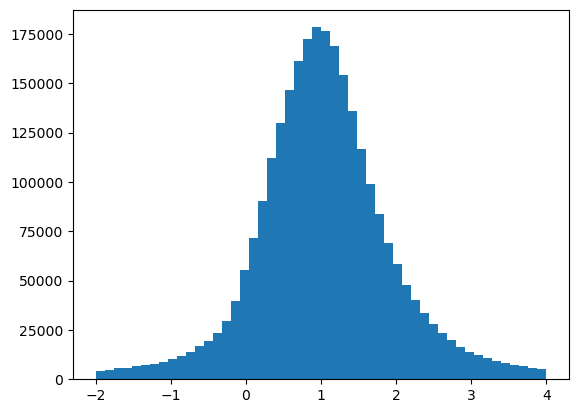

In [34]:
plt.hist(bdf.beta, bins=np.linspace(-2,4,51))
plt.show()

In [35]:
bdf.to_csv('../Data/Beta Data/computed_5ymonthly_betas_2023-12-27.csv')

In [36]:
len(wrds_fund_gvkeys)

28721

## Merge Data

In [37]:
wrds = pd.merge(wrds, bdf, left_index=True, right_index=True)

In [38]:
wrds.to_csv('../Data/Beta Data/Total Thesis Beta Data 2023-12-27.csv')

In [ ]:
#np.random.randint(len(wrds))

In [ ]:
#wrds.sort_values(['gvkey','datadate'], ascending=[True, False], inplace=True)

Original Code:

    win = 60

    # array for computing betas--must have 60 preceding items
    def winarray(x = 120, window = 60):
        returnarray = np.arange(x)
        returnarray = returnarray >= (window - 1)
        return returnarray

    gbreg = miniwrds.groupby('gvkey').apply(
        lambda x: RollingOLS.from_formula(
            'stock_excess_return ~ market_excess_return', 
            data=x, window=win, subset=winarray(len(x), win)
        ).fit().params
    )

    gbreg = miniwrds.groupby('gvkey').apply(
        lambda x: RollingOLS(
            endog=x['stock_excess_return'], 
            exog=sm.add_constant(x['market_excess_return']), 
                                 window=win
        ).fit().params
    )
    
None of this worked

I'm trying to run a bunch of CAPM regressions on several thousand companies for my honors thesis. I can (and have) do this with a for loop, where each iteration is a company, but this seems inefficient. I know from [this](https://stackoverflow.com/questions/56457085/rolling-regression-by-group-in-pandas-dataframe) that it can be done, but when I try it with my data, I get several errors. 

My data has three columns, `trt1m` (company's return), `r_f` (risk-free rate), and `market_return` (S&P 500's return). Each observation is a month for a specific firm. The regression should be 

(company's return - risk-free rate) = b0 + b1(market_return - risk-free rate) + error

where b1 is the firm's bivariate CAPM beta. This isn't too relevant to the code, but it might illustrate what I'm trying to do since this is a common regression in economics/finance. 

Below is my original code

    gbreg = wrds.groupby('gvkey').apply(
        lambda x: RollingOLS.from_formula(
            'I(trt1m - r_f) ~ I(market_return - r_f)', 
            data=x, window=60
        ).fit().params
    )

When I run this regression, I get an `index out of bounds` error. Some firm's don't have the necessary 60 months for a regression, but shouldn't the rolling ols handle for that? Or, if do have a company with more than 60 months, then it should ignore the first 59 automatically, right?

Next, I tried to filter out the regressions involving fewer than 60 months, but then I get the error `zero-size array to reduction operation maximum which has no identity`. Some firms have `NA`s, but shouldn't the rolling regression automatically filter for this?

    win = 60

    # array for computing betas--must have 60 preceding items
    def winarray(x = 120, window = 60):
        returnarray = np.arange(x)
        returnarray = returnarray >= (window - 1)
        return returnarray

    gbreg = wrds.groupby('gvkey').apply(
        lambda x: RollingOLS.from_formula(
            'I(trt1m - r_f) ~ I(market_return - r_f)', 
            data=x, window=win, subset=winarray(len(x), win)
        ).fit().params
    )
    
Any insight you can provide into rolling groupby regressions would be very helpful.